# Instruction Notebook (80 samples)

### Author: Yunus Shariff 
**Email:** shariff.yunus96@gmail.com

Scripts tested in `Python 3.12.2` as of **07/08/24**

The cumulative goal of this project is to further the research from [In-Home Mobility Frequency and Stability in Older Adults Living Alone With or Without MCI: Introduction of New Metrics](https://www.frontiersin.org/journals/digital-health/articles/10.3389/fdgth.2021.764510/full) by `Chao-Yi Wu, et al.` 

In lieu of standardized test scores, which can yield highly accurate results, the focus is to quantify behavioral patterns, group differences (gender, geography, race, etc.,) and/or feature interactions collected from monitoring the daily living habits of older adults to reliably detect MCI (Mild Cognitive Impairment), which may occur as a transitional stage between normal aging and dementia. MCI may include problems with memory, language or judgement.

This notebook contains instructions for the following sections/scripts 

1. `DemoClean.py`: Read demographic info (files) from 3 data sources/studies and outputs a combined demographic csv
2. `ProcessSensor.py`: Read weekly survey and outputs combined demographic-survey csv
3. `Sleep and Step Data`: Read daily step & sleep data and output weekly step & sleep data enriched with demographic-survey csv 
4. `Additional features Calculation`: Calculate interdaily stability and interdaily stability of weekly step counts
5. `Predictions`: Using a combination of the weekly data from above, classify subject between two classes, namely, MCI (Mild Cognitive Impairment) or Normal cognition.

Note: The sections for `DemoClean.py` and `ProcessSensor.py` have undergone several revisions from the original scripts. 

In [1]:
from platform import python_version

print(f"This machine uses python {python_version()}") 

This machine uses python 3.12.2


## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
from itertools import compress
from collections import Counter

# Survey/Room Sensor analyses
import datetime as dt
from datetime import date, datetime
from datetime import timedelta
from numpy.polynomial.polynomial import polyfit
import matplotlib.patches as mpatches
import math
from astropy.modeling import models, fitting

# Model training
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc 
from sklearn.impute import KNNImputer, SimpleImputer
from xgboost import XGBClassifier

# Model evaulation
from sklearn import tree 
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix

# Feature analyses
from scipy import stats
from sklearn.linear_model import LinearRegression
import shap
import statsmodels.api as sm # SHAP analysis (p-value, model coefficient)
from scipy.stats import ttest_ind # for group differences (if any feature(s) contribute towards class separation)
from math import ceil, log # for histograms & log tranform


pd.set_option('display.max_rows',150) # set max rows display to 150

## Function definitions

In [1]:
def update_dtypes(df, column_list, category_type):
    """
    update the category of the columns provided in `df`
    category_type: str i.e., list of columns will be updated to the same category type
    """
    for col in column_list:
        
        if category_type == 'category' and type(df.loc[0,col])!= str:
            df.loc[:,col] = df[col].astype('int64') 

        df.loc[:,col] = df[col].astype(category_type)


In [5]:
def reqd_directories(folder_num: str):
    """
    returns directories and subdirectories (if any) by matching folder substring

    folder_num (input): Folder substring (user specified), to locate appropriate directory
                     
    dict_rootlen: dictionary to store path and corresponding length of path string
    dict_subdir: dictionary to store root path and corresponding list of subdirectionaries

    parent_folder_path (output): the path for the parent folder, which contains `folder_num` in its name
    dict_subdir[parent_folder_path] (output): the path of subdirectories which exist in the matched parent folder above
    """

    dict_rootlen = dict() # stores len of the path string for each path string matched with  `folder_num`
    dict_subdir = dict()  # stores list of subdirectory names corresponding to paths containing `folder_num`

    for root, dirs, files in os.walk(os.getcwd(), topdown = False):
        if folder_num in root: # root is any path that contains  `folder_num`. This can be parent folder path, first-level subdirectories and innermost child (sub) directories
            dict_rootlen[root] = len(root) # we store the length of each matched path string; parent folder path will have the shortest length i.e., least amount of characters
            if dirs: 
                dirs.sort() # if subdirectories exist, sort them alphabetically and save them wrt the appropriate folder path; we only export the first-level subdirectories
                dict_subdir[root] = dirs

    parent_folder_path = [key for key in dict_rootlen.keys() if dict_rootlen[key] == min(dict_rootlen.values())][-1]

    if not dict_subdir: # if there are no subdirectories export parent folder path alone
        return parent_folder_path
    else: 
        return parent_folder_path, dict_subdir[parent_folder_path] # export parent folder path & list of first-level subdirectories 

### Process Sensor functions

In [5]:
def compute_diff(df, cols):
    """
    Compute difference between datetime columns and return updated df.
    Used to determine the number of days a subject may have been away from home (vacation/emergency) or had visitors.
    
    df(input): dataframe shape(_,3) containing dates from completed surveys indicating participants were either away or had visitors. 
    
    cols: datetime columns expected as [start_of_visit, end_of_visit, recorded_date], i.e., [VIS1_ARR, VIS1_LEAVE, RecordedDate]
          or [AWAY1_LEAVE, AWAY1_RET, RecordedDate]

    df(output): input df shape concatenated with "difference columns" w/ shape (_,5) i.e., 
                [start_of_visit, end_of_visit, recorded_date, diff_visit_days, diff_visit_end_date_and_recorded_date]

    """
    
    temp = pd.DataFrame()
    name = cols[0][:3] # name = "VIS1" from [VIS1_ARR, VIS1_LEAVE, RecordedDate] or "AWAY1" from [AWAY1_LEAVE, AWAY1_RET, RecordedDate]
    
    temp[[f'Diff_{name}',f'Diff_{name}_Rec']] = df[cols].diff(axis = 1).iloc[:,1:] # extract (VIS1_LEAVE - VIS1_ARR) & (RecordedDate - VIS1_LEAVE)
    temp = pd.concat([(temp[f'Diff_{name}']).dt.days, (temp[f'Diff_{name}_Rec']).dt.days],axis =1) # formatting 
    df = pd.concat([df,temp], axis = 1) # append the computed columns to the input dataframe

    # exclude dates where participants may have swapped departure and arrival dates in the questionnaire
    df = df[(df[f'Diff_{name}']>-1) & (df[f'Diff_{name}_Rec']>-1)].reset_index(drop = True) 
     
    return df


In [6]:
def unique_dates(list_name, dict_name):
    """
    Aggregate dates identified in weekly questionnaires for each participant

    list_name: list of dictionaries, each containing one key (homeid), pointing to a list of dates. 
    dict_name: single dictionary containing multiple keys (homeids) pointing to a consoldated list of dates, corresponding to that homeid
       
    Since we have several dates for each participant (homeid), list_name contains several dicts for the same homeid pointing to several lists
    of dates. The goal is to clean up these duplicates and create a single dictionary where each of the homeids is a unique keys consolidating
    all the dates relevant to that homeid as corresponding items
    
    """
    for dic in list_name: # iterate over each dict in list_name
        for lis in dic: # each dict only has one key (homeid). If homeid found already exists in target, append dates, else create new entry
            if lis in dict_name:
                dict_name[lis] += (dic[lis])
            else:
                dict_name[lis] = dic[lis]


def Daylight(latitude,day):
    """
    Get the amount of daylight per day per site using latitude
    """
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day - 186)))))
    pi = math.pi
    daylightamount = 24 - (24 / pi) * math.acos(
        (math.sin((0.8333 * pi / 180) + math.sin(latitude * pi / 180) * math.sin(P)) / (math.cos(latitude * pi / 180) * math.cos(P))))
    return daylightamount

### Sleep and Step data functions

In [7]:
def IS_calc(df, outcome, h_var):
    """
    Calculate Interdaily stability (IS) - only works if we have hourly granularity of the outcome (feature of interest).
    IS is a measure of stability of the outcome (steps) over the duration of observation (week) by comparing patterns from each day to the 
    avg pattern across the total number of days (week)
    
    df: df w/ steps logged every hour for pre-specified duration (e.g., week) for a particular subject (sorted by date & hour)
    h_var: feature denoting hour marker (1, 2,..., 24)
    outcome: the feature (steps) whose interdaily stability must be determined
    
    """
    df_len = len(df)
    if df_len > 0:
        
        h_len = df[h_var].nunique() # will be 24 since df is interpolated for any missing dates (and hours) within the desired window (week)
        out_mean = df[outcome].mean() # mean value of steps for the duration of data available
        h_error = sum(np.square(df.groupby(h_var)[outcome].mean() - out_mean)) # SSE of mean steps (grouped by hour) & weekly mean
        k_error = sum(np.square(df[outcome] - out_mean))  # SSE of steps & weekly mean
        if k_error!=0: 
            value = (df_len * h_error) / (h_len * k_error) # compute IS 
            return value
    else:
        return np.nan # if no data is available 

    
def IV_calc(df, outcome, h_var):
    """
    Calculate Interdaily variability (IV) - only works if we have hourly granularity of the outcome (feature of interest).
    IV is a measure of variation in the outcome (steps) over the duration of observation (week) by comparing patterns from each day to the 
    avg pattern across the total number of days (week)

    df: df w/ steps logged every hour for pre-specified duration (e.g., week) for a particular subject (sorted by date & hour)
    h_var: feature denoting hour marker (1, 2,..., 24)
    outcome: the feature (steps) whose interdaily variability must be determined
    
    """
    df_len = len(df)
    
    if df_len > 0:
        
        list1 = df[outcome].iloc[:-1].tolist() # index 0 to index (n-1) steps 
        list2 = df[outcome].iloc[1:].tolist() # index 1 to index n steps; to perform diff of steps b/w subsequent hours 
        error = [np.square(ele1 - ele2) for (ele1, ele2) in zip(list1, list2)] # Squared error of steps between every hour 
        sum_error = sum(error) # SSE of hourly steps

        out_mean = df[outcome].mean() # weekly mean of steps 
        k_error = sum(np.square(df[outcome] - out_mean)) # SSE of steps & weekly mean 
        if k_error!=0: 
            value = (df_len * sum_error) / ((df_len - 1)*k_error) # compute IV
            return value
        
    else:
        return np.nan # if no data is available 
    
    

### Additional features calculation functions

In [8]:
# Define a function to calculate weekly averages
def calculate_weekly_average(row):
    """
    Appends average weekly "chunked" steps to the each row of df calling this fn.
    This fn only filters chunked_df based on date. 
    
    chunked_df is generated from hourly step data before this function is called. It is a condensed version of hourly data.
    
    chunked_df: each row corresponds to total daily steps for a participant dissected into four 6 hr groups (morning, afternoon, evening & midnight).
                Generated from hourly step data. If the hour at which steps recorded lies between midnight & 6am, it's classified as 
                "midnight steps", similarly steps between 6am and 12pm are "morning steps"... 

                
    
    """
    
    subid = row['subid']
    report_date = row['report_date']
    
    # Filter all_hourly_data (df w/ hourly data) for the past 7 days from report_date
    past_7_days = chunked_df[(chunked_df['subid'] == subid) &
                                  (pd.to_datetime(chunked_df['date']) >= pd.to_datetime(report_date) - timedelta(days=8)) &
                                  (pd.to_datetime(chunked_df['date']) < pd.to_datetime(report_date))]
    
    # Calculate the average of the selected time intervals
    weekly_avg = past_7_days[['midnight_steps', 'morning_steps', 'afternoon_steps', 'evening_steps']].mean()
    return pd.Series(weekly_avg, index=['midnight_steps', 'morning_steps', 'afternoon_steps', 'evening_steps'])

### T-test functions

In [9]:
def avg_desired_weeks(df_with_date, period = 7):
    """
    df_with_date: df containing `date` column  
    period: no of days from first date (range of dates) for which avg is calculated. Default=7
    
    avg_df: df with aggregated values, based on period (default avg of first week), to be used for t-test. Dates dropped to compute aggregates
    """
    avg_df = pd.DataFrame()
    
    for id in df_with_date['subid'].unique(): # parse through each subid
        subset = df_with_date[df_with_date['subid'] == id].reset_index(drop = True)
        start_of_week = subset.loc[subset.index[0],'report_date'] # data is sorted by 'report_date', use first entry to determine first week
        
        first_week = pd.date_range(start_of_week,periods = period)
        first_week_df = subset[subset['report_date'].isin(first_week)].drop_duplicates(subset='report_date',keep='first').drop('report_date',axis=1) # drop date
        
        avg_df = pd.concat([avg_df,first_week_df.mean()], axis = 1) # date dropped to compute mean
        
    avg_df = avg_df.T.reset_index(drop = True)

    
    return avg_df


### Predictions functions

In [10]:
def preprocessing(imputed_df, encode_cols):
    """
    Perform standard scaling (z-score normalization) of numerical features, one-hot encode desired columns (encode_cols), and return
    along with unaltered (integer & binary categorical) columns in the output dataframe
    
    imputed_df: X_train or X_test after filling strategy
    encode_cols: Categorical columns to be one-hot encoded 

    """

    numerical_cols = imputed_df.columns[imputed_df.dtypes == 'float64'].tolist()

    # z-score normalization
    standard_scaler = StandardScaler()
    df_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(imputed_df[numerical_cols]), columns=numerical_cols)

    df_encoded = pd.DataFrame() # stores encoded columns
    
    # Iterate over each column and apply one-hot encoding
    for col in encode_cols:

        col_dummies = pd.get_dummies(imputed_df[col], prefix=col)
        col_dummies = col_dummies.astype('int64')
        df_encoded = pd.concat([df_encoded, col_dummies],axis = 1)
        
    iters = imputed_df.columns[imputed_df.dtypes == 'category'].tolist() # all categorical columns

    binary_cat_cols = [col for col in iters if col not in encode_cols] # exclude encoded columns; remaining are binary categories

    intg_cols = imputed_df.columns[imputed_df.dtypes == 'int64'] # store integer columns
    final_df = pd.concat([imputed_df[intg_cols],df_standard_scaled, imputed_df[binary_cat_cols], df_encoded], axis =1)

    return final_df 

In [11]:
def class_report_plot(y_test, y_pred):

    """
    Generates ROC curve for the classifiers in specified in the labels
    """
    
    print(classification_report(y_test, y_pred, target_names=['Non MCI', 'MCI']))
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.step(fpr,tpr)
    plt.ylabel('True Positive Rate');
    plt.xlabel('False Positive Rate');
    plt.legend(labels = ['DT','SVC', 'RF', 'LR','XGB'])

## Initialize file paths

In [6]:
demo_substring = '#1'

mobility_path, dirs = reqd_directories(demo_substring) 
if len(dirs) == 3:
    [demo_dir, weekly_surveys_dir, sensor_data_dir] = dirs
    
elif len(dirs) == 4: # if os creates .DS_Store file in directory
    [_,demo_dir, weekly_surveys_dir, sensor_data_dir] = dirs
    
mobility_path+= '/'
mobility_path

'/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#1 Home Mobility/'

In [8]:
demo_path = mobility_path + f"{demo_dir}/"
surveys_path = mobility_path + f"{weekly_surveys_dir}/"
sensor_data_path = mobility_path + f"{sensor_data_dir}/"

demo_path, surveys_path, sensor_data_path

('/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#1 Home Mobility/Data for Demo/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#1 Home Mobility/Data for ProcessSensor/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#1 Home Mobility/Dur/')

**The following results must be stored in the `cleaned_data_path`**

Step and sleep data have 265 unique subjects, however, not all of their demographic info is being used as merge with exclude_17 results in only 89.
- Weekly step + demographic for ids from source level
- Weekly sleep + demographic for ids from source level
- weekly step & sleep + demographic for ids from source level

1. exclude_17.csv
2. daily sleep data (merged w/ exclude_17 only)
3. weekly sleep data (merged w/ exclude_17 only)
4. daily sleep data (merged w/exclude_17 only)
5. weekly sleep data (merged w/ exclude_17 only)
6. exclude_17 + daily step data + daily sleep data
7. exclude_17 + weekly step data + weekly sleep data
8. hourly data (calculated features = IV_steps, IS_steps, acro_steps,…. )
9. hourly data (chunked step counts = morning, afternoon, evening, midnight)
10. exclude_17 merged w/ result from 8
11. exclude_17 merged w/ result from 9
12. exclude_17 merged w/ results from 8, followed by 9

In [9]:
# Export any csv of processed/merged data (excl. intermediates) generated by the notebook to the `Cleaned data` subdirectory

files = os.listdir(os.getcwd())
selectors = [dir.startswith('C') for dir in files]

c_items = list(compress(files, selectors))
cleaned_folder = [c for c in c_items if not re.search(r"[.]",c)][0]  # exclude any files that also starts with 'C'
cleaned_data_path = os.getcwd() + '/' + cleaned_folder + '/'
cleaned_data_path

'/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/Cleaned data/'

In [10]:
# Sleep data paths

watch_sensor_substring = '#2'

clinical_path, dirs = reqd_directories(watch_sensor_substring)
dirs.sort()

if len(dirs) == 2:
    [dir_2a, dir_2b] = dirs

elif len(dirs) == 3:
    [_,dir_2a, dir_2b] = dirs

clinical_path += '/'
clinical_path, dir_2a, dir_2b

('/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/',
 '2a',
 '2b')

In [12]:
# Exclude any matches with file extensions

sleep_step_path = [clinical_path + dir_2a + f"/{folder}/" for folder in os.listdir(clinical_path + dir_2a) if not re.search(r"[.]",folder)][0] 
watch_raw_path = [clinical_path + dir_2b + f"/{folder}/" for folder in os.listdir(clinical_path + dir_2b) if not re.search(r"[.]",folder)][0]


dir_2a_path = clinical_path + dir_2a + '/'
dir_2b_path = clinical_path + dir_2b + '/'

dir_2a_path, dir_2b_path, sleep_step_path, watch_raw_path

('/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2a/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2b/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2a/Sleep and Step Data/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2b/Watch_Raw_Data/')

In [27]:
baseline_substring = '#3'
root_path, [Approach1, Approach2] = reqd_directories(baseline_substring)
root_path += '/'
root_path, Approach1, Approach2

approach1_path = root_path +  f"{Approach1}/"
approach2_path = root_path +  f"{Approach2}/"
approach1_path, approach2_path


('/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#3 Obtain 3-month baseline/Approach 1/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#3 Obtain 3-month baseline/Approach 2/')

In [21]:
# Prediction paths

_ = reqd_directories('#4')
if type(_) == tuple: predict_path = _[0]
else: predict_path = _
predict_path += '/'
predict_path 


'/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#4 Predict MCI status/'

## Demo Clean.py

The below script follows the original `DemoClean.py` script from the study with some revisions.  
Any exclusions, value updates (unless specified) are due to corrections by the researchers from the study.

We start by reading demographic data from each cohort, OHSU/VA/MIAMI, RUSH and OLL, starting with OHSU, VA and MIAMI.

### Read CART data

Read participant demographic data from OHSU, VA and MIAMI-CART studies.  
The required file is `CART_long_demo.csv` which contains 707 features with details such as age, gender, education, race, occupation, lifestyle survey (smoking, alcohol intake, medication) and NACC (National Alzheimer's Coordinating Center) variables such as health conditions, disorders, recall and language test scores, etc., 

In [19]:
CART_demo = pd.read_csv(demo_path + 'CART_long_demo.csv', encoding = 'cp1252',parse_dates=['date_screen'])
pd.set_option('display.max_columns',len(CART_demo.columns))
CART_demo.shape

(575, 707)

#### Exclude 2 participants due to poor data quality

In [20]:
CART_demo = CART_demo[~CART_demo['subid'].isin([1891,2150])]
CART_demo.shape

(571, 707)

#### Update values

- Change annual year as 2018 occurs twice for the same participant
- Update missing value ('cdrglob'); `cdrglob` is global Clinical Dementia Rating, used to determine if a subject has MCI or not
- Select only desired columns (`707 -> 31`)

In [21]:
CART_demo.loc[(CART_demo['subid']==1352) & (CART_demo['date_screen'] == '2018-12-27'),'date_screen'] = pd.to_datetime('2019-1-1')
CART_demo.loc[(CART_demo['subid']==1353) & (CART_demo['age'] == 72.4), 'cdrglob'] = 0
CART_demo.rename(columns={'calculate_sum': 'gds_score'}, inplace=True)

In [22]:
req_cols = ['subid', 'date_screen', 'cdrsum', 'cdrglob', 'age', 'gender','race','educ','gait_test_time',
            'animals','veg','traila','trailb','exclude_iadl','exclude_adl',
         'exclude_med','gad_7_total','adcomcirs_total', 'mobility_inside_home', 'gds_score',
        'sleepap','remdis','hyposom','sleepoth', 'crafturs', 'digforct', 'digforsl', 'digbacct', 'digbacls',
            'craftdvr']


CART_demo = CART_demo.filter(items=req_cols)

### Read data of 4 additional participants 

Merge data from 4 participants to existing CART data.  
This is found in `20201201_4subid.csv`, rename appropriate columns and apply columns filters before merge

In [23]:
four = pd.read_csv(demo_path +'20201201_4subid.csv',encoding='cp1252', parse_dates = ['date_screen'])
four.head()

,subid,redcap_event_name,redcap_data_access_group,sub_loc,date_screen,name_first,name_middle_initial,name_last,tele_1,tele_1_type,tele_1_type_other,tele_2,tele_2_type,tele_2_type_other,address_mail_street,address_mail_city,address_mail_state,address_mail_zip,address_physical_samediff,address_physical_street,address_physical_city,address_physical_state,address_physical_zip,dem_ruca,dob,age,gender,dem_veteran,email,demo_notes,demographics_complete,ec_provided,ec_relation,ec_first_name,ec_last_name,ec_primary_phone,ec_pphone_type,ec_second_phone,ec_sphone_type,emergency_contact_complete,ivp_or_fvp,confirm_adc,reason,refersc,learned,prestat,prespart,sourcenw,birthmo,birthyr,sex,hispanic,hispor,hisporx,race,racex,racesec,racesecx,raceter,raceterx,primlang,primlanx,educ,maristat,livsitua,independ,residenc,zip,handed,nacc_uds3_a1_subject_demographics_required_complete,current_needs,adult_life_needs,subj_main_occupation,yrs_subj_main_occupation,subj_other_occupation,yrs_subj_other_occupation,spouse_main_occupation,yrs_spouse_main_occupation,spouse_other_occupation,yrs_spouse_other_occupation,current_employment_status,current_emplymnt_status_2,cart_ses_employment_complete,cognitive_status_1,cognitive_status_2,cognitive_status_3,cognitive_status_4,cognitive_status_5,cog_stat_amcimd,cognitive_status_6,cart_cognitive_status_complete,mobility_inside_home,mobility_outside_home,gait_test_time,cart_mobility_complete,nogds,satis,dropact,empty,bored,spirits,afraid,happy,helpless,stayhome,memprob,wondrful,wrthless,energy,hopeless,better,sum_unanswered,calculate_sum,gds,b6_notex,nacc_uds3_b6_gds_complete,np_battery,nb_admin_type,mmsecomp,mmsereas,mmseloc,mmselan,mmselanx,mmsevis,mmsehear,mmseorda,mmseorlo,pentagon,mmse,mocacomp,mocareas,mocaloc,mocalan,mocalanx,mocavis,mocahear,mocatots,moca_total_calc,mocatrai,mocacube,mocacloc,mocaclon,mocacloh,mocanami,mocaregi,mocadigi,mocalett,mocaser7,mocarepe,mocaflue,mocaabst,mocarecn,mocarecc,mocarecr,mocaordt,mocaormo,mocaoryr,mocaordy,mocaorpl,mocaorct,npsycloc,npsylan,npsylanx,logida,logiprev,logimem,craftvrs,crafturs,udsbentc,digif,digiflen,digib,digiblen,digforct,digforsl,digbacct,digbacls,animals,veg,traila,trailarr,trailali,trailb,trailbrr,trailbli,memunits,memtime,craftdvr,craftdre,craftdti,craftcue,udsbentd,udsbenrs,boston,minttots,minttotw,mintscng,mintscnc,mintpcng,mintpcnc,udsverfc,udsverfn,udsvernf,udsverlc,udsverlr,udsverln,udsvertn,udsvertn_2,udsverte,udsverte_2,udsverti,udsverti_2,otmt_time_a,otmt_error_a,otmt_cl_a,otmt_time_b,otmt_error_b,otmt_cl_a_2,np_notes,cogstat,nacc_uds3_c1c2_neuropsych_battery_required_complete,height,weight,bpsys,bpdias,hrate,bpmethod,bpmethod_other,vision,viscorr,viswcorr,hearing,hearaid,hearwaid,nacc_uds3_b1_physical_complete,anymeds,medication_1,medication_2,medication_3,medication_4,medication_5,medication_6,medication_7,medication_8,medication_9,medication_10,medication_11,medication_12,medication_13,medication_14,medication_15,medication_16,medication_17,medication_18,medication_19,medication_20,medication_21,subject_medications_complete,tobac30,tobac100,smokyrs,packsper,quitsmok,alcoccas,alcfreq,alcohol_specify,cvhatt,hattmult,hattyear,cvafib,cvangio,cvbypass,cvpacdef,cvchf,cvangina,cvhvalve,cvothr,cvothrx,cbstroke,strokmul,strokyr,cbtia,tiamult,tiayear,cb_notes,pd,pdyr,pdothr,pdothryr,seizures,tbi,tbibrief,tbiexten,tbiwolos,tbiyear,tbi_seizure_notes,diabetes,diabtype,hyperten,hypercho,b12def,thyroid,arthrit,arthtype,arthtypx,arthupex,arthloex,arthspin,arthunk,incontu,incontf,apnea,rbd,insomn,othsleep,othsleex,alcohol,abusothr,abusx,ptsd,bipolar,schiz,dep2yrs,depothr,anxiety,ocd,npsydev,psycdis,psycdisx,psyc_notes,nacc_uds3_a5_subject_health_history_complete,cancer,cancsite,diabet,myoinf,conghrt,afibrill,hypert,angina,hypchol,vb12def,thydis,arth,artype,artypex,artupex,artloex,artspin,artunkn,urineinc,bowlinc,sleepap,remdis,...,gad_7_6,gad_7_7,gad_7_total,gad_7_problems,gad7_complete,adcomcirs_1,adcomcirs_1a,adcomcirs_2,adcomcirs_2a,adcomcirs_3,adcomcirs_3a

In [24]:
four.rename(columns={'calculate_sum':'gds_score'},inplace = True)
four = four.filter(items=req_cols)  
CART_plus4 = pd.concat([CART_demo,four]).reset_index(drop = True)

### Filter for normal and MCI patients only

- `cdrglob` ranges from 0 to 1
- each participant's MCI status is mapped from their `cdrglob` score
- Participants whose `cdrglob` scores are unknown are dropped as their MCI status cannot be inferred.
- MCI status is determined for each cohort using slightly different methodologies

In [25]:
CART_plus4 = CART_plus4[(CART_plus4['cdrglob'] < 1) & (CART_plus4['cdrglob'] > -1)]
CART_plus4.reset_index(drop=True)

,subid,date_screen,cdrsum,cdrglob,age,gender,race,educ,gait_test_time,animals,veg,traila,trailb,exclude_iadl,exclude_adl,exclude_med,gad_7_total,adcomcirs_total,mobility_inside_home,gds_score,sleepap,remdis,hyposom,sleepoth,crafturs,digforct,digforsl,digbacct,digbacls,craftdvr
0,1113,2018-06-13,0.0,0.0,87.8,2.0,1.0,10.0,888.00,10.0,11.0,37.0,149.0,0.0,1.0,0.0,NaN,21.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1191,2018-04-24,0.0,0.0,81.8,2.0,1.0,16.0,888.00,22.0,12.0,42.0,77.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1199,2018-02-22,0.0,0.0,80.8,1.0,1.0,14.0,11.00,21.0,11.0,50.0,138.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1350,2018-04-24,0.0,0.0,66.9,2.0,1.0,16.0,8.00,18.0,12.0,51.0,117.0,0.0,0.0,0.0,1.0,22.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1351,2018-04-11,0.0,0.0,83.8,2.0,1.0,16.0,12.00,26.0,18.0,34.0,90.0,0.0,2.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,2184,2019-10-14,NaN,0.0,69.5,2.0,3.0,12.0,888.00,NaN,NaN,NaN,NaN,1.0,3.0,0.0,13.0,29.0,0.0,5.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
281,1891,2018-12-06,1.0,0.5,72.8,1.0,1.0,14.0,12.20,20.0,10.0,51.0,129.0,0.0,0.0,0.0,0.0,32.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,9.0,7.0,6.0,4.0,9.0
282,2150,2019-09-11,1.5,0.5,67.7,2.0,1.0,5.0,13.65,13.0,9.0,83.0,171.0,4.0,4.0,1.0,9.0,28.0,0.0,4.0,0.0,0.0,1.0,0.0,6.0,5.0,5.0,6.0,4.0,4.0
283,2199,2019-10-25,0.0,0.0,76.0,2.0,1.0,16.0,11.90,19.0,21.0,34.0,109.0,0.0,0.0,0.0,1.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,9.0,7.0,4.0,3.0,15.0


In [26]:
CART_plus4['mci'] = CART_plus4['cdrglob'].map({0:0, 0.5:1}) # create new column for MCI status
CART_plus4['year'] = CART_plus4['date_screen'].dt.year
CART_plus4.loc[CART_plus4['gait_test_time']==888, 'gait_test_time']=np.nan # 888 corresponds to missing value
CART_plus4['gait'] = 9.144/CART_plus4['gait_test_time'] # convert units of gait speed test
CART_plus4.reset_index(drop=True)

,subid,date_screen,cdrsum,cdrglob,age,gender,race,educ,gait_test_time,animals,veg,traila,trailb,exclude_iadl,exclude_adl,exclude_med,gad_7_total,adcomcirs_total,mobility_inside_home,gds_score,sleepap,remdis,hyposom,sleepoth,crafturs,digforct,digforsl,digbacct,digbacls,craftdvr,mci,year,gait
0,1113,2018-06-13,0.0,0.0,87.8,2.0,1.0,10.0,NaN,10.0,11.0,37.0,149.0,0.0,1.0,0.0,NaN,21.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,NaN
1,1191,2018-04-24,0.0,0.0,81.8,2.0,1.0,16.0,NaN,22.0,12.0,42.0,77.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,NaN
2,1199,2018-02-22,0.0,0.0,80.8,1.0,1.0,14.0,11.00,21.0,11.0,50.0,138.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,0.831273
3,1350,2018-04-24,0.0,0.0,66.9,2.0,1.0,16.0,8.00,18.0,12.0,51.0,117.0,0.0,0.0,0.0,1.0,22.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,1.143000
4,1351,2018-04-11,0.0,0.0,83.8,2.0,1.0,16.0,12.00,26.0,18.0,34.0,90.0,0.0,2.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,0.762000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,2184,2019-10-14,NaN,0.0,69.5,2.0,3.0,12.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.0,13.0,29.0,0.0,5.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2019,NaN
281,1891,2018-12-06,1.0,0.5,72.8,1.0,1.0,14.0,12.20,20.0,10.0,51.0,129.0,0.0,0.0,0.0,0.0,32.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,9.0,7.0,6.0,4.0,9.0,1,2018,0.749508
282,2150,2019-09-11,1.5,0.5,67.7,2.0,1.0,5.0,13.65,13.0,9.0,83.0,171.0,4.0,4.0,1.0,9.0,28.0,0.0,4.0,0.0,0.0,1.0,0.0,6.0,5.0,5.0,6.0,4.0,4.0,1,2019,0.669890
283,2199,2019-10-25,0.0,0.0,76.0,2.0,1.0,16.0,11.90,19.0,21.0,34.0,109.0,0.0,0.0,0.0,1.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,9.0,7.0,4.0,3.0,15.0,0,2019,0.768403


We have 3 additional columns, `gait`, `mci` and `year`. Total number of columns is now **34**

### Read Home info of participants

This file `Single_Resident_Homes_CART.csv` contains subids along with study and home id information. This has to be *merged* with CART data

In [27]:
homeid_CART = pd.read_csv(demo_path + 'Single_Resident_Homes_CART.csv') 
homeid_CART.head()

,study,homeid,subid
0,OHSU_CART,922,1191
1,OHSU_CART,931,1199
2,OHSU_CART,1093,1350
3,OHSU_CART,1094,1351
4,OHSU_CART,1095,1352


In [28]:
homeid_CART['study'].value_counts()

study
OHSU_CART     74
RUSH_CART     51
MIAMI_CART    24
VA_CART       21
Name: count, dtype: int64

In [29]:
homeid_CART['subid'].value_counts()

subid
1695    3
1191    2
1666    2
1855    2
1712    2
       ..
1865    1
1912    1
1931    1
1943    1
2294    1
Name: count, Length: 162, dtype: int64

As some subids correspond to more than one homeid, distinct entries (latest) must be extracted. 

In [30]:
homeid_CART = homeid_CART.groupby('subid').last().reset_index()

In [31]:
# Right join because we want to pull subids and homeids for RUSH too, as we only update these common subids using RUSH demographics
CART_homeid = pd.merge(CART_plus4, homeid_CART, on='subid', how='right') 

In [32]:
CART_homeid

,subid,date_screen,cdrsum,cdrglob,age,gender,race,educ,gait_test_time,animals,veg,traila,trailb,exclude_iadl,exclude_adl,exclude_med,gad_7_total,adcomcirs_total,mobility_inside_home,gds_score,sleepap,remdis,hyposom,sleepoth,crafturs,digforct,digforsl,digbacct,digbacls,craftdvr,mci,year,gait,study,homeid
0,1191,2018-04-24,0.0,0.0,81.8,2.0,1.0,16.0,NaN,22.0,12.0,42.0,77.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2018.0,NaN,OHSU_CART,1527
1,1199,2018-02-22,0.0,0.0,80.8,1.0,1.0,14.0,11.0,21.0,11.0,50.0,138.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2018.0,0.831273,OHSU_CART,931
2,1350,2018-04-24,0.0,0.0,66.9,2.0,1.0,16.0,8.0,18.0,12.0,51.0,117.0,0.0,0.0,0.0,1.0,22.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2018.0,1.143000,OHSU_CART,1093
3,1351,2018-04-11,0.0,0.0,83.8,2.0,1.0,16.0,12.0,26.0,18.0,34.0,90.0,0.0,2.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2018.0,0.762000,OHSU_CART,1094
4,1352,2018-02-22,0.0,0.0,70.0,2.0,1.0,13.0,17.0,26.0,15.0,37.0,68.0,0.0,1.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2018.0,0.537882,OHSU_CART,1095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2242,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUSH_CART,1960
199,2244,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIAMI_CART,1962
200,2248,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIAMI_CART,1966
201,2259,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUSH_CART,1968


We now have `36` columns with the inclusion of study and homeid columns

**05/15/24: Update gender for `1736` as male. Provided by Chao-Yi, due to subject being marked as male and female in each annual checkup**

In [33]:
CART_homeid.loc[CART_homeid['subid'] == 1736,'gender'] = 1

### Read RUSH demographic data

This study is for people in Chicago. Standardize column names & mappings to align with CART/OLL data  
For MARS source, MCI status is based on `dcfdx` field,  
`dcfdx` == 1 => normal, `dcfdx` == 2 => MCI

- Read `mars.csv`

In [34]:
mars = pd.read_csv(demo_path + 'mars.csv')
mars = mars.iloc[:,1:] # Dropped index column
mars['gender'].value_counts()

gender
0.0    54
1.0    14
Name: count, dtype: int64

#### Read `rush_additional_csv` to update gender for subid 1791

- RUSH cohort has missing gender for 6 subids, which are dropped when demographic data from all sources are merged.
- To prevent this, missing gender must be updated for these 6 subjects. However, we are only able to update gender, dcdfx and mci for one subid.
- There is also a file named `rush_final_20210708.csv` which is also considered, however this file is similar to `mars.csv` with multiple entries for each subid, with the same subids missing gender.
- For clarification refer to `Appendix 1`

- Read `rush_additional.csv`

In [35]:
mars_additional = pd.read_csv(demo_path + 'rush_additional.csv') 
mars_additional.rename(columns = {'home_id': 'homeid', 'sub_id': 'subid'}, inplace = True)

mars_additional

,projid,fu_year,subid,homeid,visseq,dcfdx,cts_mmse30,age_at_visit,age_bl,age_death,educ,msex,race7,spanish
0,22121512,4,1791,1577,22121512_4,1,25.0,81.284052,76.303901,82.746064,12.0,0.0,2.0,2.0
1,22121512,5,1791,1577,22121512_5,1,27.0,82.631075,NaN,NaN,NaN,NaN,NaN,NaN
2,45438846,0,2259,1968,45438846_0,2,26.0,69.782341,69.782341,71.184120,18.0,0.0,2.0,2.0
3,45438846,1,2259,1968,45438846_1,1,NaN,70.475017,NaN,NaN,NaN,NaN,NaN,NaN
4,49758987,7,1937,1690,49758987_7,1,29.0,78.160164,70.455852,79.044490,12.0,1.0,2.0,2.0


In [36]:
# common subids between the two files

mars_add_in_mars = [id for id in mars_additional['subid'].unique() if id in mars['subid'].unique().astype('int64')] # MARS_ADD & MARS = 3/74
mars_add_in_mars 

[1791, 2259, 1937]

In [37]:
copy_sex = mars_additional.loc[(mars_additional['subid']==1791), ['msex']].dropna().values[0][0]
copy_mci = mars_additional.loc[(mars_additional['subid']==1791), ['dcfdx']].dropna().values[0][0]
copy_visit = mars_additional.loc[(mars_additional['subid']==1791), ['fu_year']].dropna().values[0][0]
copy_age = mars_additional.loc[(mars_additional['subid']==1791), ['age_at_visit']].dropna().values[0][0]
mars_additional.loc[(mars_additional['subid'].isin(mars_add_in_mars)), ['subid','msex','dcfdx']].dropna()

,subid,msex,dcfdx
0,1791,0.0,1
2,2259,0.0,2
4,1937,1.0,1


In [38]:
mars.loc[(mars['subid'].isin(mars_add_in_mars)) & (mars['gender'].isna()), ['gender']] =  copy_sex
mars.loc[(mars['subid'].isin(mars_add_in_mars)) & (mars['age'].isna()), ['age']] =  copy_age
mars.loc[(mars['subid'].isin(mars_add_in_mars)) & (mars['enroll_visit'].isna()), ['enroll_visit']] = copy_visit
mars.loc[(mars['subid'].isin(mars_add_in_mars)) & (mars['dcfdx'].isna()), ['dcfdx']] = copy_mci
mars.loc[(mars['subid'].isin(mars_add_in_mars)) & (mars['mci'].isna()), ['mci']] = 0  # inferred from `dcfdx` flag
mars.loc[(mars['subid']==1791), ['subid','gender','age','dcfdx','mci']] 

,subid,gender,age,dcfdx,mci
17,1791,0.0,81.284052,1.0,0.0


In [39]:
mars['gender'] = mars['gender'].map({0:1, 1:2}) # Update gender mapping to match OHSU, VA and MIAMI CART
mars['gender'].value_counts()

gender
1.0    55
2.0    14
Name: count, dtype: int64

In [40]:
mars.head()

,subid,homeid,projid,enroll_visit,dcfdx,cts_mmse30,age,mci,educ,gender,q1mme,q2mme,q3mme,q4mme,q5mme,q6mme,q7mme,q8mme,q9mme,q10amme,q10bmme,apple,tabl,penny,q12amme,q12bmme,q13amme,q13bmme,q13cmme,q14mme,q15mme,q16mme,q17mme,paper,folds,places,q19mme,q20mme,story,tree,bed,whistle,flower,house,canoe,toothbr,volcano,mask,camel,harmon,tongs,hammock,funnel,domino,cantread,wordt1_1,wordt1_2,wordt1_3,wordt1_4,wordt1_5,wordt1_6,wordt1_7,wordt1_8,wordt1_9,wordt1_x,wordt2_1,wordt2_2,wordt2_3,wordt2_4,wordt2_5,wordt2_6,wordt2_7,wordt2_8,wordt2_9,wordt2_x,wordt3_1,wordt3_2,wordt3_3,wordt3_4,wordt3_5,wordt3_6,wordt3_7,wordt3_8,wordt3_9,wordt3_x,page3,page4,page5,page6,page7,page8,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6,recall_7,recall_8,recall_9,recall_x,wrdrecb1,wrdrecb2,wrdrecb3,wrdrecb4,wrdrecb5,wrdrecb6,wrdrecb7,wrdrecb8,wrdrecb9,wrdrecbx,wordrec1,wordrec2,wordrec3,wordrec4,wordrec5,wordrec6,wordrec7,wordrec8,wordrec9,wordrecx,line1a,line1b,line2a,line2b,line3a,line3b,line4a,line4b,line5a,line5b,line6a,line6b,line7a,line7b,line8a,line8b,line9a,line9b,line10a,line10b,line11a,line11b,line12a,line12b,line13a,line13b,line14a,line14b,line15a,line15b,digfor1a,digfor1b,digfor2a,digfor2b,digfor3a,digfor3b,digfor4a,digfor4b,digfor5a,digfor5b,digfor6a,digfor6b,digbakp1,digbakp2,digbak1a,digbak1b,digbak2a,digbak2b,digbak3a,digbak3b,digbak4a,digbak4b,digbak5a,digbak5b,digbak6a,digbak6b,clothing,animals,fruits,sink1,sink2,hammer1,hammer2,flour1,flour2,boots1,boots2,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,item11,item12,item13,item14,item15,item16,a2,a4,a8,a12,b1,b2,b3,b4,b5,b6,b8,b10,row1,row2,row3,row4,row5,row6,row7,row8,row9,row10,row11,nart_ach,nart_ind,nart_deb,nart_sie,nart_pla,nart_fac,nart_imp,nart_bla,nart_cav,nart_cab,bluebox,greenbox,graybox,redbox,readatm,readinc,practred,practblu,coloratm,colorinc,smell1,smell2,smell3,smell4,smell5,smell6,smell7,smell8,smell9,smell10,smell11,smell12,q12bmme_s,mmse_total,normcog
0,2028,1774,4421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
1,1739,1530,85709,0.0,1.0,26.0,80.670773,0.0,16.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dlrow,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,ddsssdss,dsdssdds,sssssdds,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,6.0,3.0,8.0,1.0,9.0,7.0,11.0,1.0,4.0,2.0,10.0,2.0,5.0,7.0,9.0,1.0,3.0,5.0,9.0,1.0,7.0,8.0,11.0,5.0,8.0,3.0,10.0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,17.0,19.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,14.0,89.0,14.0,236.0,1234.0,1246.0,3577.0,1279.0,2679.0,169.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,1.0,4.0,2.0,6.0,1.0,2.0,5.0,3.0,6.0,6.0,2.161246e+09,6.341269e+09,4.578137e+09,2.000000e+00,NaN

### Prep RUSH data for merge

- RUSH data must be combined with OHSU and VA CART
- This means that column names must match, hence the renaming and update of gender representation
- Split columns (digfor1a, digfor1b,... digfor6b) must be merged into single columns (digforct i.e., forward count). Similar for backward count

In [41]:
mars.rename(columns={'mmse_total': 'mmse', 'story': 'crafturs', 'fruits':'veg'}, inplace = True) 


In [42]:
for_ct = [s for s in mars.columns if s.startswith('digfor')]
for_ct

['digfor1a',
 'digfor1b',
 'digfor2a',
 'digfor2b',
 'digfor3a',
 'digfor3b',
 'digfor4a',
 'digfor4b',
 'digfor5a',
 'digfor5b',
 'digfor6a',
 'digfor6b']

In [43]:
bac_ct = [s for s in mars.columns if re.search(r"\bdigbak[^p]",s)] # exclude digbakp1, digbakp2
bac_ct

['digbak1a',
 'digbak1b',
 'digbak2a',
 'digbak2b',
 'digbak3a',
 'digbak3b',
 'digbak4a',
 'digbak4b',
 'digbak5a',
 'digbak5b',
 'digbak6a',
 'digbak6b']

In [44]:
mars['digforct'] = mars[for_ct].sum(axis=1, skipna = True)
mars['digbacct'] = mars[bac_ct].sum(axis=1, skipna = True)

In [45]:
drop_ids = mars.loc[mars['enroll_visit'].isna(),'subid'].tolist() # [1791, 1885, 1886, 2022, 2028, 2179]
mars = mars[~mars['subid'].isin(drop_ids)]
mars['enroll_visit'] = mars['enroll_visit'].astype('int64')
print(mars.shape)

(69, 264)


#### Read RUSH gait speed data 

Read `gait speed data 04-2021.csv`. 
This file contains project id, enroll_visit and gait.
Merge this data with RUSH demographic data

In [46]:
gait = pd.read_csv(demo_path + 'gait speed data 04-2021.csv')
gait

,projid,enroll_visit,gait
0,85709,0,0.508000
1,85709,1,0.443345
2,85709,2,NaN
3,1085867,0,0.243840
4,1085867,1,0.508000
...,...,...,...
494,98129389,0,0.541867
495,98129389,1,0.686873
496,98129389,2,0.508000
497,98129389,3,0.387048


In [47]:
mars = pd.merge(mars, gait, on=['projid','enroll_visit'], how='left')

Incorrect assessment years are corrected with educational guess based on subid

In [48]:
mars.loc[mars['subid']<1789,'year'] = 2018 
mars.loc[mars['subid']>= 1789, 'year'] = 2019
mars['year'] = mars['year'].astype('int64')

### Enrich OHSU and VA with RUSH data 

CART study has subids which exist in RUSH study, however, these have missing values in our CART data. 

- Check for common subids between both (`51`)
- Import data for these common subids from RUSH into (CART study + home id) data for selected columns (`263` in RUSH & `36` in CART vs. `12` being updated )

In [49]:
common_ids = CART_homeid.loc[CART_homeid['subid'].isin(mars['subid']), 'subid'].tolist()
mars_for_enrichment = mars[mars['subid'].isin(common_ids)]

In [50]:
CART_homeid[CART_homeid['subid'].isin(common_ids)].isna().all().sum()

32

In [51]:
req_cols_from_rush = ['year', 'mci', 'age', 'educ', 'gender', 'crafturs', 'animals', 'veg', 'digforct', 'digbacct','gait']
CART_homeid.loc[CART_homeid['subid'].isin(common_ids),req_cols_from_rush] = mars_for_enrichment[req_cols_from_rush].values

In [52]:
CART_homeid.loc[CART_homeid['subid'].isin(common_ids),['subid'] + req_cols_from_rush]

,subid,year,mci,age,educ,gender,crafturs,animals,veg,digforct,digbacct,gait
72,1727,2018.0,0.0,80.670773,16.0,1.0,14.0,17.0,19.0,6.0,4.0,0.508000
73,1730,2018.0,0.0,67.479808,18.0,1.0,13.0,15.0,20.0,7.0,6.0,0.524387
81,1738,2019.0,1.0,67.019849,18.0,1.0,6.0,17.0,21.0,11.0,4.0,0.633351
82,1739,2018.0,0.0,76.213552,20.0,1.0,11.0,13.0,10.0,6.0,3.0,0.334027
83,1740,2019.0,0.0,75.088296,14.0,1.0,13.0,18.0,15.0,7.0,5.0,0.508000
93,1758,2018.0,0.0,82.012320,12.0,1.0,10.0,11.0,23.0,12.0,4.0,0.650240
94,1759,2018.0,0.0,70.904860,17.0,1.0,19.0,28.0,20.0,11.0,7.0,0.633351
95,1760,2018.0,0.0,77.420945,14.0,1.0,12.0,10.0,18.0,10.0,5.0,0.594732
102,1769,2019.0,0.0,76.695414,12.0,1.0,16.0,11.0,17.0,4.0,5.0,0.288568
105,1771,2018.0,0.0,65.275838,18.0,1.0,13.0,15.0,17.0,7.0,8.0,0.502763


In [53]:
CART_homeid.loc[CART_homeid['digforsl']==9, 'digforct'] = np.nan
CART_homeid.loc[CART_homeid['digbacls']==8, 'digbacct'] = np.nan

In [54]:
CART_homeid.loc[CART_homeid['study'] == 'RUSH_CART',:].shape

(51, 35)

### Read OLL data

- `oll_g.csv`: Only contains subid, homeid, start date & end date (**Needed for homeid information**)
- `Wu OLL VSTS.csv`: demographic data contains subid, gender, education, age and living information, etc., - `15` columns

In [55]:
oll_g = pd.read_csv(demo_path + 'oll_g.csv')
oll_g.head()

,homeid,subid,start date,end date
0,411,685,1/1/2017,1/31/2018
1,902,1184,1/1/2017,1/31/2018
2,1030,1296,1/1/2017,1/31/2018
3,1098,1355,1/1/2017,1/31/2018
4,1104,1361,1/1/2017,1/31/2018


In [56]:
oll_demo = pd.read_csv(demo_path + 'Wu OLL VSTS 091020.csv', parse_dates=['date_screen'])
oll_demo.head()

,OADC,date_screen,VSTseqno,age,gender,educ,mmse,mci,exclude_adl,exclude_iadl,VSTudsB6gds,VSTmciRS,mocatots,vstHXlivewhere,subid
0,6354,2016-01-11,6354120,90.6,2,16,30.0,0.0,1.0,NaN,0.0,18.0,NaN,RETIRE COM,277
1,6354,2017-01-03,6354130,91.5,2,16,30.0,0.0,1.0,NaN,0.0,18.0,NaN,RETIRE COM,277
2,6354,2018-01-08,6354140,92.5,2,16,30.0,0.0,1.0,NaN,0.0,19.0,NaN,RETIRE COM,277
3,6354,2019-01-14,6354150,93.6,2,16,30.0,0.0,1.0,NaN,0.0,23.0,NaN,RETIRE COM,277
4,6354,2020-01-17,6354160,94.6,2,16,NaN,NaN,1.0,NaN,1.0,NaN,25.0,RETIRE COM,277


In [57]:
oll_demo_cols = oll_demo.columns.to_list()
oll_demo_cols = [oll_demo.columns[-1]] + oll_demo.columns[:-1].to_list()
oll_demo = oll_demo[oll_demo_cols] # moved subid to the first column

In [58]:
oll_demo.loc[(oll_demo['subid'] == 1355) & (oll_demo['date_screen'] == '2017-12-01'), 'date_screen'] = '2018-01-01'

In [59]:
oll_demo.drop(oll_demo[(oll_demo['subid'] == 1516) & (oll_demo['date_screen'].isin(['2017-08-03', '2018-08-09']))].index, inplace = True)

/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/916244579.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  oll_demo.drop(oll_demo[(oll_demo['subid'] == 1516) & (oll_demo['date_screen'].isin(['2017-08-03', '2018-08-09']))].index, inplace = True)


Subids unique to `oll_g` and `oll_demo` listed below. Both have `94` unique subids including the ones below

In [60]:
[id for id in oll_demo['subid'].unique() if id not in oll_g['subid'].unique()], [id for id in oll_g['subid'].unique() if id not in oll_demo['subid'].unique()]

([1533], [1469])

#### Sleep quality survery data

Read `N348 SDSQ 091620.csv`, contains 32 columns.  
Merge numerical data (`8` columns) from sleep quality surveys with data from OLL study (`15` columns) 

In [61]:
oll_sleep_quality = pd.read_csv(demo_path + 'N348 SDSQ 091620.csv')
oll_sleep_quality.head()

,subid,VSTseqno,bed_time,number_of_minutes,getting_up_time,hours_sleep_night,latency,h_sleep,Q446 >30 MIN TO FALL ASLEEP,Q422 WAKES UP MIDDLE OF NIGHT,Q423 HAS TO GET UP TO USE BATHROOM,Q424 CANNOT BREATHE COMFORTABLY,Q425 COUGHS OR SNORES LOUDLY,Q426 FEELS TOO COLD,Q427 FEELS TOO HOT,Q428 HAS BAD DREAMS,Q429 HAS PAIN,Q430 OTHER REASONS,Q431TROUBLE SLEEPING OTHER,Q432 RATE SLEEP QUALITY,Q447 USE MEDICINE to SLEEP,Q433 TROUBLE STAYING AWAKE,Q448 TAKES NAPS,Q449 LIES AWAKE TENSE,Q450 TWITCH / JERK,Q451 WAKE UP WITH HEADACHE,Q452 USE ALCOHOL,Q453 AWAKE FEELING RESTED,Q454 MUSCLE CRAMPS,Q455 RESTLESS LEGS,Q434 PROBLEM ENTHUSIASM,Q435 BED PARTNER
0,365,365140,24:00:00,30.0,9:00,6.0,30.0,6.0,1-2 TIMES PER WEEK,3+ TIMES PER WEEK,LESS THAN ONCE PER WK,1-2 TIMES PER WEEK,LESS THAN ONCE PER WK,LESS THAN ONCE PER WK,LESS THAN ONCE PER WK,LESS THAN ONCE PER WK,NOT DURING PAST MONTH,WAKE UP FREQUENTLY 1-2 TIMES PER NIGHT,3+ TIMES PER WEEK,FAIRLY BAD,NOT DURING PAST MONTH,NOT DURING PAST MONTH,LESS THAN ONCE PER WK,LESS THAN ONCE PER WK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,LESS THAN ONCE PER WK,LESS THAN ONCE PER WK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,SOMEWHAT OF A PROBLEM,NO PARTNER/ROOMATE
1,365,365150,24:00:00,60.0,9:00,5.0,60.0,5.0,3+ TIMES PER WEEK,3+ TIMES PER WEEK,1-2 TIMES PER WEEK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NaN,NaN,FAIRLY BAD,3+ TIMES PER WEEK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,LESS THAN ONCE PER WK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,LESS THAN ONCE PER WK,3+ TIMES PER WEEK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NaN,NaN
2,365,365160,1:00,30.0,9:00,6.0,30.0,6.0,1-2 TIMES PER WEEK,3+ TIMES PER WEEK,1-2 TIMES PER WEEK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,LIMITED- MILD SLEEP APNEA PER A SLEEP CLINIC A...,3+ TIMES PER WEEK,FAIRLY BAD,3+ TIMES PER WEEK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,LESS THAN ONCE PER WK,LESS THAN ONCE PER WK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,SOMEWHAT OF A PROBLEM,NO PARTNER/ROOMATE
3,365,365170,24:00:00,120.0,9:00,5.0,120.0,5.0,3+ TIMES PER WEEK,3+ TIMES PER WEEK,1-2 TIMES PER WEEK,3+ TIMES PER WEEK,1-2 TIMES PER WEEK,LESS THAN ONCE PER WK,LESS THAN ONCE PER WK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NaN,NaN,FAIRLY BAD,3+ TIMES PER WEEK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,LESS THAN ONCE PER WK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,NOT DURING PAST MONTH,1-2 TIMES PER WEEK,NOT DURING PAST MONTH,NOT DURING PAST MONTH,SOMEWHAT OF A PROBLEM,NO PARTNER/ROOMATE
4,3297,3297020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# numerical columns do not start with 'Q'
numerical_cols = [oll_sleep_quality.columns.get_loc(col) for col in oll_sleep_quality.columns if not col.startswith('Q')] 
numerical_cols

[0, 1, 2, 3, 4, 5, 6, 7]

In [63]:
oll_demo = pd.merge(oll_demo, oll_sleep_quality.iloc[:,numerical_cols[1:]], on = 'VSTseqno', how = 'left') # exclude subid


#### Enrich OLL data with gait test time data 

Read `N348 GAIT SPEED CIRS 09222020.csv` which contains gait speed and co-mobility based on `VSTseqno`

In [64]:
oll_gait = pd.read_csv(demo_path + 'N348 GAIT SPEED CIRS 09222020.csv')
oll_gait.head()

,VSTseqno,gait_test_time,adcomcirs_total
0,365140,9.4,20.0
1,365150,9.0,23.0
2,365160,10.7,22.0
3,365170,9.6,21.0
4,3297020,NaN,NaN


In [65]:
oll_sleep_gait = pd.merge(oll_demo, oll_gait, on = 'VSTseqno', how = 'left')
oll_sleep_gait['year'] = oll_sleep_gait['date_screen'].dt.year
oll_sleep_gait.head()

,subid,OADC,date_screen,VSTseqno,age,gender,educ,mmse,mci,exclude_adl,exclude_iadl,VSTudsB6gds,VSTmciRS,mocatots,vstHXlivewhere,bed_time,number_of_minutes,getting_up_time,hours_sleep_night,latency,h_sleep,gait_test_time,adcomcirs_total,year
0,277,6354,2016-01-11,6354120,90.6,2,16,30.0,0.0,1.0,NaN,0.0,18.0,NaN,RETIRE COM,21:30,20.0,6:00,8.0,20.0,8.0,11.5,18.0,2016
1,277,6354,2017-01-03,6354130,91.5,2,16,30.0,0.0,1.0,NaN,0.0,18.0,NaN,RETIRE COM,22:00,5.0,6:00,7.5,5.0,7.5,12.1,18.0,2017
2,277,6354,2018-01-08,6354140,92.5,2,16,30.0,0.0,1.0,NaN,0.0,19.0,NaN,RETIRE COM,22:00,10.0,6:00,8.0,10.0,8.0,12.0,19.0,2018
3,277,6354,2019-01-14,6354150,93.6,2,16,30.0,0.0,1.0,NaN,0.0,23.0,NaN,RETIRE COM,22:00,10.0,6:00,8.0,10.0,8.0,11.9,23.0,2019
4,277,6354,2020-01-17,6354160,94.6,2,16,NaN,NaN,1.0,NaN,1.0,NaN,25.0,RETIRE COM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020


#### Consider baseline data from 2016 to 2019

We are only considering pre-covid data

In [66]:
oll_sleep_gait = oll_sleep_gait[(oll_sleep_gait['year'] > 2015) & (oll_sleep_gait['year'] < 2020)].reset_index(drop=True).sort_values('subid')
oll_sleep_gait.head(7)

,subid,OADC,date_screen,VSTseqno,age,gender,educ,mmse,mci,exclude_adl,exclude_iadl,VSTudsB6gds,VSTmciRS,mocatots,vstHXlivewhere,bed_time,number_of_minutes,getting_up_time,hours_sleep_night,latency,h_sleep,gait_test_time,adcomcirs_total,year
0,277,6354,2016-01-11,6354120,90.6,2,16,30.0,0.0,1.0,NaN,0.0,18.0,NaN,RETIRE COM,21:30,20.0,6:00,8.0,20.0,8.0,11.5,18.0,2016
1,277,6354,2017-01-03,6354130,91.5,2,16,30.0,0.0,1.0,NaN,0.0,18.0,NaN,RETIRE COM,22:00,5.0,6:00,7.5,5.0,7.5,12.1,18.0,2017
2,277,6354,2018-01-08,6354140,92.5,2,16,30.0,0.0,1.0,NaN,0.0,19.0,NaN,RETIRE COM,22:00,10.0,6:00,8.0,10.0,8.0,12.0,19.0,2018
3,277,6354,2019-01-14,6354150,93.6,2,16,30.0,0.0,1.0,NaN,0.0,23.0,NaN,RETIRE COM,22:00,10.0,6:00,8.0,10.0,8.0,11.9,23.0,2019
4,279,6084,2016-01-15,6084193,94.9,2,14,29.0,0.0,1.0,NaN,0.0,20.0,NaN,RETIRE COM,23:00,15.0,7:00,7.0,15.0,7.0,14.3,20.0,2016
5,279,6084,2017-01-03,6084203,95.9,2,14,30.0,0.0,1.0,NaN,0.0,20.0,NaN,RETIRE COM,23:00,15.0,7:00,7.0,15.0,7.0,15.3,20.0,2017
6,279,6084,2018-01-23,6084213,96.9,2,14,29.0,0.0,2.0,NaN,1.0,22.0,NaN,RETIRE COM,22:00,30.0,7:00,7.0,30.0,7.0,19.8,22.0,2018


In [67]:
oll_sleep_gait_g = pd.merge(oll_sleep_gait, oll_g[['subid','homeid']], on = 'subid', how = 'left')
oll_sleep_gait_g['study'] = "OLL"
oll_sleep_gait_g.head()

,subid,OADC,date_screen,VSTseqno,age,gender,educ,mmse,mci,exclude_adl,exclude_iadl,VSTudsB6gds,VSTmciRS,mocatots,vstHXlivewhere,bed_time,number_of_minutes,getting_up_time,hours_sleep_night,latency,h_sleep,gait_test_time,adcomcirs_total,year,homeid,study
0,277,6354,2016-01-11,6354120,90.6,2,16,30.0,0.0,1.0,NaN,0.0,18.0,NaN,RETIRE COM,21:30,20.0,6:00,8.0,20.0,8.0,11.5,18.0,2016,1118.0,OLL
1,277,6354,2017-01-03,6354130,91.5,2,16,30.0,0.0,1.0,NaN,0.0,18.0,NaN,RETIRE COM,22:00,5.0,6:00,7.5,5.0,7.5,12.1,18.0,2017,1118.0,OLL
2,277,6354,2018-01-08,6354140,92.5,2,16,30.0,0.0,1.0,NaN,0.0,19.0,NaN,RETIRE COM,22:00,10.0,6:00,8.0,10.0,8.0,12.0,19.0,2018,1118.0,OLL
3,277,6354,2019-01-14,6354150,93.6,2,16,30.0,0.0,1.0,NaN,0.0,23.0,NaN,RETIRE COM,22:00,10.0,6:00,8.0,10.0,8.0,11.9,23.0,2019,1118.0,OLL
4,279,6084,2016-01-15,6084193,94.9,2,14,29.0,0.0,1.0,NaN,0.0,20.0,NaN,RETIRE COM,23:00,15.0,7:00,7.0,15.0,7.0,14.3,20.0,2016,1175.0,OLL


MCI status for OLL is derived similar to OHSU and VA. Except that MCI status is readily available but representation is mapped in alignment with other cohorts

In [68]:
oll_sleep_gait_g = oll_sleep_gait_g[(oll_sleep_gait_g['mci']> -1) & (oll_sleep_gait_g['mci'] < 1)].reset_index(drop=True)
oll_sleep_gait_g['mci'] = oll_sleep_gait_g['mci'].map({0:0, 0.5:1})
oll_sleep_gait_g['mci'].value_counts()


mci
0    261
1     31
Name: count, dtype: int64

In [69]:
excl_sleep_cols = ['homeid', 'subid', 'year', 'study', 'date_screen', 'mci', 'age','educ', 'gender', 'exclude_adl', 'exclude_iadl', 'gait_test_time', 'adcomcirs_total', 'vstHXlivewhere']
oll_excl_sleep = oll_sleep_gait_g.filter(items = excl_sleep_cols)
oll_excl_sleep

,homeid,subid,year,study,date_screen,mci,age,educ,gender,exclude_adl,exclude_iadl,gait_test_time,adcomcirs_total,vstHXlivewhere
0,1118.0,277,2016,OLL,2016-01-11,0,90.6,16,2,1.0,NaN,11.5,18.0,RETIRE COM
1,1118.0,277,2017,OLL,2017-01-03,0,91.5,16,2,1.0,NaN,12.1,18.0,RETIRE COM
2,1118.0,277,2018,OLL,2018-01-08,0,92.5,16,2,1.0,NaN,12.0,19.0,RETIRE COM
3,1118.0,277,2019,OLL,2019-01-14,0,93.6,16,2,1.0,NaN,11.9,23.0,RETIRE COM
4,1175.0,279,2016,OLL,2016-01-15,0,94.9,14,2,1.0,NaN,14.3,20.0,RETIRE COM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,NaN,1533,2017,OLL,2017-05-25,1,77.5,18,2,NaN,NaN,13.6,15.0,SINGLE FAM
288,NaN,1533,2018,OLL,2018-05-30,1,78.6,18,2,NaN,NaN,10.5,16.0,SINGLE FAM
289,NaN,1533,2019,OLL,2019-05-22,1,79.5,18,2,NaN,NaN,NaN,26.0,SINGLE FAM
290,1422.0,1599,2018,OLL,2018-12-18,0,80.6,20,1,0.0,NaN,12.4,22.0,RETIRE COM


In [70]:
sleep_cols = ['subid','year', 'bed_time', 'number_of_minutes', 'getting_up_time', 'hours_sleep_night', 'latency', 'h_sleep']
oll_sleep = oll_sleep_gait_g.filter(items = sleep_cols)

### Concatenate OLL demographic data with CART & RUSH

In [71]:
CART_homeid['subid'].isin(oll_excl_sleep['subid'].unique()).value_counts() # OLL subids are unique

subid
False    203
Name: count, dtype: int64

In [72]:
oll_excl_sleep['gait'] = 9.144/oll_excl_sleep['gait_test_time']
CART_OLL_demo = pd.concat([CART_homeid, oll_excl_sleep], axis = 0, ignore_index = True).sort_values('subid')

#### Acquire CART annual sleep data for 2018 and 2019

- Read `cart_annual_v1.csv` which contains sleep quality survey data for OHSU, VA, RUSH, and MIAMI 
- Merge CART and OLL sleep data with demographic data

In [73]:
CART_sleep = pd.read_csv(demo_path + 'cart_annual_v1.csv', parse_dates = ['RecordedDate'])
CART_sleep.head()

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,ExternalReference,subid,Study,PanelMemberID,PanelID,UserLanguage,meta_Browser,meta_Version,meta_Operating System,meta_Resolution,rand36_1,rand36_2,rand36_3,rand36_4,rand36_5,rand36_6,rand36_7,rand36_8,rand36_9,rand36_10,rand36_11,rand36_12,rand36_13,rand36_14,rand36_15,rand36_16,rand36_17,rand36_18,rand36_19,rand36_20,rand36_21,rand36_22,rand36_23,rand36_24,rand36_25,rand36_26,rand36_27,rand36_38,rand36_39,rand36_30,rand36_31,rand36_32,rand36_33,rand36_34,rand36_35,rand36_36,Q1,Q2,Q3,Q4,Q5,Q6,ucla_1,ucla_2,ucla_3,ucla_4,ucla_5,ucla_6,ucla_7,ucla_8,ucla_9,ucla_10,ucla_11,ucla_12,ucla_13,ucla_14,ucla_15,ucla_16,ucla_17,ucla_18,ucla_19,ucla_20,cart_habits_1,cart_habits_2,cart_habits_3,cart_habits_4,cart_habits_5,cart_habits_6,cart_habits_7,cart_habits_8,cart_habits_9,cart_habits_10,cart_habits_11,cart_habits_12,cart_habits_13,cart_habits_14,cart_habits_15,cart_habits_16,pase_1,pase_1b,pase_2,pase_2a,pase_3,pase_3b,pase_4,pase_4b,pase_5,pase_5b,pase_6,pase_6b,Q77,pase_8,pase_9a,pase_9b,pase_9c,pase_9d,pase_10,pase_10a,pase_10b,bed_time,number_of_minutes,getting_up_time,hours_sleep_night,naps,Q140,Q209,Q141,Q145,Q146,Q147,Q148,Q149,Q150,Q151,Q152,Q153,Q154,Q155,Q156,Q157,Q158_1,Q158_2,Q158_3,1_Q159,2_Q159,3_Q159,latency,h_sleep
0,2/13/2018 22:01,2/13/2018 22:19,0,100,1095,1,2018-02-13 22:19:00,R_Y5iOoeMqZggYds5,1352,1352,OHSU CART,MLRP_3JywOBISVH8Aa9f,ML_a4OiEcXjfzH0OCp,EN,Safari iPad,9,iPad,768x1024,6.0,3.0,1.0,3.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,4.0,6.0,6.0,1.0,4.0,6.0,5.0,1.0,4.0,4.0,5.0,1.0,5.0,2.0,4.0,3.0,4.0,5.0,4.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,5.0,5.0,1.0,4.0,4.0,3.0,2.0,4.0,4.0,3.0,5.0,5.0,5.0,5.0,2.0,6.0,5.0,6.0,NaN,1.5,1.5,3.5,1.5,0.0,0.5,1.5,0.5,1.0,1.0,0.0,0.0,0.0,1.0,1.0,15.0,2.0,20:00,Less than 15 minutes,6:30,10,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,10.0
1,2/16/2018 5:49,2/16/2018 6:05,0,100,962,1,2018-02-16 06:05:00,R_2ClCo5HTocGaUHp,1199,1199,OHSU CART,MLRP_81B3q8CLoeXN273,ML_a4OiEcXjfzH0OCp,EN,Chrome,64.0.3282.137,Android 7.0,360x640,1.0,3.0,1.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,1.0,2.0,5.0,6.0,1.0,2.0,6.0,6.0,NaN,6.0,6.0,5.0,NaN,4.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,5.0,5.0,4.0,1.0,1.0,1.0,3.0,5.0,5.0,1.0,1.0,2.0,6.0,NaN,6.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,8pm,30 min,6:30,8 hours,3.0,NaN,NaN,NaN,2.0,2.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0,8.0
2,2/18/2018 23:18,2/18/2018 23:23,0,7,305,0,2018-02-25 23:23:00,R_1IWZqjLxTz9a5qP,1610,1610,OHSU CART,MLRP_eroZinHbcn0ZKOp,ML_a4OiEcXjfzH0OCp,EN,Chrome,63.0.3239.132,Windows NT 6.1,1600x900,6.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3/26/2018 20:50,3/26/2018 21:00,0,39,628,0,2018-04-02 21:00:00,R_3sgJ6fnomNPbPDM,1635,1635,VA CART,MLRP_0k31foaZd4oA53T,ML_d5Mz6wl9ZsEy1wN,EN,Safari iPad,9,iPad,768x1024,NaN,NaN,1.0,2.0,3.0,3.0,3.0,2.0,1.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,5.0,6.0,6.0,1.0,5.0,6.0,3.0,3.0,3.0,5.0,4.0,NaN,1.0,4.0,3.0,3.0,2.0,3.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [74]:
sleep_cols = ['subid', 'year', 'bed_time', 'number_of_minutes', 'getting_up_time', 'hours_sleep_night', 'latency', 'h_sleep']

In [75]:
CART_sleep['year'] = CART_sleep['RecordedDate'].dt.year
CART_sleep = CART_sleep.filter(items = sleep_cols)

Subid 1113 is common between the two studies

In [76]:
CART_OLL_sleep = pd.concat([CART_sleep, oll_sleep], axis = 0).sort_values('subid').reset_index(drop=True)
CART_OLL_sleep.head()

,subid,year,bed_time,number_of_minutes,getting_up_time,hours_sleep_night,latency,h_sleep
0,277,2016,21:30,20.0,6:00,8.0,20.0,8.0
1,277,2017,22:00,5.0,6:00,7.5,5.0,7.5
2,277,2018,22:00,10.0,6:00,8.0,10.0,8.0
3,277,2019,22:00,10.0,6:00,8.0,10.0,8.0
4,279,2016,23:00,15.0,7:00,7.0,15.0,7.0


You may have noticed that MIAMI CART is missing. The data for these participants exists in `CART_long_demo.csv` from the first step of this script.   
However, there is a lot of missing data for this cohort, specifically dates, demographic information, due to which the data cannot be merged. 

For clarification please refer to Appendix 2

### Merge demographic and sleep data

In [77]:
# Discard records with missing values - not accounted for originally
CART_OLL_demo.drop(CART_OLL_demo[CART_OLL_demo['year'].isna()].index, inplace = True)

# Merge
CART_OLL_demo_sleep = pd.merge(CART_OLL_demo, CART_OLL_sleep, on =['subid', 'year'], how = 'left').reset_index(drop = True)


In [78]:
CART_OLL_demo_sleep.shape

(476, 42)

### Enrich demo & sleep data with number of rooms

- Read `CART_number_rooms.csv`
- File contains number of rooms per homeid resulting in `44` columns total

In [79]:
rooms_per_home = pd.read_csv(demo_path + 'CART_number_rooms.csv')
CART_OLL_demo_sleep = pd.merge(CART_OLL_demo_sleep, rooms_per_home, on='homeid', how='left')
CART_OLL_demo_sleep.head()

,subid,date_screen,cdrsum,cdrglob,age,gender,race,educ,gait_test_time,animals,veg,traila,trailb,exclude_iadl,exclude_adl,exclude_med,gad_7_total,adcomcirs_total,mobility_inside_home,gds_score,sleepap,remdis,hyposom,sleepoth,crafturs,digforct,digforsl,digbacct,digbacls,craftdvr,mci,year,gait,study,homeid,vstHXlivewhere,bed_time,number_of_minutes,getting_up_time,hours_sleep_night,latency,h_sleep,n_room
0,277,2016-01-11,NaN,NaN,90.6,2.0,NaN,16.0,11.5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2016.0,0.795130,OLL,1118.0,RETIRE COM,21:30,20.0,6:00,8.0,20.0,8.0,8.0
1,277,2019-01-14,NaN,NaN,93.6,2.0,NaN,16.0,11.9,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2019.0,0.768403,OLL,1118.0,RETIRE COM,22:00,10.0,6:00,8.0,10.0,8.0,8.0
2,277,2017-01-03,NaN,NaN,91.5,2.0,NaN,16.0,12.1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2017.0,0.755702,OLL,1118.0,RETIRE COM,22:00,5.0,6:00,7.5,5.0,7.5,8.0
3,277,2018-01-08,NaN,NaN,92.5,2.0,NaN,16.0,12.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2018.0,0.762000,OLL,1118.0,RETIRE COM,22:00,10.0,6:00,8.0,10.0,8.0,8.0
4,279,2019-01-14,NaN,NaN,97.9,2.0,NaN,14.0,18.2,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2019.0,0.502418,OLL,1175.0,RETIRE COM,23:00,30.0,7:30,6.0,30.0,6.0,4.0


In [80]:
CART_OLL_demo_sleep.replace({'gait_test_time':888}, np.nan, inplace = True)

### Assign numerical values to cohorts

In [81]:
CART_OLL_demo_sleep['study_num'] = CART_OLL_demo_sleep['study'].map({'OLL': 0, 'OHSU_CART':1, 'VA_CART':1, 'RUSH_CART':2, np.nan:0})
CART_OLL_demo_sleep['study_dic'] = CART_OLL_demo_sleep['study'].map({'OLL': 0, 'OHSU_CART':0, 'VA_CART':0, 'RUSH_CART':1, np.nan:0})
CART_OLL_demo_sleep['study_dic2'] = CART_OLL_demo_sleep['study'].map({'OLL': 0, 'OHSU_CART':1, 'VA_CART':1, 'RUSH_CART':0, np.nan:0})

### Export to csv



In [82]:
CART_OLL_demo_sleep.sort_values(['subid']).to_csv(f"{mobility_path}CART_OLL_demo_sleep.csv")

## Process Sensor.py

This sections involves reading weekly survey data where participants indicate their mood (loneliness/depression), pain levels, pain intensity, changes to their environment (temporary or permanent), any hospitalization, fall or accident. 

- They also indicate dates when participants were either away from home or had visitors over. Since this would disrupt the observations from the participants due to their absence or presence of other parties, the data from these dates is discarded.

- To further prevent anomalous observations, the data recorded the day of their return or departure of visitor(s) is also excluded

- From the remaining dates we extract room sensor data from NYCE (PIR motion sensors) to determine the number of transitions (trips) between 4 key areas (bedroom, bathroom, kitchen, living room)
  
- The paper focused on indoor movements as activities of daily living as most older adults might not be able to travel outdoors much. From these indoor activities, we also derived Interdaily Stability (IS) and Interdaily Variability (IV) of these trips, along with time spent outdoors.

- The output of this section is the combined demographic and room sensor data  : `exclude_17.csv`

### Read homeid for all sources 

Read file `Single_Resident_Homes_CART+OLL.csv`

In [83]:
homeid_CART_OLL = pd.read_csv(surveys_path + 'Single_Resident_Homes_CART+OLL.csv')
homeid_CART_OLL.head()

,study,homeid,subid
0,OHSU_CART,922,1191
1,OHSU_CART,931,1199
2,OHSU_CART,1093,1350
3,OHSU_CART,1094,1351
4,OHSU_CART,1095,1352


### Weekly questionnaires

Read weekly survey data from questionnaires for CART (`20K` participants w/ `275` attributes) and OLL (`3K` participants w/ `278` attributes) studies. After filtering for desired columns `34` attributes remain



#### Read CART surveys

Read `20200914_huf.csv` and parse 'HCRU1_DATE' as date column

In [84]:
survey_CART = pd.read_csv(surveys_path + '20200914_huf.csv', parse_dates = ['HCRU1_DATE'], low_memory = False)
survey_CART

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,ExternalReference,subid,PanelID,Study,DistributionChannel,UserLanguage,BROWSER_Browser,BROWSER_Version,BROWSER_Operating System,BROWSER_Resolution,TOPLV_TIME_First Click,TOPLV_TIME_Last Click,TOPLV_TIME_Page Submit,TOPLV_TIME_Click Count,AWAY,VIS,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_LVL_1,P_INTF,AWA_TIME_First Click,AWA_TIME_Last Click,AWA_TIME_Page Submit,AWA_TIME_Click Count,AWA1_LEAVE,AWA1_RET,Q2.6,AWA2_LEAVE,AWA2_RET,Q2.11,AWA3_LEAVE,AWA3_RET,Q2.15,VIS_TIME_First Click,VIS_TIME_Last Click,VIS_TIME_Page Submit,VIS_TIME_Click Count,VIS1_ARR,VIS1_LEAVE,VIS1_REL_1,VIS1_REL_2,VIS1_REL_3,VIS1_REL_5,VIS1_REL_4,Q3.7,VIS2_ARR,VIS2_LEAVE,VIS2_REL_1,VIS2_REL_2,VIS2_REL_3,VIS2_REL_5,VIS2_REL_4,Q3.13,VIS3_ARR,VIS3_LEAVE,VIS3_REL_1,VIS3_REL_2,VIS3_REL_3,VIS3_REL_5,VIS3_REL_4,Q3.19,MED_TIME_First Click,MED_TIME_Last Click,MED_TIME_Page Submit,MED_TIME_Click Count,MED1_CHG_1,MED1_CHG_7,MED1_CHG_2,MED1_CHG_3,MED1_CHG_6,MED1_NAME,MED1_NEW,MED1_REAS,MED1_PAIN,MED1_TEMP,MED1_DATE,Q4.11,MED2_CHG_1,MED2_CHG_7,MED2_CHG_2,MED2_CHG_3,MED2_CHG_6,MED2_NAME,MED2_NEW,MED2_REAS,MED2_PAIN,MED2_TEMP,MED2_DATE,Q4.21,MED3_CHG_1,MED3_CHG_7,MED3_CHG_2,MED3_CHG_3,MED3_CHG_6,MED3_NAME,MED3_NEW,MED3_REAS,MED3_PAIN,MED3_TEMP,MED3_DATE,Q4.31,MED4_CHG_1,MED4_CHG_7,MED4_CHG_2,MED4_CHG_3,MED4_CHG_6,MED4_NAME,MED4_NEW,MED4_REAS,MED4_PAIN,MED4_TEMP,MED4_DATE,Q4.41,MED5_CHG_1,MED5_CHG_7,MED5_CHG_2,MED5_CHG_3,MED5_CHG_6,MED5_NAME,MED5_NEW,MED5_REAS,MED5_PAIN,MED5_TEMP,MED5_DATE,Q4.51,FALL_TIME_First Click,FALL_TIME_Last Click,FALL_TIME_Page Submit,FALL_TIME_Click Count,FALL1_DATE,FALL1_INJ,Q5.6,FALL2_DATE,FALL2_INJ,Q5.11,FALL3_DATE,FALL3_INJ,Q5.16,ACDT_TIME_First Click,ACDT_TIME_Last Click,ACDT_TIME_Page Submit,ACDT_TIME_Click Count,ACDT1_DATE,ACDT1_TYPE_1,ACDT1_TYPE_2,ACDT1_TYPE_3,ACDT1_TYPE_4,ACDT1_TYPE_5,Q6.6,ACDT2_DATE,ACDT2_TYPE_1,ACDT2_TYPE_2,ACDT2_TYPE_3,ACDT2_TYPE_4,ACDT2_TYPE_5,Q6.11,ACDT3_DATE,ACDT3_TYPE_1,ACDT3_TYPE_2,ACDT3_TYPE_3,ACDT3_TYPE_4,ACDT3_TYPE_5,Q6.16,HCRU_TIME_First Click,HCRU_TIME_Last Click,HCRU_TIME_Page Submit,HCRU_TIME_Click Count,HCRU1_DATE,HCRU1_PLAN,HCRU1_ER,HCRU1_ADMT,HCRU1_OVNT,HCRU1_LV,Q7.11,HCRU2_DATE,HCRU2_PLAN,HCRU2_ER,HCRU2_ADMT,HCRU2_OVNT,HCRU2_LV,HCRU2_TRT,Q7.21,HTH_TIME_First Click,HTH_TIME_Last Click,HTH_TIME_Page Submit,HTH_TIME_Click Count,HTH_TYPE_1,HTH_TYPE_2,HTH_TYPE_4,HTH_TYPE_5,HTH_TYPE_6,HTH_TYPE_7,SPACE_TIME_First Click,SPACE_TIME_Last Click,SPACE_TIME_Page Submit,SPACE_TIME_Click Count,SPACE_DATE,SPACE_TYPE_14,SPACE_TYPE_15,SPACE_TYPE_1,SPACE_TYPE_3,SPACE_TYPE_2,SPACE_TYPE_9,SPACE_TYPE_4,SPACE_TYPE_5,SPACE_TYPE_7,SPACE_TYPE_6,SPACE_RTMP,SPACE_FTMP,SPACE_MVIN,SPACE_NTMP,SPACE_MVOT,SPACE_TTMP,MOV_TYPE,MOV_TMP,SPACE_OTMP,ASST_TIME_First Click,ASST_TIME_Last Click,ASST_TIME_Page Submit,ASST_TIME_Click Count,ASST_WHO,ASST_HELP_1,ASST_HELP_2,ASST_HELP_3,ASST_TEMP,ASST_INI_1,ASST_INI_2,ASST_INI_3,ASST_INI_4,ASST_INI_5,BLUE_TIME_First Click,BLUE_TIME_Last Click,BLUE_TIME_Page Submit,BLUE_TIME_Click Count,LON_TIME_First Click,LON_TIME_Last Click,LON_TIME_Page Submit,LON_TIME_Click Count,COMP,COMP_REL,COMP_SID,CMP_TYPE_5,CMP_TYPE_6,CMP_TYPE_8,CMP_EXP,CMP_CONF_1,CMP_DSK,CMP_DSK_A,CMP_LAP,CMP_LAP_A,CMP_TAB,CMP_TAB_A,CMP_REM,CMP_MOST,TEL_TYPE_5,TEL_TYPE_6,TEL_USAGE,TEL_CP_TYP,TEL_CP_INT,TEL_CP_MOD
0,4/5/2018 13:41,4/5/2018 13:43,0,100,129,1,4/5/2018 13:43,R_6QmRFZJLpx0op1z,1623,1623,ML_a4OiEcXjfzH0OCp,CART-OHSU,email,NaN,Chrome,59.0.3071.104,Windows NT 10.0,1600x900,6.258,112.481,119.149,13.0,2,2,2,2,2,2,2,2,2.0,2,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [85]:
req_cols = ['subid', 'Study', 'Progress', 'RecordedDate', 'AWAY','VIS','MED','FALL','ACDT',
       'HCRU','HTH','SPACE','ASST','MOOD_BLUE','MOOD_LONV','P_LVL_1','P_INTF',
       'AWA1_LEAVE','AWA1_RET','VIS1_ARR','VIS1_LEAVE','FALL1_DATE','FALL1_INJ',
       'ACDT1_DATE','ACDT1_TYPE_1','ACDT1_TYPE_2','ACDT1_TYPE_3','ACDT1_TYPE_4','ACDT1_TYPE_5',
       'HCRU1_DATE','HCRU1_PLAN','HCRU1_ER','HCRU1_ADMT','HCRU1_OVNT']

In [86]:
survey_CART = survey_CART.filter(items = req_cols)

#### Read OLL questionnaire

Read file `20200910_huf_oll.csv`, create a 'study' column and filter the same columns as CART above.  
The two surveys will be concatenated.

In [87]:
survey_OLL = pd.read_csv(surveys_path +  '20200910_huf_oll.csv', low_memory = False)
survey_OLL.head()

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,BROWSER_Browser,BROWSER_Version,BROWSER_Operating System,BROWSER_Resolution,TOPLV_TIME_First Click,TOPLV_TIME_Last Click,TOPLV_TIME_Page Submit,TOPLV_TIME_Click Count,AWAY,VIS,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_LVL_1,P_INTF,AWA_TIME_First Click,AWA_TIME_Last Click,AWA_TIME_Page Submit,AWA_TIME_Click Count,AWA1_LEAVE,AWA1_RET,Q2.6,AWA2_LEAVE,AWA2_RET,Q2.11,AWA3_LEAVE,AWA3_RET,Q2.15,VIS_TIME_First Click,VIS_TIME_Last Click,VIS_TIME_Page Submit,VIS_TIME_Click Count,VIS1_ARR,VIS1_LEAVE,VIS1_REL_1,VIS1_REL_2,VIS1_REL_3,VIS1_REL_5,VIS1_REL_4,Q3.7,VIS2_ARR,VIS2_LEAVE,VIS2_REL_1,VIS2_REL_2,VIS2_REL_3,VIS2_REL_5,VIS2_REL_4,Q3.13,VIS3_ARR,VIS3_LEAVE,VIS3_REL_1,VIS3_REL_2,VIS3_REL_3,VIS3_REL_5,VIS3_REL_4,Q3.19,MED_TIME_First Click,MED_TIME_Last Click,MED_TIME_Page Submit,MED_TIME_Click Count,MED1_CHG_1,MED1_CHG_7,MED1_CHG_2,MED1_CHG_3,MED1_CHG_6,MED1_NAME,MED1_NEW,MED1_REAS,MED1_PAIN,MED1_TEMP,MED1_DATE,Q4.11,MED2_CHG_1,MED2_CHG_7,MED2_CHG_2,MED2_CHG_3,MED2_CHG_6,MED2_NAME,MED2_NEW,MED2_REAS,MED2_PAIN,MED2_TEMP,MED2_DATE,Q4.21,MED3_CHG_1,MED3_CHG_7,MED3_CHG_2,MED3_CHG_3,MED3_CHG_6,MED3_NAME,MED3_NEW,MED3_REAS,MED3_PAIN,MED3_TEMP,MED3_DATE,Q4.31,MED4_CHG_1,MED4_CHG_7,MED4_CHG_2,MED4_CHG_3,MED4_CHG_6,MED4_NAME,MED4_NEW,MED4_REAS,MED4_PAIN,MED4_TEMP,MED4_DATE,Q4.41,MED5_CHG_1,MED5_CHG_7,MED5_CHG_2,MED5_CHG_3,MED5_CHG_6,MED5_NAME,MED5_NEW,MED5_REAS,MED5_PAIN,MED5_TEMP,MED5_DATE,Q4.51,FALL_TIME_First Click,FALL_TIME_Last Click,FALL_TIME_Page Submit,FALL_TIME_Click Count,FALL1_DATE,FALL1_INJ,Q5.6,FALL2_DATE,FALL2_INJ,Q5.11,FALL3_DATE,FALL3_INJ,Q5.16,ACDT_TIME_First Click,ACDT_TIME_Last Click,ACDT_TIME_Page Submit,ACDT_TIME_Click Count,ACDT1_DATE,ACDT1_TYPE_1,ACDT1_TYPE_2,ACDT1_TYPE_3,ACDT1_TYPE_4,ACDT1_TYPE_5,Q6.6,ACDT2_DATE,ACDT2_TYPE_1,ACDT2_TYPE_2,ACDT2_TYPE_3,ACDT2_TYPE_4,ACDT2_TYPE_5,Q6.11,ACDT3_DATE,ACDT3_TYPE_1,ACDT3_TYPE_2,ACDT3_TYPE_3,ACDT3_TYPE_4,ACDT3_TYPE_5,Q6.16,HCRU_TIME_First Click,HCRU_TIME_Last Click,HCRU_TIME_Page Submit,HCRU_TIME_Click Count,HCRU1_DATE,HCRU1_PLAN,HCRU1_ER,HCRU1_ADMT,HCRU1_OVNT,HCRU1_LV,Q7.11,HCRU2_DATE,HCRU2_PLAN,HCRU2_ER,HCRU2_ADMT,HCRU2_OVNT,HCRU2_LV,Q7.21,HTH_TIME_First Click,HTH_TIME_Last Click,HTH_TIME_Page Submit,HTH_TIME_Click Count,HTH_TYPE_1,HTH_TYPE_2,HTH_TYPE_4,HTH_TYPE_5,HTH_TYPE_6,HTH_TYPE_7,SPACE_TIME_First Click,SPACE_TIME_Last Click,SPACE_TIME_Page Submit,SPACE_TIME_Click Count,SPACE_DATE,SPACE_TYPE_14,SPACE_TYPE_15,SPACE_TYPE_1,SPACE_TYPE_3,SPACE_TYPE_2,SPACE_TYPE_9,SPACE_TYPE_4,SPACE_TYPE_5,SPACE_TYPE_7,SPACE_TYPE_6,SPACE_RTMP,SPACE_FTMP,SPACE_MVIN,SPACE_NTMP,SPACE_MVOT,SPACE_TTMP,MOV_ADDR,MOV_TYPE,MOV_TMP,SPACE_OTH,SPACE_OTMP,ASST_TIME_First Click,ASST_TIME_Last Click,ASST_TIME_Page Submit,ASST_TIME_Click Count,ASST_WHO,ASST_HELP_1,ASST_HELP_2,ASST_HELP_3,ASST_TEMP,ASST_INI_1,ASST_INI_2,ASST_INI_3,ASST_INI_4,ASST_INI_5,BLUE_TIME_First Click,BLUE_TIME_Last Click,BLUE_TIME_Page Submit,BLUE_TIME_Click Count,LON_TIME_First Click,LON_TIME_Last Click,LON_TIME_Page Submit,LON_TIME_Click Count,COMP,COMP_REL,COMP_NAME_1_1,COMP_NAME_1_2,COMP_SID,COMP_INTL,CMP_TYPE_5,CMP_TYPE_6,CMP_TYPE_8,CMP_EXP,CMP_CONF_1,CMP_DSK,CMP_DSK_A,CMP_LAP,CMP_LAP_A,CMP_TAB,CMP_TAB_A,CMP_REM,CMP_MOST,TEL_TYPE_5,TEL_TYPE_6,TEL_USAGE,TEL_CP_TYP,TEL_CP_INT,TEL_CP_MOD,subid,PanelID,PanelMemberID
0,1/2/2017 9:03,1/2/2017 9:03,0,100,48,1,1/2/2017 9:03,R_cUw0VX0TG6c3V2Z,email,NaN,Chrome,49.0.2623.112,Macintosh,1280x720,6.097,37.040,37.723,14.0,2,2,2,2,2,2,2,2,2.0,2,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [88]:
survey_OLL['Study'] = 'OLL'

In [89]:
survey_OLL = survey_OLL.filter(items = req_cols)

In [90]:
survey_CART_OLL = pd.concat([survey_CART, survey_OLL])

Found subid `1113` to be a common participant in both studies. 

In [91]:
survey_CART_OLL_homeid = pd.merge(survey_CART_OLL, homeid_CART_OLL[['subid','homeid']], on = 'subid', how = 'left')

### Selection criteria

- Select participants who self-reported as "AWAY" and have completed the survey
- Ensure exclusion of records with missing data
- Exclude any entries where arrival date is misreported i.e., before departure date
- Since data on date of arrival would be anomalous (less activity due to fatigue/loneliness), select records whose recorded date is the day after arrival
- Repeat for people who had visitors over

In [92]:
# Convert to datetime format from object type

date_cols = ['RecordedDate','AWA1_LEAVE','AWA1_RET','VIS1_LEAVE','VIS1_ARR']
survey_CART_OLL_homeid[date_cols] = survey_CART_OLL_homeid[date_cols].apply(pd.to_datetime, format = 'mixed')

In [93]:
away_dates = survey_CART_OLL_homeid[(survey_CART_OLL_homeid['AWAY'] == 1) & (survey_CART_OLL_homeid['Progress'] == 100)].reset_index(drop=True)
away_dates.dropna(subset = ['AWA1_LEAVE', 'AWA1_RET'], inplace  = True)
away_dates.reset_index(drop=True, inplace = True)

In [94]:
survey_CART_OLL_homeid['AWA1_LEAVE'].isna().value_counts(), survey_CART_OLL_homeid.loc[(survey_CART_OLL_homeid['AWA1_LEAVE'].isna() & survey_CART_OLL_homeid['AWA1_RET'].isna()) & (survey_CART_OLL_homeid['Progress']==100),'AWAY'].value_counts()

(AWA1_LEAVE
 True     21759
 False     2903
 Name: count, dtype: int64,
 AWAY
 2    21476
 1       24
 Name: count, dtype: int64)

In [95]:
away_dates = compute_diff(away_dates,['AWA1_LEAVE','AWA1_RET','RecordedDate'])


#### Exclude dates for having visitors

In [96]:
visitor_dates = survey_CART_OLL_homeid[(survey_CART_OLL_homeid['VIS']==1) & (survey_CART_OLL_homeid['Progress']==100)].reset_index(drop = True)
visitor_dates.dropna(subset=['VIS1_ARR','VIS1_LEAVE'],inplace = True)
visitor_dates.reset_index(drop=True)

,subid,Study,Progress,RecordedDate,AWAY,VIS,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_LVL_1,P_INTF,AWA1_LEAVE,AWA1_RET,VIS1_ARR,VIS1_LEAVE,FALL1_DATE,FALL1_INJ,ACDT1_DATE,ACDT1_TYPE_1,ACDT1_TYPE_2,ACDT1_TYPE_3,ACDT1_TYPE_4,ACDT1_TYPE_5,HCRU1_DATE,HCRU1_PLAN,HCRU1_ER,HCRU1_ADMT,HCRU1_OVNT,homeid
0,1638,CART-VA,100,2018-04-24 14:15:00,2,1,2,2,2,2,2,2,2.0,1,2,4,3,NaT,NaT,2018-04-20,2018-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,1653,CART-VA,100,2018-05-01 18:08:00,2,1,2,2,2,2,2,2,2.0,1,1,6,3,NaT,NaT,2018-04-27,2018-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,1642,CART-VA,100,2018-06-04 20:21:00,2,1,2,2,2,2,1,2,2.0,1,1,3,3,NaT,NaT,2018-05-31,2019-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,1653,CART-VA,100,2018-06-06 13:36:00,1,1,2,2,1,1,1,2,2.0,1,1,7,4,2018-06-04,2018-06-05,2018-06-01,2018-06-03,NaN,NaN,6/4/2018,1.0,NaN,NaN,NaN,NaN,2018-06-04 00:00:00,2.0,1.0,2.0,2.0,NaN
4,1639,CART-VA,100,2018-06-11 21:23:00,2,1,2,2,2,2,2,2,2.0,2,2,1,2,NaT,NaT,2018-06-09,2018-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,1504,OLL,100,2018-01-15 16:28:00,2,1,1,2,2,2,1,1,2.0,1,2,6,5,NaT,NaT,2017-12-27,2018-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1383.0
2130,1041,OLL,100,2018-01-15 18:38:00,2,1,2,2,2,2,2,1,2.0,2,2,1,2,NaT,NaT,2017-12-22,2018-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0
2131,1495,OLL,100,2018-01-22 12:33:00,2,1,2,2,2,2,2,2,2.0,2,1,0,1,NaT,NaT,2018-01-17,2018-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1393.0
2132,517,OLL,100,2018-01-22 13:30:00,2,1,2,2,2,2,2,2,2.0,2,2,2,2,NaT,NaT,2016-11-12,2018-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1171.0


In [97]:
visitor_dates = compute_diff(visitor_dates,['VIS1_ARR','VIS1_LEAVE','RecordedDate'])
visitor_dates.shape

(1719, 37)

### Consolidate the list of unusable dates for each home id

- Combine dates from both participant being away and having visitors into a single dictionary
    - Iterate over rows in df for away dates individually
    - For each row, we have dates of arrival and departure, generate a list of all dates from arrival to departure (inclusive)
    - Since we have multiple entries for the same homeid in the df (e.g., participants may choose to go out of town more than once), the target dictionary must append the dates for each home id, to avoid duplicate keys

- Home id is key as `Dur` (Room sensor) files exist for each participant on the basis of their home id

- Repeat for visitor dates df


In [98]:
# Get all the dates either away from home or had visitors per participants
# Make it a dictionary, with key being homeid, value being list of dates

homeid_unusable_date = {}

for i in range(len(away_dates)):
    date_away = pd.date_range(start= away_dates['AWA1_LEAVE'][i], end= away_dates['AWA1_RET'][i], freq='D', inclusive='both').tolist()
    if away_dates['homeid'][i] not in homeid_unusable_date.keys():
        homeid_unusable_date[away_dates['homeid'][i]]=date_away
    else:
         homeid_unusable_date[away_dates['homeid'][i]]+=date_away 

for i in range(len(visitor_dates)):
    date_visit = pd.date_range(start= visitor_dates['VIS1_ARR'][i], end= visitor_dates['VIS1_LEAVE'][i], freq='D', inclusive='both').tolist()
    if visitor_dates['homeid'][i] not in homeid_unusable_date.keys():
        homeid_unusable_date[visitor_dates['homeid'][i]]=date_visit
    else:
         homeid_unusable_date[visitor_dates['homeid'][i]]+=date_visit



In [99]:
# Drop date columns pertaining to visitors and being away from home 

survey_CART_OLL_homeid.drop(['VIS1_ARR','VIS1_LEAVE','AWA1_LEAVE','AWA1_RET'], axis = 1, inplace = True)

In [100]:
# Get all the unique subids (participants) based on homeids available for CART + OLL survey data and home id data

subid_homes = homeid_CART_OLL['subid'].unique().tolist()
# subid_OLL = survey_OLL['subid'].unique().tolist()

Out of 2112 entries in the unusable dates subset, only 204 home ids are not missing! 

In [101]:
pd.DataFrame(homeid_unusable_date.items(),columns = ['homeid', 'dates'])['homeid'].isna().sum(), len(homeid_unusable_date) - pd.DataFrame(homeid_unusable_date.items(),columns = ['homeid', 'dates'])['homeid'].isna().sum()

(1908, 204)

### Get unique ids from weekly online data 

Keep reasonable data based on valid `pain level`. There are **11 pain levels** from 0 to 10.  
Extract the list of common subids from CART + OLL survey data and home id dataset

In [102]:
id_HCRU = survey_CART_OLL_homeid[(survey_CART_OLL_homeid['P_LVL_1'] > -1)]['subid'].unique() 
id_total = (set(subid_homes) & set(id_HCRU)) # common subids with valid pain levels and whose home id info is available
print(f"Out of {len(id_HCRU)} subids, only {len(id_total)} have home ids") 

Out of 360 subids, only 234 have home ids


#### Select participants from this id list

Considering only those subids whose pain levels are valid and home ids are known. 
Ensuring that their questionnaires are complete, sort by home id

In [103]:
survey_CART_OLL_homeid = survey_CART_OLL_homeid[(survey_CART_OLL_homeid['subid'].isin(id_total)) & (survey_CART_OLL_homeid['Progress'] == 100)]
survey_CART_OLL_homeid = survey_CART_OLL_homeid.sort_values(by=['homeid']).reset_index( drop= True)
survey_CART_OLL_homeid['Study'] = survey_CART_OLL_homeid['Study'].str.upper()
survey_CART_OLL_homeid

,subid,Study,Progress,RecordedDate,AWAY,VIS,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_LVL_1,P_INTF,FALL1_DATE,FALL1_INJ,ACDT1_DATE,ACDT1_TYPE_1,ACDT1_TYPE_2,ACDT1_TYPE_3,ACDT1_TYPE_4,ACDT1_TYPE_5,HCRU1_DATE,HCRU1_PLAN,HCRU1_ER,HCRU1_ADMT,HCRU1_OVNT,homeid
0,685,OLL,100,2018-01-01 14:32:00,2,2,2,2,2,2,2,2,2.0,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411.0
1,685,OLL,100,2017-02-06 09:55:00,2,2,2,2,2,2,2,2,2.0,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411.0
2,685,OLL,100,2017-07-17 19:23:00,2,2,2,2,2,2,2,2,2.0,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411.0
3,685,OLL,100,2017-09-25 19:36:00,2,2,2,2,2,2,2,2,2.0,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411.0
4,685,OLL,100,2017-05-08 16:49:00,2,2,2,2,2,2,2,2,2.0,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15040,2294,CART-MIAMI,100,2020-04-07 12:45:00,2,2,2,2,2,2,2,2,2.0,2,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1985.0
15041,2294,CART-MIAMI,100,2020-05-11 10:14:00,2,2,1,2,2,2,2,1,2.0,2,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1985.0
15042,2294,CART-MIAMI,100,2020-08-31 08:49:00,2,2,2,2,2,2,2,2,2.0,2,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1985.0
15043,2294,CART-MIAMI,100,2020-04-13 16:27:00,2,2,2,2,2,2,2,2,2.0,2,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1985.0


In [104]:
survey_CART_OLL_homeid['RecordedDate'] = survey_CART_OLL_homeid['RecordedDate'].dt.date


#### Store Recorded Date and a list of dates 7 days prior

- Create 2 lists containing 11 lists each (11 due to the number of pain levels)
- The goal is to categorize dates based on pain level
- Each sublist is to contain a dictionary with home id as key
- `rec_list`: list containing 11 sublists each of which contain a dictionary w/ home id as key and RecordedDate as item
- `list_list`: list containing 11 sublists each of which contain a dictionary w/ home id as key and list of 7 dates prior to RecordedDate as items



In [105]:
list_list = [[] for _ in range(11)]
list_list

rec_list = [[] for _ in range(11)]
rec_list

[[], [], [], [], [], [], [], [], [], [], []]

In [106]:
w = survey_CART_OLL

# Take all the valid weekly online surveys (Progress == 100)
w = w[(w['subid'].isin(id_total)) & (w['Progress'] == 100)].reset_index(drop = True)

# Merge because w dataset did not have a homeid column
w = pd.merge(w, homeid_CART_OLL[['subid', 'homeid']], on = ['subid'], how = 'left').reset_index(drop = True)
w = w.sort_values(by=['homeid']).reset_index(drop = True)
w['Study'] = w['Study'].str.upper()
w['RecordedDate'] = pd.to_datetime(w['RecordedDate']).dt.date # @Y: Check this - overwrite in next step
w['RecordedDate'] = pd.to_datetime(w['RecordedDate'])


variable = 'P_LVL_1'

### IV, IS, trip, outdoor time calculations

#### Get unique dates for each homeid

- Iterate over the number of pain levels

- Filering for rows based on pain level (loop index), iterate over each row of the sub dataframe
  
- Retreive RecordedDate and homeid. To the first sub-list in `rec_list` and `list_list` (corresponding to pain level zero), append a dictionary containing RecordedDate and 7 days prior to RecordedDate respectively with homeid as key
  
- A new dictionary is appended to the same sub-list for each row processed
  
- Since new dictionaries are being created for each row, the problem with duplicate keys is avoided as we can have multiple rows for the same home id.

- Each sublist now contains multiple dictionaries as its items. There can be multiple dictionaries for the same homeid within the same sublist. To unpack these duplicate homeids and consolidate the dates based on home id,

- Create 2 list of dicitionaries of length 11, `list_dis` and `rec_dis` to unpack the each sub-list containing the dictionaries into a single dictionary w/o the need for duplicates

In [107]:
for a in range(11):
    w_cache = w[w[variable] == a].reset_index()
    if len(w_cache) == 0:
        continue  
    for i in range(len(w_cache)):
        rec_list[a].append({w_cache['homeid'][i]: [w_cache['RecordedDate'][i]]})
        s = pd.date_range(end= w_cache['RecordedDate'][i], periods=8, freq='D', inclusive='left').tolist()
        list_list[a].append({w_cache['homeid'][i]:s})


list_dis = [{} for _ in range(11)]
rec_dis = [{} for _ in range(11)]

for b in range(11):
    unique_dates(list_list[b], list_dis[b])
    unique_dates(rec_list[b], rec_dis[b])


#### Calculations

- Make sure the correct file path is used for `Dur` files. being read into the variable **csv**

In [108]:
# The cut off of room transition seconds
dur_cutoff = 20

# Create empty lists to store weekly processed values
subid_IV, homeid_IV, report_d, IV_list, IS_list, acro, nadir, amp, trip, pain_level, out_time_week, out_time_total = [[] for _ in range(12)]

out = pd.DataFrame()

for v in range(11):
    pick = v
    list_pick = list_dis[pick]
    dict_pick = rec_dis[pick]

    # if there's no date identified by participants, continue
    if len(list_pick) == 0:
        continue
        
    var_value = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10][pick]  # @Y: this is used for P_LVL_1 assignment for IVIS df through x&y after
                                                          # ending the outermost loop


    w_first = w.groupby('homeid').last().reset_index()
    
    agg = pd.DataFrame()

    for i in range(len(w_first)):

        ww = w_first.iloc[i]
        name = ww['subid']
        name_home = ww['homeid']
        date = ww['RecordedDate']

        # if we don't have this home, continue
        if int(name_home) not in list_pick.keys():
            continue
        
        # Make sure the directory is correct on your computer
        # csv = 'C:/Users/cu1/Dropbox (Partners HealthCare)/Chao-Yi Wu_MGH/Projects/Room transition code/Required data/Dur/Dur_'+ str(name_home) + '.csv'
#         csv = 'C:/Users/sriya/OneDrive - Michigan State University/BDSA_Summer/Research_Prof_Zhaou/Demo/Demo/Required data/Dur/Dur_'+ str(name_home) + '.csv'
        csv = sensor_data_path + f"Dur_{str(name_home)}.csv"
        # if this home did not have a pre-processed data, continue
        if os.path.exists(csv) == False:
            continue
        
        # Read the pre-processed data for this home
        total = pd.read_csv(csv, parse_dates = ['PST_stamp', 'date'])
        total['only_date'] = pd.to_datetime(total['PST_stamp']).dt.date # @Y: Check this!
        total['only_date'] = pd.to_datetime(total['only_date'])

        # Get the sensor data covering the weekly data
        total = total[(total['only_date'].isin(list_pick[int(name_home)]))].reset_index(drop = True) 

        # Exclude dates reported away from home or with visitors
        if int(name_home) in homeid_unusable_date.keys():
            total = total[~(total['only_date'].isin(homeid_unusable_date[int(name_home)]))].reset_index(drop = True)

        # if the dataset is empty, continue
        if len(total) == 0:
            continue    
        
        # Create a temporary dataset
        # Get the four area ids and event == 50
        # Event == 50 meaning that a motion was detected
        cri_b = total[(total['areaid'].isin([1,4,23,29])) & (total['event'] == 50)]

        # Get the count of the number of areaids was detected
        cri_b = cri_b.groupby(['only_date'])['areaid'].nunique().reset_index().rename(columns = {'areaid':'uni_areaid'})

        # Get the data with daily number of rooms counted equal to 4
        cri_b = cri_b[cri_b['uni_areaid'] == 4].reset_index(drop = True)

        # Back to the main dataset
        # Keep the dates with all 4 areaid fires
        total = total[total['only_date'].isin(cri_b['only_date'].tolist())].reset_index()

        # If the main dataset is empty, continue
        if len(total) == 0:
            continue  

        # Create another temporary dataset
        # Count the number of room transitions per day
        cri_a = total.groupby(['only_date'])['dur'].agg(['sum', np.count_nonzero])

        # The number of room transitions should be at least more than 10.
        cri_a_id = cri_a[(cri_a['count_nonzero'] > 10)].reset_index()

        # Back to the main dataset
        # Keep the dates with at least > 10 room transitions       
        total = total[(total['only_date'].isin(cri_a_id['only_date'].tolist()))]

        # If the main dataset is empty, continue
        if len(total) == 0:
            continue

        # Make some assumption that people shouldn't stay at certain room with excessive amount of time
        for area, area_cut in zip([1,4,23,29,56], [7200, 57600, 14400, 28800, 57600]):
            cri_c = total[(total['areaid'] == area) & (total['dur'] > area_cut)]
            total = total[~(total['only_date'].isin(cri_c['only_date'].tolist()))]

        # If the main dataset is empty, continue
        if len(total) == 0:
            continue

        # Make sure the room transition is meaningful
        # To transition at least after 20 seconds
        total = total[(total['dur'] > dur_cutoff)]

        # If the main dataset is empty, continue
        if len(total) == 0:
            continue

        # Get the number of transitions per day per hour per area
        block = total.groupby(['only_date','hour','areaid'])['dur'].agg([np.count_nonzero,'sum']).rename(columns = {'count_nonzero': 'transitions'}).reset_index()

        # Create a 24 hour, 5 areaid dataset
        # This is used for interpolation
        temp_df = pd.DataFrame()
        d = [s for s in block['only_date'].unique() for i in range(120)]
        h = [s for s in list(range(0,24)) for i in range(5)]*len(block['only_date'].unique())
        a = [s for i in range(24) for s in [1,4,23,29,56]]*len(block['only_date'].unique())
        temp_df['only_date'] = d
        temp_df['hour'] = h
        temp_df['areaid'] = a

        # Merge the 24 hour, 5 room dataset with the block dataset
        # This is my way of interpolation
        block_new = pd.merge(temp_df, block, on = ['only_date', 'hour', 'areaid'], how = 'left').reset_index()
        block_new['sum'] = block_new['sum'].fillna(0)
        block_new['transitions'] = block_new['transitions'].fillna(0)

        # Make sure the duration of 4 rooms is summing to an hour
        # It's possible to sum up to more than an hour because one can stay in a room for many hours
        # For example, if a person stays at a room for 5600 seconds
        # In this case we can make the current hour duration as 3600 seconds
        # Then for the next hour, we make it 5600-3600 = 2000 seconds
        for t in range(len(block_new) - 5):
            if block_new['sum'][t] > 3600:
                index = t + 5
                block_new.iloc[index, block_new.columns.get_loc('sum')] = block_new['sum'][index] + (block_new['sum'][t] - 3600)
                block_new.iloc[t, block_new.columns.get_loc('sum')] = 3600

        block_new['only_date'] = pd.to_datetime(block_new['only_date'], unit='ns')
        #block_new = block_new.groupby(['only_date','hour'])['transitions'].sum().reset_index()
        #block_new['subid'] = name

        # This part is going to calculate IS, IV...
        # Each time we get a date from a participant from the id-date dictionary we created earlier
        # For example, if participant has a weekly data on July 16, we get room sensor data from July 9 to July 15
        for report_date in dict_pick[int(name_home)]:
            report_date = pd.to_datetime(report_date, unit='ns')
            a_week = pd.date_range(end=report_date, periods=8, freq='D', inclusive='left')
            queue_ori = block_new[(block_new['only_date'].isin(a_week))].reset_index(drop = True)
            
            # if we don't have sensor data within the week, continue
            if len(queue_ori) == 0:
                continue
            
            # Calculate IV (Intra-daily variability) AND IS (Inter-daily stability))
            queue = queue_ori
            hour = queue.groupby(['only_date','hour'])['transitions'].agg(['sum']).rename(columns = {'sum': 'hour_sum'}).reset_index()
            total_mean = hour['hour_sum'].mean()
            total_count = queue.groupby(['only_date'])['transitions'].sum().mean()
            hourly = hour.groupby(['hour'])['hour_sum'].agg(['mean']).rename(columns = {'mean': 'hourly_mean'}).reset_index()
            
            p = 24
            N = len(hour)
            
            if p == N:
                IS = np.nan
            else:
                IS = (((hourly['hourly_mean'] - total_mean)**2).sum()*N) / (((hour['hour_sum'] - total_mean)**2).sum()*p)
            
            hour['next'] = hour['hour_sum'].iloc[-1]
            hour.iloc[0:-1, hour.columns.get_loc('next')] = hour.iloc[1:, hour.columns.get_loc('hour_sum')]
            
            # This calculates IV
            IV = (((hour['next'] - hour['hour_sum'])**2).sum()*N) / (((hour['next'] - total_mean)**2).sum()*(N-1))
            
            # This part calculates nadir and acrophase of number of room transition data per week
            # We did not use this data
            ac = 0
            na = 10000
            
            for i in range(len(hour)-5):
                val_na = hour['hour_sum'][i:i+5].mean()
                if val_na < na:
                    na = val_na
                    
                elif i < (len(hour)-10):
                    val_ac = hour['hour_sum'][i:i+10].mean()
                    if val_ac > ac:
                        ac = val_ac

            
            # Time out-of-home
            queue_out = queue_ori[queue_ori['areaid'] == 56]
            out_time = queue_out.groupby(['only_date'])['sum'].agg(['sum']).rename(columns = {'sum': 'out_time_sum'}).reset_index()
            out_time['homeid'] = name_home
            
            out = pd.concat([out, out_time])
            out_time_mean = out_time['out_time_sum'].mean()
            out_time_t = out_time['out_time_sum'].sum()
            
            # append all the necessary variables
            subid_IV.append(name)
            homeid_IV.append(name_home)
            report_d.append(report_date)
            IV_list.append(IV)
            IS_list.append(IS)
            acro.append(ac/total_count)
            nadir.append(na/total_count)
            amp.append((ac-na)/total_count)
            trip.append(total_count)
            pain_level.append(var_value)
            out_time_week.append(out_time_mean)
            out_time_total.append(out_time_t)

            # groupby areaid time and trips to each room           
            queue1 = queue.groupby(['hour','areaid'])['sum'].agg(['mean', 'std']).reset_index()
            queue2 = queue.groupby(['hour','areaid'])['transitions'].agg(['mean', 'std']).add_prefix('trip_').reset_index()
            queue3 = pd.merge(queue1, queue2, on = ['hour','areaid'], how = 'left')
            queue3['subid'] = name
            queue3['homeid'] = name_home
            queue3['only_date'] = report_date
            queue3[variable] = var_value
            
            agg = pd.concat([agg, queue3])

        # print name to check status
        print(name)


1199
1351
1352
1353
1354
1359
1361
417
767
642
325
1196
279
1379
1386
1041
1407
1408
1410
1411
1417
1418
1427
1428
1439
1447
1456
1464
1466
1470
641
1502
1504
1495
1623
1629
1664
1680
1704
1709
1725
1724
1730
1726
1734
1731
1736
1750
1762
1769
1771
1782
1789
1791
1666
1838
1855
1695
1937
1943
1942
1962
1965
1966
1970
1981
2000
2001
2008
2014
2015
2018
2037
2045
2055
2059
2062
2067
2081
2094
1855
1296
1350
1351
1352
1353
1354
1355
1361
1362
277
463
659
484
767
608
642
325
1196
279
1379
1386
1041
1144
1396
337
1398
1401
1407
1408
1410
1413
1415
1424
1427
1428
1433
1439
1446
1447
1456
1466
1470
1502
1499
1504
1495
1599
1623
1629
1640
1664
1680
1702
1704
1709
1710
1725
1724
1730
1726
1734
1731
1735
1191
1739
1750
1769
1771
1782
1788
1789
1791
1831
1666
1805
1838
1857
1912
1866
1891
1695
1937
1943
1942
1966
1970
1981
2000
2001
2008
2014
2037
2045
2055
2059
2067
2079
2081
2094
1712
2184
2199
685
1191
1296
1350
1351
1354
1355
1357
1362
417
484
589
609
767
608
551
325
1196
666
279
1379
765
114

#### Combine demographic and survey data

In [109]:

# Create lists of interested variables
x = [subid_IV, homeid_IV, report_d, IV_list, IS_list, acro, nadir, amp, trip, pain_level, out_time_week, out_time_total]
y = ['subid', 'homeid', 'report_date', 'IV', 'IS', 'acro', 'nadir', 'amp', 'trip', variable, 'out_time_week', 'out_time_total']

# Make IV, IS we created into a full dataset
IVIS = pd.DataFrame()

for l, k in zip(x, y):
    IVIS[k] = l

IVIS['report_date'] = pd.to_datetime(IVIS['report_date']).dt.date


Read `CART_OLL_demo_sleep.csv` from the appropriate path 


In [110]:
# Load the demo csv we cleaned
# Make sure your directory is correct
# demo = pd.read_csv('C:/Users/cu1/Dropbox (Partners HealthCare)/Chao-Yi Wu_MGH/Projects/Room transition code/demo.csv')
# demo = pd.read_csv('C:/Users/sriya/OneDrive - Michigan State University/BDSA_Summer/Research_Prof_Zhaou/Demo/Demo/demo.csv')

demo = pd.read_csv(mobility_path + 'CART_OLL_demo_sleep.csv')

In [111]:
# Sort demo, select variables, recode variables
demo = demo.sort_values(by=['subid','age'])

# @Y: updated list
# demo = demo[['subid', 'study', 'date_screen', 'age', 'gender', 'educ', 'gait_test_time','adcomcirs_total', 'mci', 'n_room', 'h_sleep', 'vstHXlivewhere','craftdvr','crafturs']].groupby('subid').first()

# @Y: changed the operation and included 'gait' 'animals' 'veg'
demo = demo[['subid', 'study', 'date_screen', 'age', 'gender', 'educ', 'gait_test_time', 'gait','adcomcirs_total', 'mci', 'n_room', 'h_sleep', 'vstHXlivewhere','craftdvr','crafturs', 'animals','veg']]
# demo = demo.loc[demo['gait'].notna(),:] # @Y: disable gait filtering to retain RUSH ids updated from `rush_additional.csv` & OHSU [1191, 2184] in IVIS_demo (discussed w/ Chao-Yi)
demo = demo.groupby('subid').first()

demo['vstHXlivewhere'] = demo['vstHXlivewhere'].fillna(np.nan)
demo['livewhere'] = demo['vstHXlivewhere'].map({'RETIRE COM': 1, 'ASST LIVIN':2, 'SINGLE FAM':0, 'HOME/APT':0, 'NURSING HO':2, np.nan: 0})

# Merge IVIS and demo
IVIS_demo = pd.merge(IVIS, demo, on = ['subid'], how = 'outer') # @Y: outer join to retain RUSH ids (discussed w/ Chao-Yi)
demo = demo.groupby('subid').first()

# Make sure timestamp data is coded as datetime
IVIS_demo['report_date'] = pd.to_datetime(IVIS_demo['report_date']).dt.date
IVIS_demo['dayofyear'] = pd.to_datetime(IVIS_demo['report_date']).dt.dayofyear
IVIS_demo['daylight'] = float(0)

# Get daylight for two sites
# Using different latitudes
for i in range(len(IVIS_demo)):
    if IVIS_demo['study'][i] == 'RUSH_CART':
        IVIS_demo.loc[i,'daylight'] = Daylight(40.6331,IVIS_demo.loc[i,'daylight'])
    else:
        IVIS_demo.loc[i,'daylight'] = Daylight(43.8041,IVIS_demo.loc[i,'daylight'])


w_merge = w[['subid', 'RecordedDate','MED','FALL','ACDT','HCRU','HTH','SPACE','ASST','MOOD_BLUE','MOOD_LONV', 'P_INTF']].rename(columns = {'RecordedDate': 'report_date'})
w_merge = w_merge.drop_duplicates(subset=['subid', 'report_date'], keep='first')
w_merge['report_date'] = pd.to_datetime(w_merge['report_date']).dt.date

IVIS_demo = pd.merge(IVIS_demo, w_merge, on = ['subid', 'report_date'], how = 'left')


In [112]:
# Export 

IVIS_demo.to_csv(mobility_path + 'IVIS_demo_042321.csv', index = False)


#### Clean more data 

- Researchers received updated data from their colleagues.
- Make sure data is pre-COVID and IS is in a range from 0 to 1 (expected range), IV will range from 0 to 2
- We also excluded people who made room transitions more than 3 SDs away from the mean
- We also need to make sure we have age, living situation...demographic data
- We excluded some homes because the quality of data isn't optimal

Read `IVIS_demo_042321.csv` file exported at the previous stage

In [122]:
before = pd.read_csv(mobility_path + 'IVIS_demo_042321.csv')
before['report_date'] = pd.to_datetime(before['report_date']).dt.date

In [123]:

# exclude dates before COVID-19 pandemic
#     before = before[(before['report_date'] < pd.to_datetime('2020-03-31'))].reset_index(drop=True)
before = before[(before['report_date'] < pd.to_datetime('2020-03-31').date())].reset_index(drop=True) # added .date() to avoid timestamp comparison with date error

before = before.drop_duplicates(subset=['subid', 'report_date'], keep='first')
before = before[(before['IS'] < 1) & (before['IS'] > 0)] # @Y: according to Chao-Yi, IS should belong in this range, this ensures that
temps = before.groupby('subid')['trip'].agg(['mean', 'std']).reset_index()
temps['three_sd'] = temps['mean'] + 3*temps['std']
before = pd.merge(before, temps[['subid', 'three_sd']], on=['subid'], how='left')

before['out'] = before['three_sd'] - before['trip']
before['out_dic'] = [0 if i > 0 else 1 for i in before['out']]

before = before[(before['age'] > 0)&(before['livewhere'] < 2)&(before['out_dic'] == 0)&(before['ASST']==2)&(before['homeid']!=1619)&(before['homeid']!=1468)&(before['homeid']!=1527)&(before['homeid']!=1913)&(before['homeid']!=411)]

# exclude subids with less than 2 weekly surveys
b = before.groupby('subid').count().reset_index()
b = b[(b['homeid'] < 1)]['subid'].unique()
before = before[~before['subid'].isin(b)].sort_values(by=['subid', 'report_date'])
f = before.groupby('subid').first().reset_index()
before = pd.merge(before, f[['subid', 'report_date']].rename(columns = {'report_date':'first_date'}), on = 'subid', how = 'left')

# Convert 'report_date' and 'first_date' columns to datetime
before['report_date'] = pd.to_datetime(before['report_date'])
before['first_date'] = pd.to_datetime(before['first_date'])
before['time'] = (before['report_date'] - before['first_date']).dt.days

In [ ]:
# Export

before.to_csv(mobility_path + 'before_042321.csv', index = False)

#### Exclusion of 17 subids

Manual update of some features and exclusion of 17 subids due to suboptimal data quality.  
Read `before_042321.csv`

In [124]:
t12 = pd.read_csv(mobility_path + 'before_042321.csv')

In [125]:
t12['study_dic'] = t12['study'].map({'OLL': 0, 'OHSU_CART':0, 'VA_CART':0, 'RUSH_CART':1, np.nan: 0})
t12['study_dic2'] = t12['study'].map({'OLL': 0, 'OHSU_CART':1, 'VA_CART':1, 'RUSH_CART':0, np.nan: 0})

# Update race information manually from colleagues
t12.loc[(t12['study'] == 'RUSH_CART'),'race'] = 2
t12.loc[(t12['homeid'] == 1125),'race'] = 3
t12.loc[(t12['homeid'] == 411),'race'] = 3
t12.loc[(t12['homeid'] == 1152),'race'] = 3
t12.loc[(t12['homeid'] == 1160),'race'] = 2
t12.loc[(t12['homeid'] == 1212),'race'] = 2
t12.loc[(t12['homeid'] == 1141),'race'] = 1
t12.loc[(t12['homeid'] == 1147),'race'] = 1
t12.loc[(t12['homeid'] == 1207),'race'] = 2
t12.loc[(t12['homeid'] == 1374),'race'] = 1
t12.loc[(t12['homeid'] == 1516),'race'] = 1
t12['race'] = t12['race'].fillna(1)
t12['race_dic'] = t12['race'].map({1:1,2:0,3:0,4:0,5:0,50:0})

# Update mci status manually from colleagues
t12.loc[(t12['subid'] == 417),'mci'] = 0
t12.loc[(t12['subid'] == 1184),'mci'] = 1
t12.loc[(t12['subid'] == 1433),'mci'] = 1

# Update age manually from colleagues
t12.loc[(t12['subid'] == 417),'age'] = 89.8
t12.loc[(t12['subid'] == 440),'age'] = 93.9
t12.loc[(t12['subid'] == 609),'age'] = 88.4
t12.loc[(t12['subid'] == 642),'age'] = 94.4
t12.loc[(t12['subid'] == 1426),'age'] = 91.1
t12.loc[(t12['subid'] == 1438),'age'] = 94.6
t12.loc[(t12['subid'] == 1447),'age'] = 91.1
t12.loc[(t12['subid'] == 1502),'age'] = 73.7

# Exclude weeks with weird time out of home data
t12.loc[(t12['subid'] == 277) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 417) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 737) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1117) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1144) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1424) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1426) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1428) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1446) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1495) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1709) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1711) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1726) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1734) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1739) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1771) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1805) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 1965) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 2055) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan
t12.loc[(t12['subid'] == 2210) & (t12['out_time_week'] == 0),'out_time_week'] = np.nan

# 1168 on 1/11/2017 was excluded because of an algorithm bug
# Result still holds
t12 = t12[~((t12['homeid'] == 1168) & (t12['time'] == 0))]


Read `CART_OLL_demo_sleep.csv`

In [126]:

# Get gait data from demo csv
demo_gait = pd.read_csv(mobility_path + 'CART_OLL_demo_sleep.csv')
demo_gait = demo_gait.rename(columns={'mmse':'mmse_merge'})



In [127]:

# @Y: removed gait due to conflict with previous change (included gait in demo)
# t12 = pd.merge(t12, demo_gait[['subid','date_screen','gait']],on=['subid','date_screen'],how='left')
t12 = pd.merge(t12, demo_gait[['subid','date_screen']],on=['subid','date_screen'],how='left')

t12['gait'] = t12['gait']*100
# t12 = t12[(t12['gait'] > 0)] # @Y: commented this to retain RUSH 
if 'mocatots' in t12.columns: # @Y: if condition added since mocatots is removed as one of columns
    t12['mocatots'] = t12['mocatots'].fillna(999)

# Participants may fill out weekly report too close (after 1 day) so that their sensor data are the same.
# Exclude those weeks
t12 = t12.drop_duplicates(subset=['subid','IV'], keep='first')

# These 17 participants data had poor quality when we examined them
# For example, the sensor installation was not correct, or weird door opening whole night etc...
# Later on we decided to exclude them
# @Y: There are 17 subids here: OHSU = 3 [2F:1M], VA = 2[M], RUSH = 1[M], OLL = 11 [9F:2M]; VA = 1805 +ve for MCI, OLL = 737[F] +ve for MCI
exclude_17 = t12[~(t12['subid'].isin([277,417,737,1117,1144,1424,1426,1428,1446,1495,1709,1726,1734,1805,2055,1410,1704]))]

exclude_17.reset_index(drop = True, inplace = True) # @Y: fixed
update_dtypes(exclude_17,['study', 'vstHXlivewhere'],'category')# @Y: fixed
update_dtypes(exclude_17,['report_date', 'date_screen', 'first_date'],'datetime64[ns]') # @Y: fixed


In [128]:
# Export
# @Y: `exclude_17' is the final df containing all our demographic and sleep data. All subsequent calculations will need to be joined with it.
exclude_17.to_csv(mobility_path + 'exclude_17.csv', index = False)



In [129]:
# Check sample size
print(len(exclude_17))
print(len(exclude_17['subid'].unique()))
f_exclude_17 = exclude_17.groupby('subid').first().reset_index()
print(f_exclude_17['mci'].value_counts())

5207
144
mci
0.0    125
1.0     19
Name: count, dtype: int64


Text(141.71917107922485, 300, 'SD = 58.7')

<Figure size 640x480 with 0 Axes>

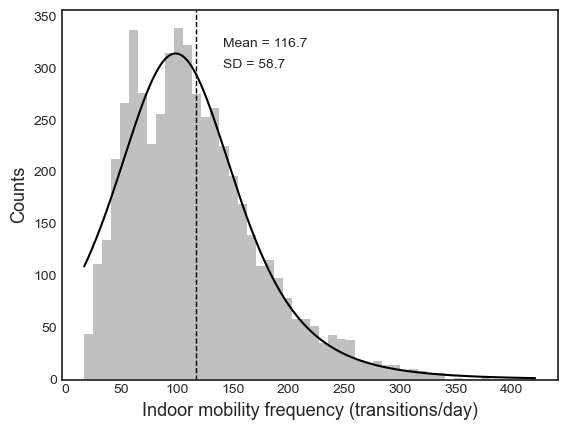

In [130]:
# Plot trip distribution and mean and SD
plt.figure()
plt.style.use('seaborn-v0_8-white')

bin_heights, bin_borders = np.histogram(exclude_17['trip'], bins=50)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2
t_init = models.Moffat1D()
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, bin_centers, bin_heights)
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)


plt.figure()
plt.bar(bin_centers, bin_heights, width=bin_widths, label='histogram',color='silver')
plt.plot(x_interval_for_fit, t(x_interval_for_fit), label='fit', c='k', linewidth=1.5)
plt.xlabel("Indoor mobility frequency (transitions/day)", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.axvline(x=exclude_17['trip'].mean(), color='black', linestyle='--',linewidth=1)
m = 'Mean = ' + str(np.around(exclude_17['trip'].mean(), 1))
m_std = 'SD = ' + str(np.around(exclude_17['trip'].std(), 1))
plt.text(exclude_17['trip'].mean() + 25, 320, m)
plt.text(exclude_17['trip'].mean() + 25, 300, m_std)


In [131]:
# Export

plt.savefig(mobility_path + 'trip_distribution.png', dpi=300)

<Figure size 640x480 with 0 Axes>

Text(0.4893808033754663, 240, 'SD = 0.1')

<Figure size 640x480 with 0 Axes>

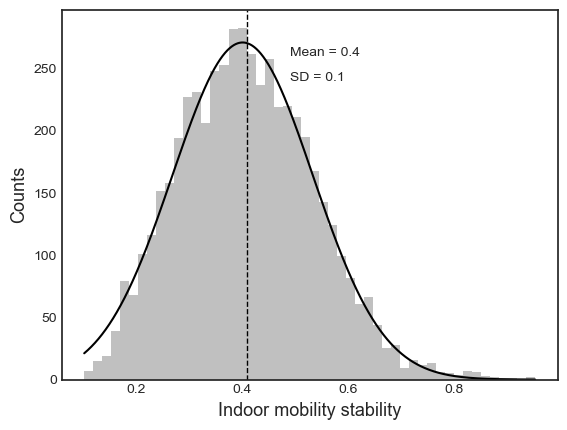

In [132]:
# Plot IS distribution and mean and SD
plt.figure()
plt.style.use('seaborn-v0_8-white')
bin_heights, bin_borders = np.histogram(exclude_17['IS'], bins=50)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2
t_init = models.Gaussian1D()
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, bin_centers, bin_heights)
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

plt.figure()
plt.bar(bin_centers, bin_heights, width=bin_widths, label='histogram',color='silver')
plt.plot(x_interval_for_fit, t(x_interval_for_fit), label='fit', c='k', linewidth=1.5)
plt.xlabel("Indoor mobility stability", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.axvline(x=exclude_17['IS'].mean(), color='k', linestyle='--', linewidth=1)
m = 'Mean = ' + str(np.around(exclude_17['IS'].mean(), 1))
m_std = 'SD = ' + str(np.around(exclude_17['IS'].std(), 1))
plt.text(exclude_17['IS'].mean() + 0.08, 260, m)
plt.text(exclude_17['IS'].mean() + 0.08, 240, m_std)


In [133]:
# Export

plt.savefig(mobility_path + 'IS_distribution.png', dpi=300);


<Figure size 640x480 with 0 Axes>

/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/2794154644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_17['report_date'] = pd.to_datetime(exclude_17['report_date'])
/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/2794154644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_17['date_screen'] = pd.to_datetime(exclude_17['date_screen'])
/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/2794154644.py:4: SettingWithCopyWarning: 
A value i

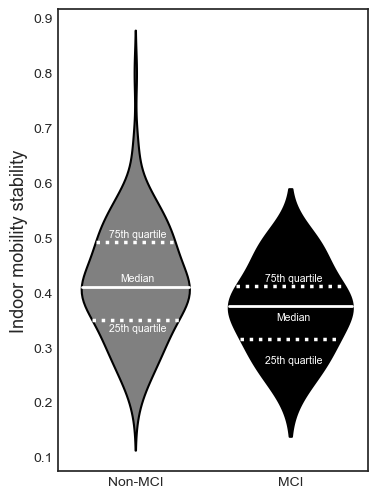

In [144]:
# Violin plot between NC and MCI
exclude_17['report_date'] = pd.to_datetime(exclude_17['report_date'])
exclude_17['date_screen'] = pd.to_datetime(exclude_17['date_screen'])
exclude_17['first_date'] = pd.to_datetime(exclude_17['first_date'])

single = exclude_17.drop(['study','vstHXlivewhere', ], axis =1).groupby('subid').mean().reset_index()

plt.figure(figsize=(4,6), dpi=100)
plt.style.use('seaborn-v0_8-white')
colors = {0:'red', 1:'blue'}
ax = sns.violinplot(data = single, x = 'mci', y = 'IS',inner="quartile", palette=['grey','black'],linestyle=':')
for l in ax.lines:
    l.set_linestyle(':')
    l.set_linewidth(2.5)
    l.set_color('white')
    l.set_alpha(1)
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('white')
    l.set_alpha(1)
ax.set_xticklabels(['Non-MCI','MCI'])
plt.text(-0.17,0.5, '75th quartile',size=7.5, color='w')
plt.text(-0.1,0.42, 'Median',size=7.5, color='w')
plt.text(-0.17,0.33, '25th quartile',size=7.5, color='w')
plt.text(0.84,0.42, '75th quartile',size=7.5, color='w')
plt.text(0.91,0.35, 'Median',size=7.5, color='w')
plt.text(0.84,0.27, '25th quartile',size=7.5, color='w')
plt.xlabel("", fontsize=13)
plt.ylabel("Indoor mobility stability", fontsize=13);


In [145]:
# Export

plt.savefig(mobility_path + 'IS_MCI.png', dpi=300)

<Figure size 640x480 with 0 Axes>

## Sleep and Step Data

### Step data

- Read daily step data for resp cohorts
    - `Watch_Daily_Steps_OHSU-CART_2021_06_18.csv`
    - `Watch_Daily_Steps_RUSH-CART_2021_06_18.csv`
    - `Watch_Daily_Steps_VA-CART_2021_06_21.csv`  

       
- and exclude subjects with steps < 97.  
- Participants with steps < 97 may be disabled (require wheelchair or cane). Hence this data is being excluded.  
- Calculate `w_steps` as a rolling mean of past 7 days.
- Enrich `exclude_17` df with remaining with weekly step count

In [146]:
# dir = "C:/Users/sriya/OneDrive - Michigan State University/BDSA_Summer/Research_Prof_Zhaou/behavior-monitoring/Data/"

# dir = "/Users/unus/Downloads/behavior-monitoring-main/#2 Clinical + watch sensor/Approach 2a/Sleep and Step Data/"

file_OHSU = sleep_step_path + 'Watch_Daily_Steps_OHSU-CART_2021_06_18.csv'
file_RUSH = sleep_step_path + 'Watch_Daily_Steps_RUSH-CART_2021_06_18.csv'
file_VA = sleep_step_path + 'Watch_Daily_Steps_VA-CART_2021_06_21.csv'



In [147]:
watch_step_data = 'watch_step_data.csv'

if not os.path.isfile(dir_2a_path + watch_step_data):
     # Read each CSV file into separate DataFrames
    df_ohsu = pd.read_csv(file_OHSU)
    df_rush = pd.read_csv(file_RUSH)
    df_va = pd.read_csv(file_VA)

    # Merge the DataFrames into a single DataFrame
    merged_data = pd.concat([df_ohsu, df_rush, df_va], ignore_index=True)

    # Write the merged data to a CSV file
    merged_data.to_csv(dir_2a_path + watch_step_data, index=False)

else:
    print(f"The file {watch_step_data} already created. Skipping merging watch data files from OHSU, VA and RUSH")

The file watch_step_data.csv already created. Skipping merging watch data files from OHSU, VA and RUSH


Read consolidated step data for all sources: `watch_step_data.csv`

In [148]:
step_df = pd.read_csv(dir_2a_path + watch_step_data)


In [149]:

# Exclude records with step count per day < 97
step_data = step_df[step_df['steps'] >=97]

# Convert the 'Date' column to datetime type
step_data['date'] = pd.to_datetime(step_data['date'], format ='mixed')

step_data.sort_values(by=['subid', 'date'], inplace=True)

# Group the data by 'subid' and calculate the rolling mean for the past seven days excluding the current value and include it if there are no past values

# step_data['w_steps'] = step_data.groupby('subid')['steps'].rolling(window=8, min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])).reset_index(drop=True)
step_data['w_steps'] = step_data.groupby('subid')['steps'].transform(
    lambda x: x.rolling(window=8, min_periods=1).apply(
        lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1]) 
    )
)

# Create a new DataFrame with 'subid', 'date', and weekly step average 'w_steps' columns
weekly_data = step_data[['subid', 'date', 'w_steps']].copy()


/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/3613739621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_data['date'] = pd.to_datetime(step_data['date'], format ='mixed')
/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/3613739621.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_data.sort_values(by=['subid', 'date'], inplace=True)
/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/3613739621.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [150]:
# Export weekly data
watch_step_weekly_data = 'watch_step_weekly_data.csv'
weekly_data.to_csv(dir_2a_path + watch_step_weekly_data, index=False)

Read step weekly data: `watch_step_weekly_data.csv`

In [151]:
watch_step_weekly_df = pd.read_csv(dir_2a_path + 'watch_step_weekly_data.csv')

watch_step_weekly_df.head()

,subid,date,w_steps
0,1113,2018-06-29,384.0
1,1113,2018-06-30,384.0
2,1113,2018-07-01,619.5
3,1113,2018-07-02,1175.0
4,1113,2018-07-03,1123.5


Read `exclude_17.csv` as clinical_df

In [152]:
clinical_df = pd.read_csv(mobility_path + 'exclude_17.csv')
# clinical_df.rename(columns= {'date_screen':'report_date'},inplace = True)
clinical_df.head()

,subid,homeid,report_date,IV,IS,acro,nadir,amp,trip,P_LVL_1,out_time_week,out_time_total,study,date_screen,age,gender,educ,gait_test_time,gait,adcomcirs_total,mci,n_room,h_sleep,vstHXlivewhere,craftdvr,crafturs,animals,veg,livewhere,dayofyear,daylight,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_INTF,three_sd,out,out_dic,first_date,time,study_dic,study_dic2,race,race_dic
0,279,1175.0,2017-01-09 00:00:00,1.570782,0.560720,0.078642,0.000000,0.078642,115.714286,0.0,6098.869857,42692.089,OLL,2016-01-15 00:00:00,94.9,2.0,14.0,14.3,63.944056,20.0,0.0,4.0,7.0,RETIRE COM,NaN,NaN,NaN,NaN,1.0,9.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,124.058463,8.344178,0,2017-01-09 00:00:00,0,0,0,1.0,1
1,279,1175.0,2017-01-16 00:00:00,1.295816,0.493335,0.078849,0.003504,0.075344,114.142857,1.0,2694.865000,18864.055,OLL,2016-01-15 00:00:00,94.9,2.0,14.0,14.3,63.944056,20.0,0.0,4.0,7.0,RETIRE COM,NaN,NaN,NaN,NaN,1.0,16.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,124.058463,9.915606,0,2017-01-09 00:00:00,7,0,0,1.0,1
2,279,1175.0,2017-01-23 00:00:00,1.475350,0.457168,0.074550,0.000000,0.074550,103.285714,1.0,6960.948143,48726.637,OLL,2016-01-15 00:00:00,94.9,2.0,14.0,14.3,63.944056,20.0,0.0,4.0,7.0,RETIRE COM,NaN,NaN,NaN,NaN,1.0,23.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,124.058463,20.772749,0,2017-01-09 00:00:00,14,0,0,1.0,1
3,279,1175.0,2017-01-30 00:00:00,1.159438,0.411235,0.078582,0.000000,0.078582,96.714286,0.0,10651.604286,74561.230,OLL,2016-01-15 00:00:00,94.9,2.0,14.0,14.3,63.944056,20.0,0.0,4.0,7.0,RETIRE COM,NaN,NaN,NaN,NaN,1.0,30.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,124.058463,27.344178,0,2017-01-09 00:00:00,21,0,0,1.0,1
4,279,1175.0,2017-02-06 00:00:00,1.447498,0.378376,0.074352,0.000000,0.074352,115.666667,0.0,6941.605000,41649.630,OLL,2016-01-15 00:00:00,94.9,2.0,14.0,14.3,63.944056,20.0,0.0,4.0,7.0,RETIRE COM,NaN,NaN,NaN,NaN,1.0,37.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,124.058463,8.391797,0,2017-01-09 00:00:00,28,0,0,1.0,1


In [153]:
# Convert the 'report_date' columns to datetime type
clinical_df['report_date'] = pd.to_datetime(clinical_df['report_date'])
watch_step_weekly_df['date'] = pd.to_datetime(watch_step_weekly_df['date'])

# Merge the dataframes based on 'subid' and 'report_date'
merged_data = pd.merge(clinical_df, watch_step_weekly_df, left_on=['subid', 'report_date'], right_on=['subid', 'date'])


In [154]:
# Export weekly step + demographic file to csv
merged_data.to_csv(dir_2a_path + 'weekly_step_excl_17.csv', index=False)

Read Demo + weekly step data

In [155]:
merged_clinical_watch_df  = pd.read_csv(dir_2a_path + 'weekly_step_excl_17.csv')

In [156]:
# Print the number of records in each dataframe
print("Number of records in exclude_17.csv before merging:", len(clinical_df)) 
print("Number of records in watch_step_data.csv before averaging weekly:", len(step_df))
print("Number of records in watch_step_weekly_data.csv:", len(watch_step_weekly_df))
print("Number of records after merging clinical data and weekly_watch_step_data:", len(merged_clinical_watch_df))

Number of records in exclude_17.csv before merging: 5207
Number of records in watch_step_data.csv before averaging weekly: 115602
Number of records in watch_step_weekly_data.csv: 108797
Number of records after merging clinical data and weekly_watch_step_data: 2592


In [157]:
print("Number of participants before merging:", len(clinical_df['subid'].unique()))
print("Number of participants who have watch steps sensor data:", len(step_df['subid'].unique()))
print("Number of participants after merging clinical data with watch sensor steps data:", len(merged_clinical_watch_df['subid'].unique()))

Number of participants before merging: 144
Number of participants who have watch steps sensor data: 265
Number of participants after merging clinical data with watch sensor steps data: 92


### Sleep data

- Read daily sleep data for resp cohorts and exclude subjects with sleep duration > 3 * std of sleep_duration
    - `Watch_Sleep_Data_OHSU-CART_2021_06_18.csv`
    - `Watch_Sleep_Data_RUSH-CART_2021_06_18.csv`
    - `Watch_Sleep_Data_VA-CART_2021_06_21.csv`
- Normal distribution is being assumed for sleep  
- To utilize `time to bed`, `wake up time` and `sleep duration` as features, convert time `HH:MM:SS` in terms of hours only i.e., float (divide mins by 60, seconds by 3600)
- Normalize by dividing over 24 hrs and multiply by `2*pi` to convert to radians
- Compute weekly avg of these 3 features
- Enrich `exclude_17 + weekly step data` df with these weekly sleep features

In [158]:
# dir = "C:/Users/sriya/OneDrive - Michigan State University/BDSA_Summer/Research_Prof_Zhaou/behavior-monitoring/Data/"
# dir = '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2a/Sleep and Step Data/'

file_OHSU = sleep_step_path + 'Watch_Sleep_Data_OHSU-CART_2021_06_18.csv'
file_RUSH = sleep_step_path + 'Watch_Sleep_Data_RUSH-CART_2021_06_18.csv'
file_VA = sleep_step_path + 'Watch_Sleep_Data_VA-CART_2021_06_21.csv'

In [159]:
watch_sleep_data = 'watch_sleep_data.csv'

if not os.path.isfile(dir_2a_path + watch_sleep_data):
     # Read each CSV file into separate DataFrames
    df_ohsu = pd.read_csv(file_OHSU)
    df_rush = pd.read_csv(file_RUSH)
    df_va = pd.read_csv(file_VA)

    # Merge the DataFrames into a single DataFrame
    merged_data = pd.concat([df_ohsu, df_rush, df_va], ignore_index=True)

    # Write the merged data to a CSV file
    merged_data.to_csv(dir_2a_path + watch_sleep_data, index=False)

else:
    print(f"The file {watch_sleep_data} already created. Skipping merging watch data files from OHSU, VA and RUSH")

The file watch_sleep_data.csv already created. Skipping merging watch data files from OHSU, VA and RUSH


Read consolidated sleep data for all sources: `watch_sleep_data.csv`

In [160]:
sleep_df = pd.read_csv(dir_2a_path + 'watch_sleep_data.csv')
sleep_df.head()

,subid,homeid,study,date,sleep_start,sleep_end,duration_hrs,sleep_period,count
0,1113,1135,OHSU-CART,2018-06-29,2018-06-29 23:06:00-07:00,2018-06-30 06:03:59-07:00,6.966389,6.966389,1
1,1113,1135,OHSU-CART,2018-06-30,2018-06-30 22:47:00-07:00,2018-07-01 06:49:59-07:00,8.049722,8.049722,1
2,1113,1135,OHSU-CART,2018-07-01,2018-07-01 23:18:00-07:00,2018-07-02 05:57:59-07:00,6.666389,6.666389,1
3,1113,1135,OHSU-CART,2018-07-02,2018-07-02 21:45:00-07:00,2018-07-03 05:51:59-07:00,8.116389,8.116389,1
4,1113,1135,OHSU-CART,2018-07-03,2018-07-03 23:23:00-07:00,2018-07-04 05:49:59-07:00,6.449722,6.449722,1


In [161]:
# Convert the 'Date' column to datetime type
sleep_df['date'] = pd.to_datetime(sleep_df['date'])

# @Y: extract local time instead of UTC since avg wakeup time & time to bed were at odd hours

sleep_df['sleep_start_time'] = sleep_df['sleep_start'].astype(str).str.split(' ', n=3, expand = True)[1].str[:-9]
sleep_df['sleep_end_time'] = sleep_df['sleep_end'].astype(str).str.split(' ' , n=3, expand = True)[1].str[:-9]


sleep_df['sleep_start_time'] = pd.to_datetime(sleep_df['sleep_start_time'], format = '%H:%M').dt.time
sleep_df['sleep_end_time'] = pd.to_datetime(sleep_df['sleep_end_time'], format = '%H:%M').dt.time


sleep_df.sort_values(by=['subid', 'date'], inplace=True) 

In [162]:
# Calculate the mean and SD, 3SD for each subid and exclude/drop records for each subid with duration_hrs > 3SD

# Calculate the mean and SD for each 'subid'
mean_sd_df = sleep_df.groupby('subid')['duration_hrs'].agg(['mean', 'std']).reset_index() #

# Compute the threshold for exclusion (3 times the SD)

# @Y: This is because the sensors record duration of people lying in bed (they do not wear smartwatches to bed), so we do not know how long 
# it took them to fall asleep. Hence we exclude people whose sleep duration may be 14 hrs, as it is anomalous and not necessarily reflective 
# of time spent asleep. 'h_sleep' is user recorded duration of sleep (in demographic & sleep survey dataset) but it has a lot of missing data. So cannot be used.

mean_sd_df['threshold_max'] = (mean_sd_df['std'] * 3) + mean_sd_df['mean'] # @Y: updated from upper limit only to 3-sigma rule
mean_sd_df['threshold_min'] = mean_sd_df['mean'] - (mean_sd_df['std'] * 3) 
# Exclude/drop records where 'duration_hrs' exceeds the threshold
sleep_data = sleep_df.merge(mean_sd_df[['subid', 'threshold_max','threshold_min']], on='subid') 
sleep_data = sleep_data[(sleep_data['duration_hrs'] <= sleep_data['threshold_max']) & (sleep_data['duration_hrs'] >= sleep_data['threshold_min'])]

# Display the results
print(sleep_data.head())

# Calculate the number of records dropped for each 'subid'
records_dropped = sleep_df.groupby('subid').size() - sleep_data.groupby('subid').size()

# Display the results
print(records_dropped)

   subid  homeid      study       date                sleep_start  \
0   1113    1135  OHSU-CART 2018-06-29  2018-06-29 23:06:00-07:00   
1   1113    1135  OHSU-CART 2018-06-30  2018-06-30 22:47:00-07:00   
2   1113    1135  OHSU-CART 2018-07-01  2018-07-01 23:18:00-07:00   
3   1113    1135  OHSU-CART 2018-07-02  2018-07-02 21:45:00-07:00   
4   1113    1135  OHSU-CART 2018-07-03  2018-07-03 23:23:00-07:00   

                   sleep_end  duration_hrs  sleep_period  count  \
0  2018-06-30 06:03:59-07:00      6.966389      6.966389      1   
1  2018-07-01 06:49:59-07:00      8.049722      8.049722      1   
2  2018-07-02 05:57:59-07:00      6.666389      6.666389      1   
3  2018-07-03 05:51:59-07:00      8.116389      8.116389      1   
4  2018-07-04 05:49:59-07:00      6.449722      6.449722      1   

  sleep_start_time sleep_end_time  threshold_max  threshold_min  
0         23:06:00       06:03:00     146.766483    -127.758672  
1         22:47:00       06:49:00     146.766483  

In [163]:
sleep_data = sleep_data.query('duration_hrs <=15') # @Y: added to exclude abnormal hours (participants asleep from days to months)

In [164]:
# Create a new column 'time_to_bed', wakeup_time' with the time extracted from the 'sleep_start' column in 2π format

# hours_b = sleep_data['sleep_start'].dt.hour
# minutes_b = sleep_data['sleep_start'].dt.minute
hours_b = sleep_data['sleep_start_time'].apply(lambda x: x.hour)
minutes_b = sleep_data['sleep_start_time'].apply(lambda x: x.minute)
time_in_hours_b = hours_b + minutes_b / 60  # Convert minutes to hours
sleep_data['time_to_bed_2pi'] = time_in_hours_b / 24 * 2 * np.pi

# hours_w = sleep_data['sleep_end'].dt.hour
# minutes_w = sleep_data['sleep_end'].dt.minute # @Y: CORRECTED THIS!
hours_w = sleep_data['sleep_end_time'].apply(lambda x: x.hour)
minutes_w = sleep_data['sleep_end_time'].apply(lambda x: x.minute)
time_in_hours_w = hours_w + minutes_w / 60  # Convert minutes to hours
sleep_data['wakeup_time_2pi'] = time_in_hours_w / 24 * 2 * np.pi

# Group the data by 'subid' and calculate the rolling mean for the past seven days excluding the current value and include it if there are no past values

# sleep_data['w_sleep_duration'] = sleep_data.groupby('subid')['duration_hrs'].rolling(window=8, 
#             min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])).reset_index(drop=True)
# sleep_data['w_time_to_bed_2pi'] = sleep_data.groupby('subid')['time_to_bed_2pi'].rolling(window=8,
#             min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])).reset_index(drop=True)
# sleep_data['w_wakeup_time_2pi'] = sleep_data.groupby('subid')['wakeup_time_2pi'].rolling(window=8, 
#             min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])).reset_index(drop=True)


# @Y - updated this due to "apply" casting NaNs back to the original dataframe post reset index, fixed using transform
sleep_data['w_sleep_duration'] = sleep_data.groupby('subid')['duration_hrs'].transform(
    lambda x: x.rolling(window=8, min_periods=1).apply(
        lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])
    )
)

sleep_data['w_time_to_bed_2pi'] = sleep_data.groupby('subid')['time_to_bed_2pi'].transform(
    lambda x: x.rolling(window=8, min_periods=1).apply(
        lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])
    )
)

sleep_data['w_wakeup_time_2pi'] = sleep_data.groupby('subid')['wakeup_time_2pi'].transform(
    lambda x: x.rolling(window=8, min_periods=1).apply(
        lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])
    )
)

# Create a new DataFrame with 'subid', 'date', and weekly step average 'w_steps' columns
weekly_data = sleep_data[['subid', 'date', 'w_sleep_duration','w_time_to_bed_2pi', 'w_wakeup_time_2pi']].copy()


In [165]:
# Export

watch_sleep_weekly_data = 'watch_sleep_weekly_data.csv'
weekly_data.to_csv(dir_2a_path + watch_sleep_weekly_data, index=False)

Read weekly sleep data: `watch_sleep_weekly_data.csv`

In [166]:
watch_sleep_weekly_df = pd.read_csv(dir_2a_path  + 'watch_sleep_weekly_data.csv')
watch_sleep_weekly_df.head()

,subid,date,w_sleep_duration,w_time_to_bed_2pi,w_wakeup_time_2pi
0,1113,2018-06-29,6.966389,6.047566,1.583886
1,1113,2018-06-30,6.966389,6.047566,1.583886
2,1113,2018-07-01,7.508056,6.006114,1.684243
3,1113,2018-07-02,7.227500,6.037385,1.642064
4,1113,2018-07-03,7.449722,5.951573,1.614430


Read weekly step & demographic data: `weekly_step_excl_17.csv`

In [167]:
clinical_step_df = pd.read_csv(dir_2a_path + 'weekly_step_excl_17.csv')
clinical_step_df.head()

,subid,homeid,report_date,IV,IS,acro,nadir,amp,trip,P_LVL_1,out_time_week,out_time_total,study,date_screen,age,gender,educ,gait_test_time,gait,adcomcirs_total,mci,n_room,h_sleep,vstHXlivewhere,craftdvr,crafturs,animals,veg,livewhere,dayofyear,daylight,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_INTF,three_sd,out,out_dic,first_date,time,study_dic,study_dic2,race,race_dic,date,w_steps
0,1191,922.0,2018-05-07,1.608423,0.313385,0.088483,0.0,0.088483,152.571429,2.0,2723.637143,19065.460,OHSU_CART,2018-04-24 00:00:00,81.8,2.0,16.0,NaN,NaN,19.0,0.0,4.0,8.0,NaN,NaN,NaN,22.0,12.0,0.0,127.0,8.990719,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,223.921991,71.350562,0,2018-05-07 00:00:00,0,0,1,1.0,1,2018-05-07,2509.857143
1,1199,931.0,2018-10-29,1.701299,0.458725,0.090232,0.0,0.090232,120.800000,0.0,8678.159800,43390.799,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,302.0,8.990719,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,189.761858,68.961858,0,2018-10-29 00:00:00,0,0,1,1.0,1,2018-10-29,2117.857143
2,1199,931.0,2018-11-05,1.161411,0.449590,0.094755,0.0,0.094755,118.200000,0.0,12613.457400,63067.287,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,309.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,71.561858,0,2018-10-29 00:00:00,7,0,1,1.0,1,2018-11-05,3641.714286
3,1199,931.0,2018-11-13,1.126454,0.306918,0.140637,0.0,0.140637,130.833333,0.0,12526.860833,75161.165,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,317.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,58.928525,0,2018-10-29 00:00:00,15,0,1,1.0,1,2018-11-13,3119.285714
4,1199,931.0,2018-11-20,1.035292,0.366275,0.139207,0.0,0.139207,113.500000,0.0,20779.399750,83117.599,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,324.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,76.261858,0,2018-10-29 00:00:00,22,0,1,1.0,1,2018-11-20,3561.428571


In [168]:
# Convert the 'report_date' columns to datetime type
clinical_step_df['report_date'] = pd.to_datetime(clinical_step_df['report_date'])
watch_sleep_weekly_df['date'] = pd.to_datetime(watch_sleep_weekly_df['date'])

# Merge the dataframes based on 'subid' and 'report_date'
merged_data = pd.merge(clinical_step_df, watch_sleep_weekly_df, left_on=['subid', 'report_date'], right_on=['subid', 'date'])


In [169]:
# Export Weekly step & sleep data

merged_data.to_csv(dir_2a_path + 'weekly_step_sleep_excl_17.csv' , index=False)

## Additional features calculation

- Read hourly step data from watch raw files. It marks the steps recorded for each hour of the day i.e., 5th Oct, 15 (th hour), 300 steps

- `all_hourly_data` is read from watch raw files and processed in a consolidated file to save time

    - If the cell containing the steps to generating all_hourly_data is deleted. The code can be found in `Additional_features_calculation.ipynb` in `#2 Clinical + watch_sensor` directory i.e., `clinical_path` variable in this script
      
    - There are 2 cells for this code. Use the files in `OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/` to regenerate. 
      
    - If you access the correct location the shape of `all_hourly_data` should be **(2292652, 4)**

- Group data in `all_hourly_data` by date and distribute step counts based on time of day, into 4 groups of 6 hrs each.
- E.g., `midnight_steps` would be steps from 12am to 6am and so on. Store the results in `chunked_df` (which is not used directly later on)
  
- For each subid and date in `exclude_17 + weekly step & sleep data`, gather previous 7 days of data from `all_hourly_data`. Compute acro, nadir, total steps, IV and IS on weekly basis
- Join the calculated results with `exclude_17 + weekly step & sleep data` based on `subid` and `report_date`. Enrich with data from `chunked_df` using a custom fn
- Generate 3 month baseline (input to classifier) by filtering `report_date` lying within 3 months of "first report_date" per participant


### Read weekly step & sleep demo data: 

`weekly_step_sleep_excl_17.csv`

In [170]:
#Load merged clinical_watch_data to add additional features generated
clinical_watch_df = pd.read_csv(dir_2a_path + "weekly_step_sleep_excl_17.csv")
clinical_watch_df.head()

,subid,homeid,report_date,IV,IS,acro,nadir,amp,trip,P_LVL_1,out_time_week,out_time_total,study,date_screen,age,gender,educ,gait_test_time,gait,adcomcirs_total,mci,n_room,h_sleep,vstHXlivewhere,craftdvr,crafturs,animals,veg,livewhere,dayofyear,daylight,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_INTF,three_sd,out,out_dic,first_date,time,study_dic,study_dic2,race,race_dic,date_x,w_steps,date_y,w_sleep_duration,w_time_to_bed_2pi,w_wakeup_time_2pi
0,1191,922.0,2018-05-07,1.608423,0.313385,0.088483,0.0,0.088483,152.571429,2.0,2723.637143,19065.460,OHSU_CART,2018-04-24 00:00:00,81.8,2.0,16.0,NaN,NaN,19.0,0.0,4.0,8.0,NaN,NaN,NaN,22.0,12.0,0.0,127.0,8.990719,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,223.921991,71.350562,0,2018-05-07 00:00:00,0,0,1,1.0,1,2018-05-07,2509.857143,2018-05-07,7.725833,5.806960,1.618793
1,1199,931.0,2019-01-02,1.548991,0.386824,0.119904,0.0,0.119904,83.400000,0.0,21282.097200,106410.486,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,2.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,106.361858,0,2018-10-29 00:00:00,65,0,1,1.0,1,2019-01-02,2320.428571,2019-01-02,7.342540,4.219333,1.674269
2,1199,931.0,2019-01-07,1.314417,0.383387,0.120421,0.0,0.120421,118.750000,0.0,19079.698000,76318.792,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,7.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,71.011858,0,2018-10-29 00:00:00,70,0,1,1.0,1,2019-01-07,3103.714286,2019-01-07,9.011627,5.542667,1.614430
3,1199,931.0,2019-01-14,1.459239,0.417786,0.103887,0.0,0.103887,141.500000,0.0,19821.095000,79284.380,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,14.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,48.261858,0,2018-10-29 00:00:00,77,0,1,1.0,1,2019-01-14,2834.000000,2019-01-14,9.233056,5.672320,1.802052
4,1199,931.0,2019-01-22,1.533966,0.481458,0.081818,0.0,0.081818,113.666667,0.0,23191.102667,69573.308,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,22.0,8.990719,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,76.095191,0,2018-10-29 00:00:00,85,0,1,1.0,1,2019-01-22,3861.285714,2019-01-22,7.733056,5.717200,1.454233


### Process watch raw files to generate hourly data

The below commented cell contains the logic to consolidate watch raw data from each source in : `OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/` and output a single csv `hourly_data_watch_2.csv`

Read `hourly_data_watch_2.csv` as the source to save time in execution (~50 minutes)

**Note: DO NOT DELETE THE CELL BELOW**

In [171]:
# # Converting watch raw data into hourly step data
# # Load the watch raw data
# # CHANGE THE DIRECTORY TO ORIGINAL RAW DATA LOCATION]
# import os
# import pandas as pd

# # List of paths to iterate through
# data_paths = [
#     "/home/sriya/Desktop/OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/OHSU/Watch_Data_Pull_OHSU-CART_2021_06_18/Raw/",
#     "/home/sriya/Desktop/OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/RUSH/Watch_Data_Pull_RUSH-CART_2021_06_18/Raw/",
#     "/home/sriya/Desktop/OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/VA/Watch_Data_Pull_VA-CART_2021_06_21/Raw/"
# ]

# all_hourly_data = pd.DataFrame()

# # Iterate through each data path
# for data_path in data_paths:
#     for filename in os.listdir(data_path):
#             if filename.startswith('Watch_Raw_Data') and 'MIAMI' not in filename:
#                 # Read file
#                 filepath = os.path.join(data_path, filename)
#                 watch_raw_data = pd.read_csv(filepath)

#                 # Determine the timezone based on filename
#                 if 'OHSU' in filename or 'VA' in filename:
#                     timezone = 'America/Los_Angeles'  # Pacific Time Zone
#                 elif 'RUSH' in filename:
#                     timezone = 'America/Chicago'  # Central Daylight Time

#                 # Convert 'stamp' column to datetime with the specified timezone
#                 watch_raw_data['stamp'] = pd.to_datetime(watch_raw_data['stamp'], infer_datetime_format=True, utc=True)
#                 watch_raw_data['stamp'] = watch_raw_data['stamp'].dt.tz_convert(timezone)

#                 # Extract date and hour from 'stamp' column
#                 watch_raw_data['date'] = watch_raw_data['stamp'].dt.date
#                 watch_raw_data['hour'] = watch_raw_data['stamp'].dt.hour

#                 # Group data by 'subid', 'date', and 'hour', and calculate the sum of steps
#                 hourly_data = watch_raw_data.groupby(['subid', 'date', 'hour'])['steps'].sum().reset_index()

#                 # Append the current hourly data to the overall hourly data
#                 # all_hourly_data = all_hourly_data.append(hourly_data)
#                 all_hourly_data = pd.concat([all_hourly_data, hourly_data], ignore_index=True)
                
# # Save the hourly_data to a new CSV file
# hourly_data_file = "hourly_data_watch_2.csv"
# all_hourly_data.to_csv(hourly_data_file, index=False)


In [172]:
all_hourly_data = pd.read_csv(dir_2b_path + "hourly_data_watch_2.csv")
all_hourly_data.head()
print(all_hourly_data.shape)

(2292652, 4)


### Chunked steps

-  chunked steps are generated from hourly data where hourly steps are condensed into a single row
-  each row dissects total steps into four 6-hour subgroups (morning, afternoon, evening, midnight)
-  Steps captured between 12am and 6am of the same day are bundled together as "midnight steps"
-  Similarly steps between 6am and 12pm of the same day are bundled as "morning steps" and so on

In [173]:
# Define time intervals and corresponding column names
time_intervals = [
    ('midnight', 0, 6, 'midnight_steps'),
    ('morning', 6, 12, 'morning_steps'),
    ('afternoon', 12, 18, 'afternoon_steps'),
    ('evening', 18, 24, 'evening_steps')
]

# Create a chunked_data list for the desired columns
chunked_data = []

grouped_data = all_hourly_data.groupby(['subid','date'])

for (subid, date), date_group in grouped_data:
    interval_data = {col_name: 0 for _, _, _, col_name in time_intervals}
    
#     print(f"SubID: {subid}, Date: {date}")
    
    for _, row in date_group.iterrows():
        for interval, start_hour, end_hour, col_name in time_intervals:
            if start_hour <= row['hour'] < end_hour:
                interval_data[col_name] += row['steps']
#                 print(f"    Hour: {row['hour']}, Steps: {row['steps']}, Interval: {interval}")
    
#     print("")
    
    chunked_data.append({
        'subid': date_group['subid'].iloc[0],
        'date': date,
        **interval_data
    })

chunked_df = pd.DataFrame(chunked_data)
print(chunked_df.head())


   subid        date  midnight_steps  morning_steps  afternoon_steps  \
0   1113  2018-06-29               0              0              245   
1   1113  2018-06-30               0            437              182   
2   1113  2018-07-01               0           1363              420   
3   1113  2018-07-02               0            357              503   
4   1113  2018-07-03              64           1604              555   

   evening_steps  
0            139  
1            236  
2            503  
3            109  
4            364  


In [174]:
# Export

chunked_df.to_csv(dir_2b_path + 'chunked_step_counts.csv', index=False)

### Calculate IV, IS for steps

- Iterate over each row of `weekly_step_sleep_excl_17.csv` and retrieve previous 7 days of hourly data (`hourly_data_watch_2.csv`) for date in current row
- With 7 days of data, compute IV and IS for the steps for the week in consideration


In [175]:
# Convert report_date column to datetime
clinical_watch_df['report_date'] = pd.to_datetime(clinical_watch_df['report_date'])
all_hourly_data['date'] = pd.to_datetime(all_hourly_data['date'])

# Initialize lists
calc_features_data = []

# Iterate and get past 7 days relative to report date for each sub id, calculate IV, IS
for index, row in clinical_watch_df.iterrows():
    report_date = row['report_date']
    subid = row['subid']
    
    past_7_days = all_hourly_data[(all_hourly_data['subid'] == subid) &
                              (all_hourly_data['date'] >= report_date - timedelta(days=8)) &
                              (all_hourly_data['date'] < report_date)]

    # Checking if we have more than 1 day's worth of data as calculating IV, IS for one day is not valid scenario
    if len(past_7_days) > 1:
        iv_result = IV_calc(past_7_days, outcome='steps', h_var='hour') 
        is_result = IS_calc(past_7_days, outcome='steps', h_var='hour')
    else:
        iv_result = np.nan
        is_result = np.nan
    
    # Calculate Acro: mean of peak values from a rolling window of 10 hours over the duration of a week
    acro_value = past_7_days['steps'].rolling(10).max().mean()
    
    # Calculate Nadir: mean of min values from a rolling window of 5 hours over the duration of a week
    nadir_value = past_7_days['steps'].rolling(5).min().mean()
    
    # Calculate Amp: difference between Acro and Nadir values
    amp_value = acro_value - nadir_value 
    
    # Calculate Trip: total step count on a daily basis and compute the weekly average
    step_count = past_7_days.groupby('date')['steps'].sum().mean()

    # Append calculated features to list
    calc_features_data.append({'subid': subid, 'report_date': report_date,
                         'IV_steps': iv_result, 'IS_steps': is_result, 
                         'Acro_steps': acro_value, 'Nadir_steps': nadir_value,
                         'Amp_steps': amp_value, 'Total_steps': step_count})

# Create a dataframe from the list
calculated_features_df = pd.DataFrame(calc_features_data)
calculated_features_df['report_date'] = pd.to_datetime(calculated_features_df['report_date'])


In [176]:
# Export
calculated_features_df.to_csv(dir_2b_path + "calculated_features.csv", index=False)

In [177]:
chunked_df.head()

,subid,date,midnight_steps,morning_steps,afternoon_steps,evening_steps
0,1113,2018-06-29,0,0,245,139
1,1113,2018-06-30,0,437,182,236
2,1113,2018-07-01,0,1363,420,503
3,1113,2018-07-02,0,357,503,109
4,1113,2018-07-03,64,1604,555,364


In [178]:
merged1_df = pd.merge(clinical_watch_df, calculated_features_df, left_on=['subid', 'report_date'], right_on=['subid', 'report_date'])
merged1_df.head()

,subid,homeid,report_date,IV,IS,acro,nadir,amp,trip,P_LVL_1,out_time_week,out_time_total,study,date_screen,age,gender,educ,gait_test_time,gait,adcomcirs_total,mci,n_room,h_sleep,vstHXlivewhere,craftdvr,crafturs,animals,veg,livewhere,dayofyear,daylight,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_INTF,three_sd,out,out_dic,first_date,time,study_dic,study_dic2,race,race_dic,date_x,w_steps,date_y,w_sleep_duration,w_time_to_bed_2pi,w_wakeup_time_2pi,IV_steps,IS_steps,Acro_steps,Nadir_steps,Amp_steps,Total_steps
0,1191,922.0,2018-05-07,1.608423,0.313385,0.088483,0.0,0.088483,152.571429,2.0,2723.637143,19065.460,OHSU_CART,2018-04-24 00:00:00,81.8,2.0,16.0,NaN,NaN,19.0,0.0,4.0,8.0,NaN,NaN,NaN,22.0,12.0,0.0,127.0,8.990719,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,223.921991,71.350562,0,2018-05-07 00:00:00,0,0,1,1.0,1,2018-05-07,2509.857143,2018-05-07,7.725833,5.806960,1.618793,1.406888,0.314831,503.471429,6.620690,496.850739,2509.857143
1,1199,931.0,2019-01-02,1.548991,0.386824,0.119904,0.0,0.119904,83.400000,0.0,21282.097200,106410.486,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,2.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,106.361858,0,2018-10-29 00:00:00,65,0,1,1.0,1,2019-01-02,2320.428571,2019-01-02,7.342540,4.219333,1.674269,1.651387,0.266419,834.103093,4.127451,829.975642,2004.375000
2,1199,931.0,2019-01-07,1.314417,0.383387,0.120421,0.0,0.120421,118.750000,0.0,19079.698000,76318.792,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,7.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,71.011858,0,2018-10-29 00:00:00,70,0,1,1.0,1,2019-01-07,3103.714286,2019-01-07,9.011627,5.542667,1.614430,1.727537,0.244335,778.240506,7.907975,770.332531,3240.500000
3,1199,931.0,2019-01-14,1.459239,0.417786,0.103887,0.0,0.103887,141.500000,0.0,19821.095000,79284.380,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,14.0,8.990719,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,48.261858,0,2018-10-29 00:00:00,77,0,1,1.0,1,2019-01-14,2834.000000,2019-01-14,9.233056,5.672320,1.802052,1.661420,0.384013,578.540698,1.514124,577.026573,2606.000000
4,1199,931.0,2019-01-22,1.533966,0.481458,0.081818,0.0,0.081818,113.666667,0.0,23191.102667,69573.308,OHSU_CART,2018-02-22 00:00:00,80.8,1.0,14.0,11.0,83.127273,17.0,0.0,4.0,8.0,NaN,NaN,NaN,21.0,11.0,0.0,22.0,8.990719,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,189.761858,76.095191,0,2018-10-29 00:00:00,85,0,1,1.0,1,2019-01-22,3861.285714,2019-01-22,7.733056,5.717200,1.454233,1.423610,0.195219,803.579545,1.817680,801.761866,3667.375000


In [179]:
clinical_watch_df.shape,merged1_df.shape

((2054, 56), (2054, 62))

In [180]:
# Concatenate weekly average of chunked steps to each row based on date
merged1_df[['midnight_steps', 'morning_steps', 'afternoon_steps', 'evening_steps']] = merged1_df.apply(calculate_weekly_average, axis=1)

# Display the modified merged1_df
print(merged1_df.head())


   subid  homeid report_date        IV        IS      acro  nadir       amp  \
0   1191   922.0  2018-05-07  1.608423  0.313385  0.088483    0.0  0.088483   
1   1199   931.0  2019-01-02  1.548991  0.386824  0.119904    0.0  0.119904   
2   1199   931.0  2019-01-07  1.314417  0.383387  0.120421    0.0  0.120421   
3   1199   931.0  2019-01-14  1.459239  0.417786  0.103887    0.0  0.103887   
4   1199   931.0  2019-01-22  1.533966  0.481458  0.081818    0.0  0.081818   

         trip  P_LVL_1  out_time_week  out_time_total      study  \
0  152.571429      2.0    2723.637143       19065.460  OHSU_CART   
1   83.400000      0.0   21282.097200      106410.486  OHSU_CART   
2  118.750000      0.0   19079.698000       76318.792  OHSU_CART   
3  141.500000      0.0   19821.095000       79284.380  OHSU_CART   
4  113.666667      0.0   23191.102667       69573.308  OHSU_CART   

           date_screen   age  gender  educ  gait_test_time       gait  \
0  2018-04-24 00:00:00  81.8     2.0  16.0 

In [181]:
# Export

merged1_df.to_csv(dir_2b_path + "merged_addnl_features.csv", index=False)

In [182]:
# Get first 3 months of data for prediction

# Sort the dataframe by 'subid' and 'report_date'
clinical_df = merged1_df.sort_values(['subid', 'report_date'])

# Group the data by 'subid' and select the first report date for each group
first_report_dates = clinical_df.groupby('subid')['report_date'].first()

# Calculate the end date by adding 3 months to the first report date
end_dates = first_report_dates + pd.DateOffset(months=3)

# Filter the data based on the first 3-month period
filtered_data = clinical_df[clinical_df.apply(lambda row: row['report_date'] >= first_report_dates[row['subid']] and row['report_date'] <= end_dates[row['subid']], axis=1)]


In [183]:
# Export

filtered_data.to_csv(approach2_path + 'first_3_month_period.csv', index=False)

## Predictions

Classify subject as MCI or Normal cognitive status using demographic, survey, weekly step & sleep data within 3 month baseline period.  
Read file: `first_3_month_period.csv`

- For training, the subids is split 70/30 between training and testing as there is more than 1 record per subject
    - This is achieved by splitting subids for each class, MCI and normal cognition, for train and test sets for consistency in split
- Splitting records directly would result in a double dipping effect and muddle results as the records for the same participant could appear in training and test sets
- Once subids are split, we must account for variation in number of data points for each participant.
    - This is achieved by computing the ratio of records between train and test set with both classes combined
    - If the ratio lies between 60/40 and 80/20, training and classification is allowed
- To assess feature importance for each classifier, SHAP analysis can be performed by enabling the `shap_flag` in each model training cell. It is disabled by default
- For benchmark, we only use age & gender as the features and any duplicates are excluded (1 record per subject)

In [184]:
data = pd.read_csv(approach2_path + "first_3_month_period.csv")

In [185]:
# Summary statistics
data.describe()

,subid,homeid,IV,IS,acro,nadir,amp,trip,P_LVL_1,out_time_week,out_time_total,age,gender,educ,gait_test_time,gait,adcomcirs_total,mci,n_room,h_sleep,vstHXlivewhere,craftdvr,crafturs,animals,veg,livewhere,dayofyear,daylight,MED,FALL,ACDT,HCRU,HTH,SPACE,ASST,MOOD_BLUE,MOOD_LONV,P_INTF,three_sd,out,out_dic,time,study_dic,study_dic2,race,race_dic,w_steps,w_sleep_duration,w_time_to_bed_2pi,w_wakeup_time_2pi,IV_steps,IS_steps,Acro_steps,Nadir_steps,Amp_steps,Total_steps,midnight_steps,morning_steps,afternoon_steps,evening_steps
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,654.000000,659.000000,659.000000,659.000000,659.00000,474.000000,649.000000,467.000000,659.000000,659.000000,494.000000,0.0,394.000000,569.000000,636.000000,636.000000,659.0,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.0,659.000000,659.000000,659.000000,659.000000,659.000000,659.0,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,655.000000,655.000000,654.000000,654.000000,654.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,1773.377845,1553.779970,1.409501,0.380164,0.100572,0.000664,0.099908,123.969796,2.421851,11049.790529,65516.222992,72.945344,1.503794,15.38695,11.374093,77.101149,21.678801,0.176024,5.655539,7.102227,NaN,15.908629,13.500879,19.800314,15.572327,0.0,192.977238,9.081922,1.907436,1.986343,1.980273,1.980273,1.880121,1.924127,2.0,1.937785,1.911988,1.831563,197.259030,73.289235,0.0,53.650986,0.270106,0.729894,1.270106,0.729894,3045.511908,7.453245,3.439492,1.980116,1.363681,0.333135,578.367291,19.580234,558.787057,2974.453208,56.650362,1175.281356,1281.068610,461.452881
std,216.989841,215.956862,0.325468,0.127754,0.026626,0.001686,0.027046,63.545475,2.437276,8444.350395,55095.083631,6.113162,0.500365,2.56417,3.801658,23.040298,3.721478,0.381130,2.251243,1.215675,NaN,5.971244,3.996973,5.740811,4.983069,0.0,104.765541,0.150039,0.290041,0.116151,0.139166,0.139166,0.325066,0.264995,0.0,0.241730,0.283528,1.084782,93.755089,52.401031,0.0,47.857941,0.444352,0.444352,0.444352,0.444352,2404.589271,1.451283,1.688342,0.465681,0.296423,0.148410,456.246804,22.200310,445.423342,2343.231815,92.365981,1214.301415,1082.251391,439.294767
min,1191.000000,922.000000,0.400518,0.125810,0.058333,0.000000,0.050725,23.571429,0.000000,0.000000,0.000000,62.400000,1.000000,10.00000,7.100000,28.856805,15.000000,0.000000,4.000000,3.000000,NaN,5.000000,6.000000,8.000000,4.000000,0.0,1.000000,8.990719,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0,1.000000,1.000000,1.000000,50.660676,0.810953,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,209.000000,2.810833,0.125913,0.583439,0.619619,0.102552,25.452830,0.000000,25.300391,69.000000,0.000000,0.000000,0.000000,0.000000
25%,1695.000000,1497.500000,1.194666,0.285154,0.084323,0.000000,0.083606,75.700000,0.000000,4263.706690,22120.861000,68.600000,1.000000,14.00000,9.200000,56.055172,20.000000,0.000000,4.000000,6.000000,NaN,12.000000,11.000000,16.000000,11.000000,0.0,96.500000,8.990719,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.000000,2.000000,1.000000,125.275543,34.033573,0.0,20.000000,0.000000,0.000000,1.000000,0.000000,1068.428571,6.447302,1.990922,1.653076,1.150881,0.249111,216.864478,4.765714,209.462260,1074.812500,7.450000,328.325000,433.375000,153.187500
50%,1753.000000,1564.000000,1.407980,0.371239,0.094604,0.000000,0.094505,117.800000,2.000000,9639.067071,53973.469000,72.400000,2.000000,16.00000,10.000000,76.200000,22.000000,0.000000,5.000000,7.000000,NaN,16.000000,13.000000,20.000000,15.000000,0.0,217.000000,8.990719,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.000000,2.000000,1.000000,180.319466,57.227038,0.0,48.000000,0.000000,1.000000,1.000000,1.000000,2523.571429,7.575913,3.576055,1.956950,1.386155,0.308109,468.331647,12.209787,451.747856,2491.375000,25.125000,721.250000,1052.625000,296.250000
75%,1937.000000,1

In [186]:
# Check for missing values
print(f"Columns with missing values:\n{data.columns[data.isna().any()].tolist()}\n")

# Drop rows without mci(target) value
data.dropna(subset=['mci'], inplace=True)

# Check distribution of dataset
print(f"Distribution by no. of records: {data['mci'].value_counts()}.\n\nDistribution by no. of subjects: {data.groupby('subid').first()['mci'].value_counts()}\n")


Columns with missing values:
['out_time_week', 'date_screen', 'gait_test_time', 'gait', 'adcomcirs_total', 'h_sleep', 'vstHXlivewhere', 'craftdvr', 'crafturs', 'animals', 'veg', 'IV_steps', 'IS_steps', 'Acro_steps', 'Nadir_steps', 'Amp_steps', 'Total_steps', 'midnight_steps', 'morning_steps', 'afternoon_steps', 'evening_steps']

Distribution by no. of records: mci
0.0    543
1.0    116
Name: count, dtype: int64.

Distribution by no. of subjects: mci
0.0    71
1.0    16
Name: count, dtype: int64



In [187]:

#compute percentage of missing data in all columns
missing_percentages = (data.isnull().sum()/len(data))*100

missing_percentages.to_frame(name = '%')

,%
subid,0.000000
homeid,0.000000
report_date,0.000000
IV,0.000000
IS,0.000000
acro,0.000000
nadir,0.000000
amp,0.000000
trip,0.000000
P_LVL_1,0.000000


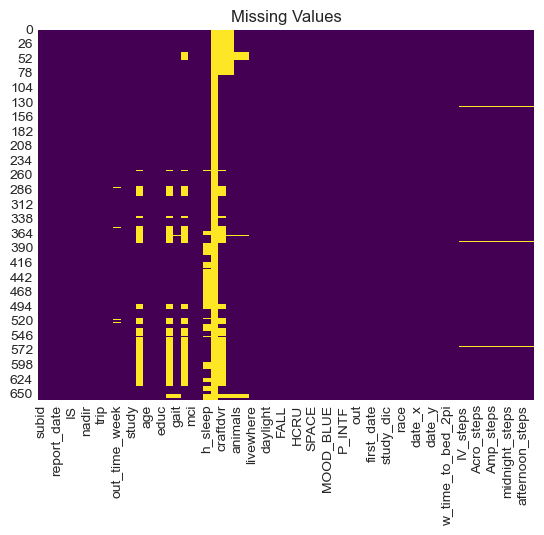

In [188]:
# Visualize missing values
sns.heatmap(data.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values');

In [189]:
req_columns = ['subid',
               'IV','IS','nadir','amp', 'acro', 'trip','P_LVL_1', 'P_INTF', 'out_time_week','out_time_total',
               # 'MED','FALL','ACDT','HCRU','HTH','SPACE', # exclude rare life events
               'MOOD_BLUE','MOOD_LONV',
               'age','gender','educ',
               # 'adcomcirs_total','craftdvr','crafturs', # exclude scores
               # 'n_room', 
               'daylight', # control for geography
               'w_sleep_duration', 'w_time_to_bed_2pi', 'w_wakeup_time_2pi',
               'w_steps','IV_steps','IS_steps','Acro_steps','Nadir_steps', 'Amp_steps',
               'midnight_steps', 'morning_steps', 'afternoon_steps', 'evening_steps','Total_steps',
               'mci']


df = data[req_columns]
df.head()

,subid,IV,IS,nadir,amp,acro,trip,P_LVL_1,P_INTF,out_time_week,out_time_total,MOOD_BLUE,MOOD_LONV,age,gender,educ,daylight,w_sleep_duration,w_time_to_bed_2pi,w_wakeup_time_2pi,w_steps,IV_steps,IS_steps,Acro_steps,Nadir_steps,Amp_steps,midnight_steps,morning_steps,afternoon_steps,evening_steps,Total_steps,mci
0,1191,1.608423,0.313385,0.0,0.088483,0.088483,152.571429,2.0,3.0,2723.637143,19065.460,2.0,2.0,81.8,2.0,16.0,8.990719,7.725833,5.806960,1.618793,2509.857143,1.406888,0.314831,503.471429,6.620690,496.850739,1.714286,685.714286,1463.000,359.428571,2509.857143,0.0
1,1199,1.548991,0.386824,0.0,0.119904,0.119904,83.400000,0.0,1.0,21282.097200,106410.486,2.0,2.0,80.8,1.0,14.0,8.990719,7.342540,4.219333,1.674269,2320.428571,1.651387,0.266419,834.103093,4.127451,829.975642,18.250000,794.375000,1030.250,161.500000,2004.375000,0.0
2,1199,1.314417,0.383387,0.0,0.120421,0.120421,118.750000,0.0,1.0,19079.698000,76318.792,2.0,2.0,80.8,1.0,14.0,8.990719,9.011627,5.542667,1.614430,3103.714286,1.727537,0.244335,778.240506,7.907975,770.332531,65.000000,1428.375000,1628.500,118.625000,3240.500000,0.0
3,1199,1.459239,0.417786,0.0,0.103887,0.103887,141.500000,0.0,1.0,19821.095000,79284.380,2.0,2.0,80.8,1.0,14.0,8.990719,9.233056,5.672320,1.802052,2834.000000,1.661420,0.384013,578.540698,1.514124,577.026573,6.750000,631.125000,1671.875,296.250000,2606.000000,0.0
4,1199,1.533966,0.481458,0.0,0.081818,0.081818,113.666667,0.0,1.0,23191.102667,69573.308,2.0,2.0,80.8,1.0,14.0,8.990719,7.733056,5.717200,1.454233,3861.285714,1.423610,0.195219,803.579545,1.817680,801.761866,29.625000,1323.375000,1766.125,548.250000,3667.375000,0.0


In [190]:
#Get columns with missing values
missing_data_col = df.columns[df.isnull().any()]
print(f"Features with missing data from selected features:\n{missing_data_col.tolist()}")

Features with missing data from selected features:
['out_time_week', 'IV_steps', 'IS_steps', 'Acro_steps', 'Nadir_steps', 'Amp_steps', 'midnight_steps', 'morning_steps', 'afternoon_steps', 'evening_steps', 'Total_steps']


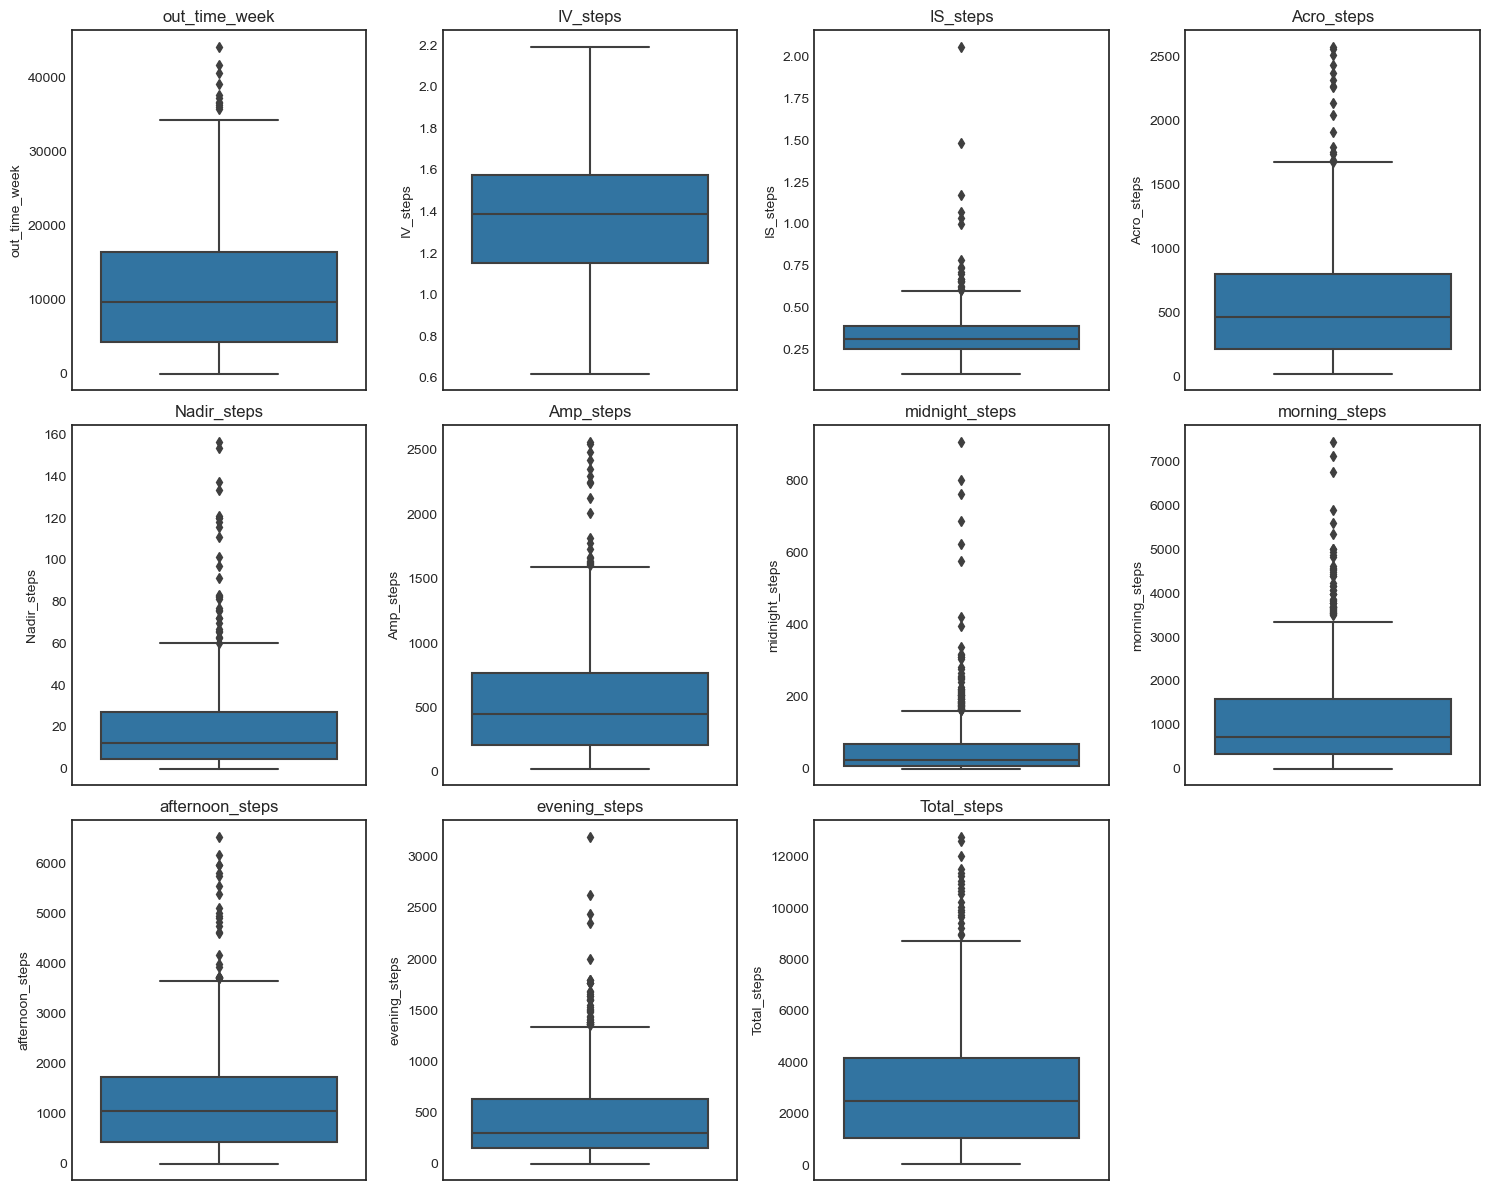

In [191]:
# Visualize outliers

num_cols = len(missing_data_col)

# Calculate the number of rows and columns for the subplot grid
num_rows = (num_cols + 3) // 4  # Round up to the nearest integer
num_cols = min(num_cols, 4)

# Create a box plot
plt.figure(figsize=(15, 4 * num_rows))  # Adjust the figure size based on the number of rows

# Iterate over each column and plot the box plot
for i, column in enumerate(missing_data_col):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=data, y=column)
    plt.title(column)

plt.tight_layout()

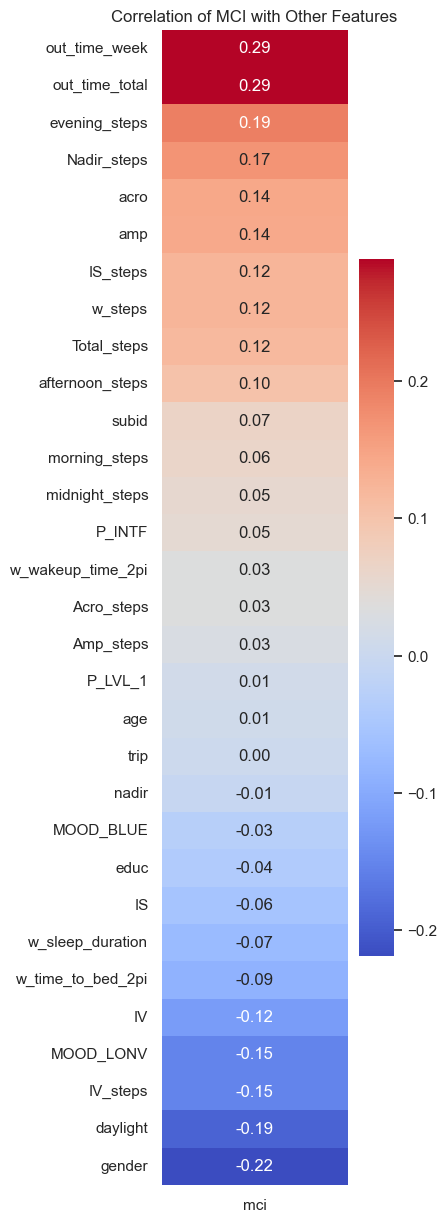

In [192]:
# Correlation plot for MCI with other features
df.loc[:,'mci'] = df.loc[:,'mci'].astype('int64')
df.loc[:,'gender'] = df.loc[:,'gender'].astype('int64')

cor_mci = df.corr()['mci'].drop('mci').sort_values(ascending=False)

sns.set(font_scale=1)
plt.figure(figsize=(3,15))
sns.heatmap(cor_mci.to_frame(), annot=True, fmt=".2f", cmap="coolwarm")

plt.title("Correlation of MCI with Other Features");

In [193]:

corr_dict = df.corr()['mci'].drop('mci').sort_values(ascending=False).to_dict()


In [194]:
# corr_cols_final = corr_cols
corr_cols = list(df.corr()['mci'].drop('mci').sort_values(ascending=False).to_dict().keys())
corr_cols



['out_time_week',
 'out_time_total',
 'evening_steps',
 'Nadir_steps',
 'acro',
 'amp',
 'IS_steps',
 'w_steps',
 'Total_steps',
 'afternoon_steps',
 'subid',
 'morning_steps',
 'midnight_steps',
 'P_INTF',
 'w_wakeup_time_2pi',
 'Acro_steps',
 'Amp_steps',
 'P_LVL_1',
 'age',
 'trip',
 'nadir',
 'MOOD_BLUE',
 'educ',
 'IS',
 'w_sleep_duration',
 'w_time_to_bed_2pi',
 'IV',
 'MOOD_LONV',
 'IV_steps',
 'daylight',
 'gender']

In [195]:
df = df.ffill().bfill()
final_df = df

### Benchmark (age & gender)

In [196]:
shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df[['subid', 'age','gender', 'mci']].drop_duplicates(subset = 'subid', keep = 'first').drop(['subid','mci'], axis =1)
y = final_df[['subid', 'age','gender', 'mci']].drop_duplicates(subset = 'subid', keep = 'first')['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):
    
    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 
        
    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df.loc[final_df['subid'].isin(train_subids), ['subid', 'age','gender', 'mci']]
    test_data = final_df.loc[final_df['subid'].isin(test_subids),  ['subid', 'age','gender', 'mci']]

    ratio = len(train_data) / len(test_data)

    
    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, int_cols, 'int64')
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        
        # update_dtypes(X_test_imputed_df, int_cols, 'int64')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        if train_only: # for encoded columns that exist in training set alone replicate in test
        
            for col in train_only:
                X_test_final[col] = 0
                copy_type = type(X_train_final.loc[0,col])
                X_test_final[col] = X_test_final[col].astype(copy_type)  # align dtypes
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        
        elif test_only: # repeat for one-hot encoded columns exclusive to test 
        
            for col in train_only:
                X_train_final[col] = 0
                copy_type = type(X_test_final.loc[0,col])
                X_train_final[col] = X_train_final[col].astype(copy_type)
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        # X_train_final = study_trend_and_add_features(X_train_final)
        # X_test_final = study_trend_and_add_features(X_test_final)
        
        # Initialize classifiers
        decision_tree = DecisionTreeClassifier( random_state=i)
        svm = SVC(C=0.1, kernel='linear', gamma =1,  random_state=i)
        random_forest = RandomForestClassifier(random_state=i)
        LR = LogisticRegression(solver='liblinear',random_state=i, max_iter = 3000, C=100, penalty = 'l2')
        #     LR = LogisticRegression(C=100, max_iter=3000, random_state=i,solver='newton-cholesky')
        xgb = XGBClassifier(random_state = i, enable_categorical=True)
        
        #Train classifiers on training data
        decision_tree.fit(X_train_final, y_train)
        svm.fit(X_train_final, y_train)
        random_forest.fit(X_train_final, y_train)
        LR.fit(X_train_final, y_train)
        xgb.fit(X_train_final, y_train)
        
        # Make predictions on the testing data
        dt_pred = decision_tree.predict(X_test_final)
        svm_pred = svm.predict(X_test_final)
        rf_pred = random_forest.predict(X_test_final)
        lr_pred = LR.predict(X_test_final)
        xgb_pred = xgb.predict(X_test_final)
        
        #calculate accuracy, precision, recall, f1 and store in list
        dt_accuracy.append(accuracy_score(y_test, dt_pred))
        svm_accuracy.append(accuracy_score(y_test, svm_pred))
        rf_accuracy.append(accuracy_score(y_test, rf_pred))
        lr_accuracy.append(accuracy_score(y_test, lr_pred))
        xgb_accuracy.append(accuracy_score(y_test, xgb_pred))
        
        dt_precision.append(precision_score(y_test, dt_pred,zero_division =0))
        svm_precision.append(precision_score(y_test, svm_pred,zero_division = 0))
        rf_precision.append(precision_score(y_test, rf_pred,zero_division = 0))
        lr_precision.append(precision_score(y_test, lr_pred,zero_division = 0))
        xgb_precision.append(precision_score(y_test, xgb_pred,zero_division = 0))
        
        dt_recall.append(recall_score(y_test, dt_pred))
        svm_recall.append(recall_score(y_test, svm_pred))
        rf_recall.append(recall_score(y_test, rf_pred))
        lr_recall.append(recall_score(y_test, lr_pred))
        xgb_recall.append(recall_score(y_test, xgb_pred))
        
        dt_f1.append(f1_score(y_test, dt_pred))
        svm_f1.append(f1_score(y_test, svm_pred))
        rf_f1.append(f1_score(y_test, rf_pred))
        lr_f1.append(f1_score(y_test, lr_pred))
        xgb_f1.append(f1_score(y_test, xgb_pred))
        
        dt_auc.append(roc_auc_score(y_test, decision_tree.predict_proba(X_test_final)[:,1]))
        svm_auc.append(roc_auc_score(y_test, svm.decision_function(X_test_final)))
        rf_auc.append(roc_auc_score(y_test, random_forest.predict_proba(X_test_final)[:,1]))
        lr_auc.append(roc_auc_score(y_test, LR.predict_proba(X_test_final)[:,1]))
        xgb_auc.append(roc_auc_score(y_test, xgb.predict_proba(X_test_final)[:,1]))

        if shap_flag:
   
            dt_explainer = shap.TreeExplainer(decision_tree)
            svm_explainer = shap.KernelExplainer(svm.predict, X_train_final) 
            rf_explainer = shap.TreeExplainer(random_forest)
            lr_explainer = shap.LinearExplainer(LR, X_train_final)
            xgb_explainer = shap.TreeExplainer(xgb)
    
    
            # Generate SHAP values for each classifier
            dt_shap_values = dt_explainer.shap_values(X_test_final)
            svm_shap_values = svm_explainer.shap_values(X_test_final)
            rf_shap_values = rf_explainer.shap_values(X_test_final)
            lr_shap_values = lr_explainer.shap_values(X_test_final)
            xgb_shap_values = xgb_explainer.shap_values(X_test_final)
            
            # Append SHAP values to lists
            all_dt_shap_values.append(dt_shap_values)
            all_svm_shap_values.append(svm_shap_values)
            all_rf_shap_values.append(rf_shap_values)
            all_lr_shap_values.append(lr_shap_values)
            all_xgb_shap_values.append(xgb_shap_values)

    
if shap_flag:    
    max_shape = max(arr.shape for arr in all_dt_shap_values)
    
    ## shap values for DT and RF are of shape (_, 2,2) whereas for the others the shape is (_,2). This is because the values are repeating within
    # each row of subarray of shape (2,2). The loops to compute the "new" values simply take the first value from each row to reshape 
    new_dt_shap_values = []
    new_rf_shap_values = []
    
    for i in range(len(all_dt_shap_values)):
        arr = all_dt_shap_values[i]
        l = [np.array([a[j,0] for j in range(arr.shape[1])]) for a in abs(arr)]
        new_dt_shap_values.append(np.asarray(l))
    
    
    for i in range(len(all_rf_shap_values)):
        arr = all_rf_shap_values[i]
        l = [np.array([a[j,0] for j in range(arr.shape[1])]) for a in abs(arr)]
        new_rf_shap_values.append(np.asarray(l))
            
    for arr in new_dt_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_dt_shap_values_padded.append(padded_arr)
    
    
    for arr in new_rf_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_rf_shap_values_padded.append(padded_arr)
    
    for arr in all_svm_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_svm_shap_values_padded.append(padded_arr)
    
    for arr in all_lr_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_lr_shap_values_padded.append(padded_arr)
    
    for arr in all_xgb_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_xgb_shap_values_padded.append(padded_arr)
    
    
    # Convert the list of padded sub-arrays to a NumPy array
    all_dt_shap_values_fixed = np.array(all_dt_shap_values_padded)
    all_svm_shap_values_fixed = np.array(all_svm_shap_values_padded)
    all_rf_shap_values_fixed = np.array(all_rf_shap_values_padded)
    all_lr_shap_values_fixed = np.array(all_lr_shap_values_padded)
    all_xgb_shap_values_fixed = np.array(all_xgb_shap_values_padded)
    
    # Calculate mean SHAP values across iterations
    mean_dt_shap_values = np.mean(all_dt_shap_values_fixed, axis=0)
    mean_svm_shap_values = np.mean(all_svm_shap_values_fixed, axis=0)
    mean_rf_shap_values = np.mean(all_rf_shap_values_fixed, axis=0)
    mean_lr_shap_values = np.mean(all_lr_shap_values_fixed, axis=0)
    mean_xgb_shap_values = np.mean(all_xgb_shap_values_fixed, axis=0)
    
# Print mean and variance of evaluation metrics for each model
print(f'Accuracy statistics for {len(y)} records:')
print("Decision Tree:")
print(f"  - Mean accuracy: {np.mean(dt_accuracy):.4f}, Variance: {np.var(dt_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(dt_precision):.4f}, Variance: {np.var(dt_precision):.4f}")
print(f"  - Mean recall: {np.mean(dt_recall):.4f}, Variance: {np.var(dt_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(dt_f1):.4f}, Variance: {np.var(dt_f1):.4f}")
print(f"  - AUC: {np.mean(dt_auc):.3f}")
print("\nSVM:")
print(f"  - Mean accuracy: {np.mean(svm_accuracy):.4f}, Variance: {np.var(svm_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(svm_precision):.4f}, Variance: {np.var(svm_precision):.4f}")
print(f"  - Mean recall: {np.mean(svm_recall):.4f}, Variance: {np.var(svm_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(svm_f1):.4f}, Variance: {np.var(svm_f1):.4f}")
print(f"  - AUC: {np.mean(svm_auc):.3f}")
print("\nRandom Forest:")
print(f"  - Mean accuracy: {np.mean(rf_accuracy):.4f}, Variance: {np.var(rf_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(rf_precision):.4f}, Variance: {np.var(rf_precision):.4f}")
print(f"  - Mean recall: {np.mean(rf_recall):.4f}, Variance: {np.var(rf_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(rf_f1):.4f}, Variance: {np.var(rf_f1):.4f}")
print(f"  - AUC: {np.mean(rf_auc):.3f}")
print("\nLogistic Regression:")
print(f"  - Mean accuracy: {np.mean(lr_accuracy):.4f}, Variance: {np.var(lr_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(lr_precision):.4f}, Variance: {np.var(lr_precision):.4f}")
print(f"  - Mean recall: {np.mean(lr_recall):.4f}, Variance: {np.var(lr_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(lr_f1):.4f}, Variance: {np.var(lr_f1):.4f}")
print(f"  - AUC: {np.mean(lr_auc):.3f}")
print("\nXGBoost:")
print(f"  - Mean accuracy: {np.mean(xgb_accuracy):.4f}, Variance: {np.var(xgb_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(xgb_precision):.4f}, Variance: {np.var(xgb_precision):.4f}")
print(f"  - Mean recall: {np.mean(xgb_recall):.4f}, Variance: {np.var(xgb_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(xgb_f1):.4f}, Variance: {np.var(xgb_f1):.4f}")
print(f"  - AUC: {np.mean(xgb_auc):.3f}")



Accuracy statistics for 87 records:
Decision Tree:
  - Mean accuracy: 0.7615, Variance: 0.0046
  - Mean precision: 0.3090, Variance: 0.0502
  - Mean recall: 0.2766, Variance: 0.0438
  - Mean F1-score: 0.2787, Variance: 0.0382
  - AUC: 0.564

SVM:
  - Mean accuracy: 0.8203, Variance: 0.0011
  - Mean precision: 0.0000, Variance: 0.0000
  - Mean recall: 0.0000, Variance: 0.0000
  - Mean F1-score: 0.0000, Variance: 0.0000
  - AUC: 0.574

Random Forest:
  - Mean accuracy: 0.7583, Variance: 0.0050
  - Mean precision: 0.3069, Variance: 0.0478
  - Mean recall: 0.2820, Variance: 0.0431
  - Mean F1-score: 0.2804, Variance: 0.0368
  - AUC: 0.554

Logistic Regression:
  - Mean accuracy: 0.8159, Variance: 0.0018
  - Mean precision: 0.0125, Variance: 0.0102
  - Mean recall: 0.0052, Variance: 0.0011
  - Mean F1-score: 0.0062, Variance: 0.0017
  - AUC: 0.572

XGBoost:
  - Mean accuracy: 0.6944, Variance: 0.0123
  - Mean precision: 0.2572, Variance: 0.0533
  - Mean recall: 0.2965, Variance: 0.0436
  - 

              precision    recall  f1-score   support

     Non MCI       0.84      0.73      0.78       151
         MCI       0.20      0.32      0.24        31

    accuracy                           0.66       182
   macro avg       0.52      0.53      0.51       182
weighted avg       0.73      0.66      0.69       182

              precision    recall  f1-score   support

     Non MCI       0.83      1.00      0.91       151
         MCI       0.00      0.00      0.00        31

    accuracy                           0.83       182
   macro avg       0.41      0.50      0.45       182
weighted avg       0.69      0.83      0.75       182

              precision    recall  f1-score   support

     Non MCI       0.84      0.73      0.78       151
         MCI       0.20      0.32      0.24        31

    accuracy                           0.66       182
   macro avg       0.52      0.53      0.51       182
weighted avg       0.73      0.66      0.69       182

              preci

/Users/unus/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/unus/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/unus/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/unus/miniconda3/lib/p

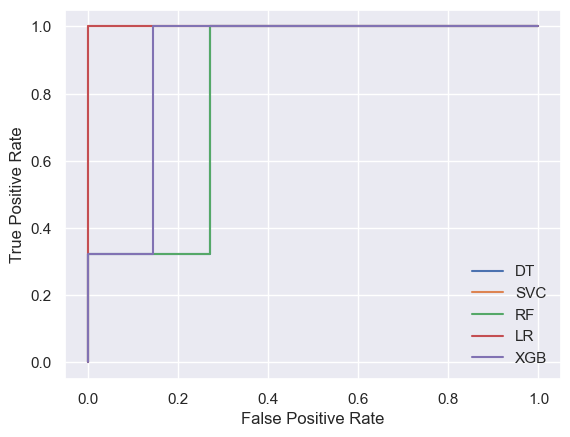

In [197]:
class_report_plot(y_test, dt_pred)
class_report_plot(y_test, svm_pred)
class_report_plot(y_test, rf_pred)
class_report_plot(y_test, lr_pred)
class_report_plot(y_test, xgb_pred)

### Performance w/ full feature set 

In [198]:
shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df.drop(['subid','mci'], axis =1)
y = final_df['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):

    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 

    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df[final_df['subid'].isin(train_subids)]
    test_data = final_df[final_df['subid'].isin(test_subids)]

    ratio = len(train_data) / len(test_data)
    
    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        if train_only: # for encoded columns that exist in training set alone replicate in test
        
            for col in train_only:
                X_test_final[col] = 0
                copy_type = type(X_train_final.loc[0,col])
                X_test_final[col] = X_test_final[col].astype(copy_type)  # align dtypes
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        
        elif test_only: # repeat for one-hot encoded columns exclusive to test 
        
            for col in train_only:
                X_train_final[col] = 0
                copy_type = type(X_test_final.loc[0,col])
                X_train_final[col] = X_train_final[col].astype(copy_type)
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        # X_train_final = study_trend_and_add_features(X_train_final)
        # X_test_final = study_trend_and_add_features(X_test_final)
        
        # Initialize classifiers
        decision_tree = DecisionTreeClassifier( random_state=i)
        svm = SVC(C=0.1, kernel='linear', gamma =1,  random_state=i)
        random_forest = RandomForestClassifier(random_state=i)
        LR = LogisticRegression(solver='liblinear',random_state=i, max_iter = 3000, C=100, penalty = 'l2')
        #     LR = LogisticRegression(C=100, max_iter=3000, random_state=i,solver='newton-cholesky')
        xgb = XGBClassifier(random_state = i, enable_categorical=True)
        
        #Train classifiers on training data
        decision_tree.fit(X_train_final, y_train)
        svm.fit(X_train_final, y_train)
        random_forest.fit(X_train_final, y_train)
        LR.fit(X_train_final, y_train)
        xgb.fit(X_train_final, y_train)
        
        # Make predictions on the testing data
        dt_pred = decision_tree.predict(X_test_final)
        svm_pred = svm.predict(X_test_final)
        rf_pred = random_forest.predict(X_test_final)
        lr_pred = LR.predict(X_test_final)
        xgb_pred = xgb.predict(X_test_final)
        
        #calculate accuracy, precision, recall, f1 and store in list
        dt_accuracy.append(accuracy_score(y_test, dt_pred))
        svm_accuracy.append(accuracy_score(y_test, svm_pred))
        rf_accuracy.append(accuracy_score(y_test, rf_pred))
        lr_accuracy.append(accuracy_score(y_test, lr_pred))
        xgb_accuracy.append(accuracy_score(y_test, xgb_pred))
        
        dt_precision.append(precision_score(y_test, dt_pred,zero_division =0))
        svm_precision.append(precision_score(y_test, svm_pred,zero_division = 0))
        rf_precision.append(precision_score(y_test, rf_pred,zero_division = 0))
        lr_precision.append(precision_score(y_test, lr_pred,zero_division = 0))
        xgb_precision.append(precision_score(y_test, xgb_pred,zero_division = 0))
        
        dt_recall.append(recall_score(y_test, dt_pred))
        svm_recall.append(recall_score(y_test, svm_pred))
        rf_recall.append(recall_score(y_test, rf_pred))
        lr_recall.append(recall_score(y_test, lr_pred))
        xgb_recall.append(recall_score(y_test, xgb_pred))
        
        dt_f1.append(f1_score(y_test, dt_pred))
        svm_f1.append(f1_score(y_test, svm_pred))
        rf_f1.append(f1_score(y_test, rf_pred))
        lr_f1.append(f1_score(y_test, lr_pred))
        xgb_f1.append(f1_score(y_test, xgb_pred))
        
        dt_auc.append(roc_auc_score(y_test, decision_tree.predict_proba(X_test_final)[:,1]))
        svm_auc.append(roc_auc_score(y_test, svm.decision_function(X_test_final)))
        rf_auc.append(roc_auc_score(y_test, random_forest.predict_proba(X_test_final)[:,1]))
        lr_auc.append(roc_auc_score(y_test, LR.predict_proba(X_test_final)[:,1]))
        xgb_auc.append(roc_auc_score(y_test, xgb.predict_proba(X_test_final)[:,1]))

        if shap_flag:
   
            dt_explainer = shap.TreeExplainer(decision_tree)
            svm_explainer = shap.KernelExplainer(svm.predict, X_train_final) 
            rf_explainer = shap.TreeExplainer(random_forest)
            lr_explainer = shap.LinearExplainer(LR, X_train_final)
            xgb_explainer = shap.TreeExplainer(xgb)
    
    
            # Generate SHAP values for each classifier
            dt_shap_values = dt_explainer.shap_values(X_test_final)
            svm_shap_values = svm_explainer.shap_values(X_test_final)
            rf_shap_values = rf_explainer.shap_values(X_test_final)
            lr_shap_values = lr_explainer.shap_values(X_test_final)
            xgb_shap_values = xgb_explainer.shap_values(X_test_final)
            
            # Append SHAP values to lists
            all_dt_shap_values.append(dt_shap_values)
            all_svm_shap_values.append(svm_shap_values)
            all_rf_shap_values.append(rf_shap_values)
            all_lr_shap_values.append(lr_shap_values)
            all_xgb_shap_values.append(xgb_shap_values)

    
if shap_flag:    
    max_shape = max(arr.shape for arr in all_dt_shap_values)
    
    ## shap values for DT and RF are of shape (_, 2,2) whereas for the others the shape is (_,2). This is because the values are repeating within
    # each row of subarray of shape (2,2). The loops to compute the "new" values simply take the first value from each row to reshape 
    new_dt_shap_values = []
    new_rf_shap_values = []
    
    for i in range(len(all_dt_shap_values)):
        arr = all_dt_shap_values[i]
        l = [np.array([a[j,0] for j in range(arr.shape[1])]) for a in abs(arr)]
        new_dt_shap_values.append(np.asarray(l))
    
    
    for i in range(len(all_rf_shap_values)):
        arr = all_rf_shap_values[i]
        l = [np.array([a[j,0] for j in range(arr.shape[1])]) for a in abs(arr)]
        new_rf_shap_values.append(np.asarray(l))
            
    for arr in new_dt_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_dt_shap_values_padded.append(padded_arr)
    
    
    for arr in new_rf_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_rf_shap_values_padded.append(padded_arr)
    
    for arr in all_svm_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_svm_shap_values_padded.append(padded_arr)
    
    for arr in all_lr_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_lr_shap_values_padded.append(padded_arr)
    
    for arr in all_xgb_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_xgb_shap_values_padded.append(padded_arr)
    
    
    # Convert the list of padded sub-arrays to a NumPy array
    all_dt_shap_values_fixed = np.array(all_dt_shap_values_padded)
    all_svm_shap_values_fixed = np.array(all_svm_shap_values_padded)
    all_rf_shap_values_fixed = np.array(all_rf_shap_values_padded)
    all_lr_shap_values_fixed = np.array(all_lr_shap_values_padded)
    all_xgb_shap_values_fixed = np.array(all_xgb_shap_values_padded)
    
    # Calculate mean SHAP values across iterations
    mean_dt_shap_values = np.mean(all_dt_shap_values_fixed, axis=0)
    mean_svm_shap_values = np.mean(all_svm_shap_values_fixed, axis=0)
    mean_rf_shap_values = np.mean(all_rf_shap_values_fixed, axis=0)
    mean_lr_shap_values = np.mean(all_lr_shap_values_fixed, axis=0)
    mean_xgb_shap_values = np.mean(all_xgb_shap_values_fixed, axis=0)
    
# Print mean and variance of evaluation metrics for each model
print(f'Accuracy statistics for {len(y)} records:')
print("Decision Tree:")
print(f"  - Mean accuracy: {np.mean(dt_accuracy):.4f}, Variance: {np.var(dt_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(dt_precision):.4f}, Variance: {np.var(dt_precision):.4f}")
print(f"  - Mean recall: {np.mean(dt_recall):.4f}, Variance: {np.var(dt_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(dt_f1):.4f}, Variance: {np.var(dt_f1):.4f}")
print(f"  - AUC: {np.mean(dt_auc):.3f}")
print("\nSVM:")
print(f"  - Mean accuracy: {np.mean(svm_accuracy):.4f}, Variance: {np.var(svm_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(svm_precision):.4f}, Variance: {np.var(svm_precision):.4f}")
print(f"  - Mean recall: {np.mean(svm_recall):.4f}, Variance: {np.var(svm_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(svm_f1):.4f}, Variance: {np.var(svm_f1):.4f}")
print(f"  - AUC: {np.mean(svm_auc):.3f}")
print("\nRandom Forest:")
print(f"  - Mean accuracy: {np.mean(rf_accuracy):.4f}, Variance: {np.var(rf_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(rf_precision):.4f}, Variance: {np.var(rf_precision):.4f}")
print(f"  - Mean recall: {np.mean(rf_recall):.4f}, Variance: {np.var(rf_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(rf_f1):.4f}, Variance: {np.var(rf_f1):.4f}")
print(f"  - AUC: {np.mean(rf_auc):.3f}")
print("\nLogistic Regression:")
print(f"  - Mean accuracy: {np.mean(lr_accuracy):.4f}, Variance: {np.var(lr_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(lr_precision):.4f}, Variance: {np.var(lr_precision):.4f}")
print(f"  - Mean recall: {np.mean(lr_recall):.4f}, Variance: {np.var(lr_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(lr_f1):.4f}, Variance: {np.var(lr_f1):.4f}")
print(f"  - AUC: {np.mean(lr_auc):.3f}")
print("\nXGBoost:")
print(f"  - Mean accuracy: {np.mean(xgb_accuracy):.4f}, Variance: {np.var(xgb_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(xgb_precision):.4f}, Variance: {np.var(xgb_precision):.4f}")
print(f"  - Mean recall: {np.mean(xgb_recall):.4f}, Variance: {np.var(xgb_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(xgb_f1):.4f}, Variance: {np.var(xgb_f1):.4f}")
print(f"  - AUC: {np.mean(xgb_auc):.3f}")



Accuracy statistics for 659 records:
Decision Tree:
  - Mean accuracy: 0.7073, Variance: 0.0053
  - Mean precision: 0.2005, Variance: 0.0185
  - Mean recall: 0.2122, Variance: 0.0190
  - Mean F1-score: 0.1976, Variance: 0.0160
  - AUC: 0.511

SVM:
  - Mean accuracy: 0.7803, Variance: 0.0018
  - Mean precision: 0.3121, Variance: 0.0408
  - Mean recall: 0.1966, Variance: 0.0137
  - Mean F1-score: 0.2289, Variance: 0.0170
  - AUC: 0.555

Random Forest:
  - Mean accuracy: 0.8034, Variance: 0.0013
  - Mean precision: 0.2417, Variance: 0.0887
  - Mean recall: 0.0510, Variance: 0.0039
  - Mean F1-score: 0.0782, Variance: 0.0086
  - AUC: 0.510

Logistic Regression:
  - Mean accuracy: 0.7441, Variance: 0.0029
  - Mean precision: 0.2517, Variance: 0.0272
  - Mean recall: 0.2280, Variance: 0.0182
  - Mean F1-score: 0.2309, Variance: 0.0177
  - AUC: 0.529

XGBoost:
  - Mean accuracy: 0.7320, Variance: 0.0072
  - Mean precision: 0.2219, Variance: 0.0446
  - Mean recall: 0.1710, Variance: 0.0193
  -

              precision    recall  f1-score   support

     Non MCI       0.77      0.74      0.76       156
         MCI       0.09      0.10      0.10        39

    accuracy                           0.62       195
   macro avg       0.43      0.42      0.43       195
weighted avg       0.63      0.62      0.62       195

              precision    recall  f1-score   support

     Non MCI       0.83      0.93      0.88       156
         MCI       0.48      0.26      0.33        39

    accuracy                           0.79       195
   macro avg       0.65      0.59      0.61       195
weighted avg       0.76      0.79      0.77       195

              precision    recall  f1-score   support

     Non MCI       0.80      0.95      0.87       156
         MCI       0.20      0.05      0.08        39

    accuracy                           0.77       195
   macro avg       0.50      0.50      0.47       195
weighted avg       0.68      0.77      0.71       195

              preci

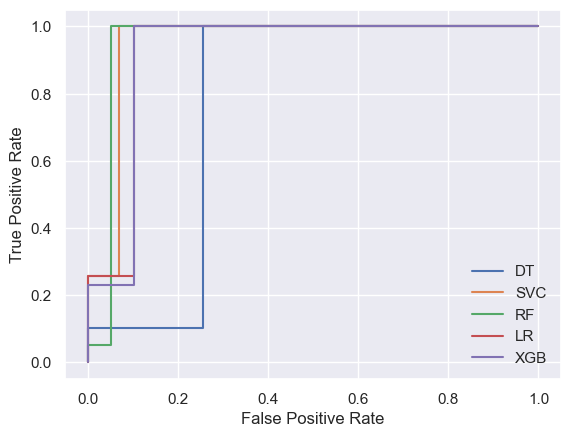

In [199]:
class_report_plot(y_test, dt_pred)
class_report_plot(y_test, svm_pred)
class_report_plot(y_test, rf_pred)
class_report_plot(y_test, lr_pred)
class_report_plot(y_test, xgb_pred)

# Appendix

## Appendix 1:  5/19/2024

Enrich `mars.csv` with potentially useful information from `rush_additional.csv` and `rush_final_20210708.csv` to reduce number of subids lost after merge with OHSU and VA CART

### 1. Read data from `rush_additional.csv` and `rush_final_20210708.csv`
   
    - `rush_additional.csv` and `rush_final_20210708.csv` do not have gender fields, instead they have `msex` which has the same gender mapping as `mars.csv`. 

    - The 6 ids in MARS with missing gender also have missing MCI status, which can be inferred through `dcfdx`. In addition to `gender`, `dcfdx` and `mci` must be updated for the 6 subids

In [241]:
mars = pd.read_csv(demo_path + 'mars.csv')
mars = mars.iloc[:,1:] # Dropped index column
mars['gender'].value_counts()

gender
0.0    54
1.0    14
Name: count, dtype: int64

In [242]:
mars_final = pd.read_csv(demo_path + 'rush_final_20210708.csv')
mars_final.rename(columns = {'home_id': 'homeid', 'sub_id': 'subid'}, inplace = True)
set(mars_final.columns) - set(mars.columns); # 323 vs 263



In [243]:
set(mars['subid'].unique()) - set(mars_final['subid'].unique()) # MARS = 74, MARS_FINAL = 68; MARS.columns = 263, MARS_FINAL.columns = 323

{1791, 1885, 1886, 2022, 2028, 2179}

In [244]:
mars_additional = pd.read_csv(demo_path + 'rush_additional.csv') 
mars_additional.rename(columns = {'home_id': 'homeid', 'sub_id': 'subid'}, inplace = True)

mars_additional

,projid,fu_year,subid,homeid,visseq,dcfdx,cts_mmse30,age_at_visit,age_bl,age_death,educ,msex,race7,spanish
0,22121512,4,1791,1577,22121512_4,1,25.0,81.284052,76.303901,82.746064,12.0,0.0,2.0,2.0
1,22121512,5,1791,1577,22121512_5,1,27.0,82.631075,NaN,NaN,NaN,NaN,NaN,NaN
2,45438846,0,2259,1968,45438846_0,2,26.0,69.782341,69.782341,71.184120,18.0,0.0,2.0,2.0
3,45438846,1,2259,1968,45438846_1,1,NaN,70.475017,NaN,NaN,NaN,NaN,NaN,NaN
4,49758987,7,1937,1690,49758987_7,1,29.0,78.160164,70.455852,79.044490,12.0,1.0,2.0,2.0


### 2. Determine any overlap in subject IDs between the three files

In [245]:
mars_add_in_mars = [id for id in mars_additional['subid'].unique() if id in mars['subid'].unique().astype('int64')] # MARS_ADD & MARS = 3/74
mars_final_in_mars = [id for id in mars_final['subid'].unique().astype('int64') if id in mars['subid'].unique().astype('int64')] # MARS_FINAL & MARS = 68/74
mars_add_in_final = [id for id in mars_additional['subid'].unique() if id in mars_final['subid'].unique().astype('int64')] # MARS_ADD & MARS_FINAL = 2/68
len(mars_add_in_final)

/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/4081073189.py:2: RuntimeWarning: invalid value encountered in cast
  mars_final_in_mars = [id for id in mars_final['subid'].unique().astype('int64') if id in mars['subid'].unique().astype('int64')] # MARS_FINAL & MARS = 68/74
/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_30530/4081073189.py:3: RuntimeWarning: invalid value encountered in cast
  mars_add_in_final = [id for id in mars_additional['subid'].unique() if id in mars_final['subid'].unique().astype('int64')] # MARS_ADD & MARS_FINAL = 2/68


2

#### 5/19/2024: Read data from `rush_additional.csv` and `rush_final_20210708.csv` as we lose subjects from this cohort when combining with CART

`rush_additional.csv` and `rush_final_20210708.csv` do not have gender fields, instead they have `msex` which has the same gender mapping as `mars.csv`. 

The 6 ids in MARS with missing gender also have missing MCI status, which can be inferred through `dcfdx`. In addition to `gender`, `dcfdx` and `mci` must be updated for the 6 subids

### 3. Use `mars_additional` to update any missing values 

    - in `mars_final`
    - Repeat to update `mars`

This is because `mars_additional` has ids in common with both dfs. We can then update `mars` using `mars_final` for any differences that may occur

In [246]:
mars_add_f = mars_additional.loc[mars_additional['subid'].isin(mars_add_in_final),mars_final.columns.intersection(mars_additional.columns)]
mars_add_f

,projid,subid,homeid,dcfdx,cts_mmse30,age_death,educ,msex,spanish
2,45438846,2259,1968,2,26.0,71.18412,18.0,0.0,2.0
3,45438846,2259,1968,1,NaN,NaN,NaN,NaN,NaN
4,49758987,1937,1690,1,29.0,79.04449,12.0,1.0,2.0


In [247]:
mars_final_a = mars_final.loc[mars_final['subid'].isin(mars_add_in_final),mars_final.columns.intersection(mars_additional.columns)]
mars_final_a.reset_index(drop = True, inplace = True)
mars_final_a

,projid,subid,homeid,dcfdx,cts_mmse30,age_death,educ,msex,spanish
0,45438846,2259.0,1968.0,2.0,26.0,NaN,18.0,0.0,2.0
1,49758987,1937.0,1690.0,1.0,29.0,79.04449,12.0,1.0,2.0


In [248]:
mars_final_a.compare(mars_add_f.dropna().reset_index(drop=True), result_names = ('mars_final', 'mars_additional'))


age_death                
  mars_final mars_additional
0        NaN        71.18412

We need to update 'age_death' for the subid in index 0 in `mars_final`

In [249]:
index_to_update = mars_final_a.compare(mars_add_f.dropna().reset_index(drop=True), result_names = ('mars_final', 'mars_additional')).index[0]
col_to_update = mars_final_a.compare(mars_add_f.dropna().reset_index(drop=True), result_names = ('mars_final', 'mars_additional')).columns[0][0]
id_to_update = mars_final_a.loc[index_to_update,'subid'].tolist()

val_to_update = mars_add_f.dropna().reset_index(drop=True).at[index_to_update, col_to_update]


In [250]:
mars_final.loc[mars_final['subid'] == id_to_update,col_to_update] = val_to_update
mars_final.loc[mars_final['subid'] == id_to_update,['subid',col_to_update]] 

,subid,age_death
68,2259.0,71.18412


### 4. Find differences/missing values between `mars_additional` and `mars` and update

In [251]:
mars_subset_a = mars.loc[mars['subid'].isin(mars_add_in_mars), mars.columns.intersection(mars_additional.columns)].sort_values('subid').reset_index(drop=True)
mars_subset_a

,subid,homeid,projid,dcfdx,cts_mmse30,educ
0,1791,1577,22121512,NaN,NaN,NaN
1,1937,1690,49758987,1.0,29.0,12.0
2,2259,1968,45438846,2.0,26.0,18.0


In [252]:
mars_add_mars = mars_additional.loc[mars_additional['subid'].isin(mars_add_in_mars), mars.columns.intersection(mars_additional.columns)].dropna().sort_values('subid').reset_index(drop=True)
mars_add_mars

,subid,homeid,projid,dcfdx,cts_mmse30,educ
0,1791,1577,22121512,1,25.0,12.0
1,1937,1690,49758987,1,29.0,12.0
2,2259,1968,45438846,2,26.0,18.0


In [253]:
mars_subset_a.compare(mars_add_mars, result_names = ('mars', 'mars_additional'))

dcfdx                 cts_mmse30                 educ                
   mars mars_additional       mars mars_additional mars mars_additional
0   NaN             1.0        NaN            25.0  NaN            12.0

In [254]:
index_to_update = mars_subset_a.compare(mars_add_mars, result_names = ('mars', 'mars_additional')).index[0]
multi_ind_cols = mars_subset_a.compare(mars_add_mars, result_names = ('mars', 'mars_additional')).columns[[0,2,4]]
cols_to_update = [tup[0] for tup in multi_ind_cols]
id_to_update = mars_subset_a.at[index_to_update,'subid']
vals_to_update = mars_additional.loc[mars_additional['subid'] == id_to_update,cols_to_update].dropna().values[0]

In [255]:
for (val, col) in zip(vals_to_update,cols_to_update):
    mars.loc[mars['subid']==id_to_update,col] = val

In [256]:
mars.loc[mars['subid']==id_to_update, ['subid'] + cols_to_update]

,subid,dcfdx,cts_mmse30,educ
17,1791,1.0,25.0,12.0


### 5. Enrich `1791` data using `mars_additional`

In [257]:
mars_final_mars = mars_final.loc[mars_final['subid'].isin(mars_final_in_mars),mars.columns.intersection(mars_final.columns)].sort_values('subid')
mars_final_mars = mars_final_mars.loc[(mars_final_mars['dcfdx'].notna()) &(mars_final_mars['educ'].notna()) & (mars_final_mars['cts_mmse30'].notna())   ,:].reset_index(drop=True)
update_dtypes(mars_final_mars,['subid','homeid'],'int64')
mars_final_mars

,subid,homeid,projid,dcfdx,cts_mmse30,educ,q1mme,q2mme,q3mme,q4mme,q5mme,q6mme,q7mme,q8mme,q9mme,q10amme,q10bmme,apple,tabl,penny,q12amme,q12bmme,q13amme,q13bmme,q13cmme,q14mme,q15mme,q16mme,q17mme,paper,folds,places,q19mme,q20mme,story,tree,bed,whistle,flower,house,canoe,toothbr,volcano,mask,camel,harmon,tongs,hammock,funnel,domino,cantread,wordt1_1,wordt1_2,wordt1_3,wordt1_4,wordt1_5,wordt1_6,wordt1_7,wordt1_8,wordt1_9,wordt1_x,wordt2_1,wordt2_2,wordt2_3,wordt2_4,wordt2_5,wordt2_6,wordt2_7,wordt2_8,wordt2_9,wordt2_x,wordt3_1,wordt3_2,wordt3_3,wordt3_4,wordt3_5,wordt3_6,wordt3_7,wordt3_8,wordt3_9,wordt3_x,page3,page4,page5,page6,page7,page8,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6,recall_7,recall_8,recall_9,recall_x,wrdrecb1,wrdrecb2,wrdrecb3,wrdrecb4,wrdrecb5,wrdrecb6,wrdrecb7,wrdrecb8,wrdrecb9,wrdrecbx,wordrec1,wordrec2,wordrec3,wordrec4,wordrec5,wordrec6,wordrec7,wordrec8,wordrec9,wordrecx,line1a,line1b,line2a,line2b,line3a,line3b,line4a,line4b,line5a,line5b,line6a,line6b,line7a,line7b,line8a,line8b,line9a,line9b,line10a,line10b,line11a,line11b,line12a,line12b,line13a,line13b,line14a,line14b,line15a,line15b,digfor1a,digfor1b,digfor2a,digfor2b,digfor3a,digfor3b,digfor4a,digfor4b,digfor5a,digfor5b,digfor6a,digfor6b,digbakp1,digbakp2,digbak1a,digbak1b,digbak2a,digbak2b,digbak3a,digbak3b,digbak4a,digbak4b,digbak5a,digbak5b,digbak6a,digbak6b,clothing,animals,fruits,sink1,sink2,hammer1,hammer2,flour1,flour2,boots1,boots2,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,item11,item12,item13,item14,item15,item16,a2,a4,a8,a12,b1,b2,b3,b4,b5,b6,b8,b10,row1,row2,row3,row4,row5,row6,row7,row8,row9,row10,row11,nart_ach,nart_ind,nart_deb,nart_sie,nart_pla,nart_fac,nart_imp,nart_bla,nart_cav,nart_cab,bluebox,greenbox,graybox,redbox,readatm,readinc,practred,practblu,coloratm,colorinc,smell1,smell2,smell3,smell4,smell5,smell6,smell7,smell8,smell9,smell10,smell11
0,1727.0,1517.0,90725109,1.0,30.0,18.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dlrow,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,ddsssdss,dsdsddds,sssssdds,ds,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,2.0,8.0,3.0,1.0,10.0,11.0,8.0,1.0,4.0,2.0,10.0,2.0,5.0,10.0,7.0,1.0,2.0,10.0,5.0,1.0,10.0,11.0,9.0,5.0,8.0,11.0,3.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,4.0,15.0,20.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,14.0,89.0,14.0,236.0,1234.0,1246.0,3577.0,1279.0,227569.0,13699.0,1457899.0,345679.0,126899.0,345689.0,NaN,NaN,5.0,2.0,2.0,6.0,2.0,6.0,1.0,2.0,1.0,3.0,6.0,3.0,2.161246e+09,6.341269e+09,4.578137e+09,2.934725e+09,4.156798e+09,9.500000e+01,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,39.0,0.0,1.0,1.0,29.0,0.0,2.0,2.0,4.0,3.0,2.0,2.0,4.0,1.0,3.0,4.0,1.0
1,1728.0,1518.0,81999770,2.0,28.0,20.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dlrow,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,ddsssdss,dsdssdds,sssssdds,sssdsdd,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,6.0,2.0,7.0,1.0,10.0,11.0,8.0,1.0,3.0,2.0,9.0,2.0,4.0,7.0,9.0,1.0,2.0,5.0,9.0,1.0,9.0,11.0,7.0,5.0,8.0,11.0,2.0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,4.0,15.0,19.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,14.0,89.0,14.0,236.0,1234.0,1246.0,2577.0,1279.0,225677.0,16799.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,2.0,6.0,2.0,6.0,1.0,2.0,1.0,3.0,4.0,3.0,2.161246e+09,6.

In [258]:
mars_final_mars.loc[(mars_final_mars['dcfdx'].notna()) &(mars_final_mars['educ'].notna()) & (mars_final_mars['cts_mmse30'].notna())   ,:].reset_index(drop=True)


,subid,homeid,projid,dcfdx,cts_mmse30,educ,q1mme,q2mme,q3mme,q4mme,q5mme,q6mme,q7mme,q8mme,q9mme,q10amme,q10bmme,apple,tabl,penny,q12amme,q12bmme,q13amme,q13bmme,q13cmme,q14mme,q15mme,q16mme,q17mme,paper,folds,places,q19mme,q20mme,story,tree,bed,whistle,flower,house,canoe,toothbr,volcano,mask,camel,harmon,tongs,hammock,funnel,domino,cantread,wordt1_1,wordt1_2,wordt1_3,wordt1_4,wordt1_5,wordt1_6,wordt1_7,wordt1_8,wordt1_9,wordt1_x,wordt2_1,wordt2_2,wordt2_3,wordt2_4,wordt2_5,wordt2_6,wordt2_7,wordt2_8,wordt2_9,wordt2_x,wordt3_1,wordt3_2,wordt3_3,wordt3_4,wordt3_5,wordt3_6,wordt3_7,wordt3_8,wordt3_9,wordt3_x,page3,page4,page5,page6,page7,page8,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6,recall_7,recall_8,recall_9,recall_x,wrdrecb1,wrdrecb2,wrdrecb3,wrdrecb4,wrdrecb5,wrdrecb6,wrdrecb7,wrdrecb8,wrdrecb9,wrdrecbx,wordrec1,wordrec2,wordrec3,wordrec4,wordrec5,wordrec6,wordrec7,wordrec8,wordrec9,wordrecx,line1a,line1b,line2a,line2b,line3a,line3b,line4a,line4b,line5a,line5b,line6a,line6b,line7a,line7b,line8a,line8b,line9a,line9b,line10a,line10b,line11a,line11b,line12a,line12b,line13a,line13b,line14a,line14b,line15a,line15b,digfor1a,digfor1b,digfor2a,digfor2b,digfor3a,digfor3b,digfor4a,digfor4b,digfor5a,digfor5b,digfor6a,digfor6b,digbakp1,digbakp2,digbak1a,digbak1b,digbak2a,digbak2b,digbak3a,digbak3b,digbak4a,digbak4b,digbak5a,digbak5b,digbak6a,digbak6b,clothing,animals,fruits,sink1,sink2,hammer1,hammer2,flour1,flour2,boots1,boots2,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,item11,item12,item13,item14,item15,item16,a2,a4,a8,a12,b1,b2,b3,b4,b5,b6,b8,b10,row1,row2,row3,row4,row5,row6,row7,row8,row9,row10,row11,nart_ach,nart_ind,nart_deb,nart_sie,nart_pla,nart_fac,nart_imp,nart_bla,nart_cav,nart_cab,bluebox,greenbox,graybox,redbox,readatm,readinc,practred,practblu,coloratm,colorinc,smell1,smell2,smell3,smell4,smell5,smell6,smell7,smell8,smell9,smell10,smell11
0,1727.0,1517.0,90725109,1.0,30.0,18.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dlrow,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,ddsssdss,dsdsddds,sssssdds,ds,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,2.0,8.0,3.0,1.0,10.0,11.0,8.0,1.0,4.0,2.0,10.0,2.0,5.0,10.0,7.0,1.0,2.0,10.0,5.0,1.0,10.0,11.0,9.0,5.0,8.0,11.0,3.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,4.0,15.0,20.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,14.0,89.0,14.0,236.0,1234.0,1246.0,3577.0,1279.0,227569.0,13699.0,1457899.0,345679.0,126899.0,345689.0,NaN,NaN,5.0,2.0,2.0,6.0,2.0,6.0,1.0,2.0,1.0,3.0,6.0,3.0,2.161246e+09,6.341269e+09,4.578137e+09,2.934725e+09,4.156798e+09,9.500000e+01,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,39.0,0.0,1.0,1.0,29.0,0.0,2.0,2.0,4.0,3.0,2.0,2.0,4.0,1.0,3.0,4.0,1.0
1,1728.0,1518.0,81999770,2.0,28.0,20.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dlrow,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,ddsssdss,dsdssdds,sssssdds,sssdsdd,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,6.0,2.0,7.0,1.0,10.0,11.0,8.0,1.0,3.0,2.0,9.0,2.0,4.0,7.0,9.0,1.0,2.0,5.0,9.0,1.0,9.0,11.0,7.0,5.0,8.0,11.0,2.0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,4.0,15.0,19.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,14.0,89.0,14.0,236.0,1234.0,1246.0,2577.0,1279.0,225677.0,16799.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,2.0,6.0,2.0,6.0,1.0,2.0,1.0,3.0,4.0,3.0,2.161246e+09,6.

In [259]:
mars_subset_f = mars.loc[mars['subid'].isin(mars_final_in_mars), mars.columns.intersection(mars_final.columns)].sort_values('subid').reset_index(drop=True)
mars_subset_f

,subid,homeid,projid,dcfdx,cts_mmse30,educ,q1mme,q2mme,q3mme,q4mme,q5mme,q6mme,q7mme,q8mme,q9mme,q10amme,q10bmme,apple,tabl,penny,q12amme,q12bmme,q13amme,q13bmme,q13cmme,q14mme,q15mme,q16mme,q17mme,paper,folds,places,q19mme,q20mme,story,tree,bed,whistle,flower,house,canoe,toothbr,volcano,mask,camel,harmon,tongs,hammock,funnel,domino,cantread,wordt1_1,wordt1_2,wordt1_3,wordt1_4,wordt1_5,wordt1_6,wordt1_7,wordt1_8,wordt1_9,wordt1_x,wordt2_1,wordt2_2,wordt2_3,wordt2_4,wordt2_5,wordt2_6,wordt2_7,wordt2_8,wordt2_9,wordt2_x,wordt3_1,wordt3_2,wordt3_3,wordt3_4,wordt3_5,wordt3_6,wordt3_7,wordt3_8,wordt3_9,wordt3_x,page3,page4,page5,page6,page7,page8,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6,recall_7,recall_8,recall_9,recall_x,wrdrecb1,wrdrecb2,wrdrecb3,wrdrecb4,wrdrecb5,wrdrecb6,wrdrecb7,wrdrecb8,wrdrecb9,wrdrecbx,wordrec1,wordrec2,wordrec3,wordrec4,wordrec5,wordrec6,wordrec7,wordrec8,wordrec9,wordrecx,line1a,line1b,line2a,line2b,line3a,line3b,line4a,line4b,line5a,line5b,line6a,line6b,line7a,line7b,line8a,line8b,line9a,line9b,line10a,line10b,line11a,line11b,line12a,line12b,line13a,line13b,line14a,line14b,line15a,line15b,digfor1a,digfor1b,digfor2a,digfor2b,digfor3a,digfor3b,digfor4a,digfor4b,digfor5a,digfor5b,digfor6a,digfor6b,digbakp1,digbakp2,digbak1a,digbak1b,digbak2a,digbak2b,digbak3a,digbak3b,digbak4a,digbak4b,digbak5a,digbak5b,digbak6a,digbak6b,clothing,animals,fruits,sink1,sink2,hammer1,hammer2,flour1,flour2,boots1,boots2,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,item11,item12,item13,item14,item15,item16,a2,a4,a8,a12,b1,b2,b3,b4,b5,b6,b8,b10,row1,row2,row3,row4,row5,row6,row7,row8,row9,row10,row11,nart_ach,nart_ind,nart_deb,nart_sie,nart_pla,nart_fac,nart_imp,nart_bla,nart_cav,nart_cab,bluebox,greenbox,graybox,redbox,readatm,readinc,practred,practblu,coloratm,colorinc,smell1,smell2,smell3,smell4,smell5,smell6,smell7,smell8,smell9,smell10,smell11
0,1727,1517,90725109,1.0,30.0,18.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dlrow,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,ddsssdss,dsdsddds,sssssdds,ds,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,2.0,8.0,3.0,1.0,10.0,11.0,8.0,1.0,4.0,2.0,10.0,2.0,5.0,10.0,7.0,1.0,2.0,10.0,5.0,1.0,10.0,11.0,9.0,5.0,8.0,11.0,3.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,4.0,15.0,20.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,14.0,89.0,14.0,236.0,1234.0,1246.0,3577.0,1279.0,227569.0,13699.0,1457899.0,345679.0,126899.0,345689.0,NaN,NaN,5.0,2.0,2.0,6.0,2.0,6.0,1.0,2.0,1.0,3.0,6.0,3.0,2.161246e+09,6.341269e+09,4.578137e+09,2.934725e+09,4.156798e+09,9.500000e+01,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,39.0,0.0,1.0,1.0,29.0,0.0,2.0,2.0,4.0,3.0,2.0,2.0,4.0,1.0,3.0,4.0,1.0
1,1728,1518,81999770,2.0,28.0,20.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,dlrow,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,ddsssdss,dsdssdds,sssssdds,sssdsdd,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,6.0,2.0,7.0,1.0,10.0,11.0,8.0,1.0,3.0,2.0,9.0,2.0,4.0,7.0,9.0,1.0,2.0,5.0,9.0,1.0,9.0,11.0,7.0,5.0,8.0,11.0,2.0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,4.0,15.0,19.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,14.0,89.0,14.0,236.0,1234.0,1246.0,2577.0,1279.0,225677.0,16799.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,2.0,6.0,2.0,6.0,1.0,2.0,1.0,3.0,4.0,3.0,2.161246e+09,6.341269e+

In [260]:
mars_subset_f.compare(mars_final_mars, result_names=('mars', 'mars_final'))

Empty DataFrame
Columns: []
Index: []

### 6. Since we are mainly interested in updating the gender for 6 subjects in `mars`, check if `msex` is the same as `gender`

In [261]:
mars_final_sex = mars_final.loc[mars_final['subid'].isin(mars_final_in_mars), ['subid','msex']].sort_values('subid').dropna().reset_index(drop=True)
mars_final_sex

,subid,msex
0,1727.0,0.0
1,1728.0,0.0
2,1729.0,1.0
3,1730.0,0.0
4,1738.0,0.0
5,1739.0,0.0
6,1740.0,0.0
7,1758.0,0.0
8,1759.0,0.0
9,1760.0,0.0


In [262]:
mars_sex = mars.loc[mars['subid'].isin(mars_final_in_mars), ['subid','gender']].sort_values('subid').reset_index(drop=True)
mars_sex

,subid,gender
0,1727,0.0
1,1728,0.0
2,1729,1.0
3,1730,0.0
4,1738,0.0
5,1739,0.0
6,1740,0.0
7,1758,0.0
8,1759,0.0
9,1760,0.0


In [263]:
msex_v_gender = pd.merge(mars_final_sex, mars_sex, on = 'subid') # both have the same ids
msex_v_gender

,subid,msex,gender
0,1727.0,0.0,0.0
1,1728.0,0.0,0.0
2,1729.0,1.0,1.0
3,1730.0,0.0,0.0
4,1738.0,0.0,0.0
5,1739.0,0.0,0.0
6,1740.0,0.0,0.0
7,1758.0,0.0,0.0
8,1759.0,0.0,0.0
9,1760.0,0.0,0.0


In [264]:
msex_v_gender.iloc[:,1:].diff(axis = 1).iloc[:,-1].value_counts() 


gender
0.0    68
Name: count, dtype: int64

### 7. Since we've now established that these two fields are the same. We can look at reqd fields to be updated for `1791` 

In [265]:
ids_wo_gender = mars.loc[mars['gender'].isna(), ['subid']].values

In [266]:
np.intersect1d(ids_wo_gender, mars_add_in_mars)  # are they any subids whose gender can be updated?

array([1791])

In [267]:
mars.loc[(mars['subid'].isin(mars_add_in_mars)) & (mars['gender'].isna()), ['subid','gender','age','dcfdx','mci']] 

,subid,gender,age,dcfdx,mci
17,1791,NaN,NaN,1.0,NaN


## Appendix 2

### MIAMI CART join has missing values

Missing values for MIAMI-CART checked against the demo file from the original study, which has missing values for the same subids
Due to which these subids are being dropped before the merge. 


1. First generate `CART_OLL_demo`

In [268]:
# Issue with NaNs during join

nans = CART_OLL_demo.loc[CART_OLL_demo['year'].isna(),'subid'].unique()

2. Read `demo.csv` which is the output of the `DemoClean.py` script from the paper

In [269]:
author_processed_demo = pd.read_csv(mobility_path + 'demo.csv')
author_processed_demo.get(author_processed_demo['subid'].isin(nans))


,Unnamed: 0,level_0,subid,study,homeid,index,date_screen,cdrsum,cdrglob,age,gender,race,educ,gait_test_time,mmse,mocatots,animals,veg,traila,trailb,boston,exclude_iadl,exclude_adl,exclude_med,gad_7_total,adcomcirs_total,mobility_inside_home,gds_score,sleepap,remdis,hyposom,sleepoth,crafturs,digforct,digforsl,digbacct,digbacls,mci,year,gait,vstHXlivewhere,bed_time,number_of_minutes,getting_up_time,hours_sleep_night,latency,h_sleep,n_room,study_num,study_dic,study_dic2


In [270]:
homeid_nans = author_processed_demo.loc[author_processed_demo['subid'].isin(nans),'homeid'].astype('int').to_list()

In [271]:
pd.DataFrame({'my subids':CART_OLL_demo.loc[CART_OLL_demo['subid'].isin(nans), 'subid'].sort_index(ignore_index = True), 
              "author's":author_processed_demo.loc[author_processed_demo['subid'].isin(nans),'subid'].sort_index(ignore_index = True),
             'difference': CART_OLL_demo.loc[CART_OLL_demo['subid'].isin(nans), 'subid'].sort_index(ignore_index = True) - 
              author_processed_demo.loc[author_processed_demo['subid'].isin(nans),'subid'].sort_index(ignore_index = True)})

,my subids,author's,difference


In [272]:
# Confirm that the set of subids with missing year are equivalent to the set of subids with missing values
# for MIAMICART
all(CART_OLL_demo.loc[CART_OLL_demo['subid'].isin(nans), 'subid'].sort_index(ignore_index = True) - 
    CART_OLL_demo.loc[CART_OLL_demo['year'].isna(), 'subid'].sort_index(ignore_index = True))

True

In [273]:
# Confirm the same for the author's demo file
all(author_processed_demo.loc[author_processed_demo['year'].isna(),'subid'].sort_index(ignore_index = True) - 
    author_processed_demo.loc[author_processed_demo['subid'].isin(nans),'subid'].sort_index(ignore_index = True))

True